# pip install and imports


In [15]:
# ==========================
# Install packages
# ==========================
!pip install git+https://github.com/networkgeometry/mercator.git@master
!pip install mercator torchdiffeq sdeint scienceplots omegaconf requests


# ==========================
# Core
# ==========================
import os
import random
import warnings
import pickle
import urllib.request
import zipfile
import re
import json
import csv
import math
import requests
import traceback
from collections import defaultdict
from google.colab import files
import sys
import gc


# ==========================
# Math / Arrays
# ==========================
import numpy as np
import pandas as pd


# ==========================
# PyTorch
# ==========================
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR


# ==========================
# ML / Stats
# ==========================
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler


# ==========================
# Graphs
# ==========================
import networkx as nx
import mercator


# ==========================
# Differential equations
# ==========================
import torchdiffeq as ode
from sdeint import itoEuler


# ==========================
# Plotting
# ==========================
import matplotlib.pyplot as plt
import scienceplots


# ==========================
# Config
# ==========================
from omegaconf import OmegaConf


# ==========================
# Type hinting
# ==========================
from typing import Any, Dict, List, Set


# ==========================
# Suppress warnings
# ==========================
warnings.filterwarnings('ignore')

  Cloning https://github.com/networkgeometry/mercator.git (to revision master) to /tmp/pip-req-build-_q2lg6aw
  Running command git clone --filter=blob:none --quiet https://github.com/networkgeometry/mercator.git /tmp/pip-req-build-_q2lg6aw
  Resolved https://github.com/networkgeometry/mercator.git to commit 3e1368c56aa3c7a0d45bfc35bec3198302478970
  Preparing metadata (setup.py) ... done


# anomaly_detection

In [16]:
class CitationAnomalyDetector:
    def __init__(self, contamination=0.1):
        self.contamination = contamination
        self.isolation_forest = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=100
        )

    def detect_anomalies(self, predicted_dynamics, actual_dynamics):
        """
        Detect anomalies by comparing predicted vs actual citation dynamics

        Args:
            predicted_dynamics: Model predictions (batch_size, horizon, node_num, feature_dim)
            actual_dynamics: Ground truth (batch_size, horizon, node_num, feature_dim)

        Returns:
            anomaly_scores: Deviation scores for each node
            anomaly_labels: Binary labels (-1 = anomaly, 1 = normal)
        """
        # Calculate deviation scores for each node
        deviation_scores = self._calculate_deviation_scores(predicted_dynamics, actual_dynamics)

        # Fit isolation forest and predict anomalies
        anomaly_labels = self.isolation_forest.fit_predict(deviation_scores.reshape(-1, 1))

        return deviation_scores, anomaly_labels

    def _calculate_deviation_scores(self, predicted, actual):
        """Calculate deviation scores between predicted and actual dynamics"""
        # Mean Absolute Error for each node across time and features
        mae_per_node = np.mean(np.abs(predicted - actual), axis=(0, 1, 3))  # Average across batch, time, features
        return mae_per_node

    def evaluate_detection(self, predicted_labels, true_labels):
        """Evaluate anomaly detection performance"""
        # Convert isolation forest labels (-1, 1) to (0, 1)
        predicted_binary = (predicted_labels == 1).astype(int)
        true_binary = true_labels.astype(int)

        precision = precision_score(true_binary, predicted_binary)
        recall = recall_score(true_binary, predicted_binary)

        return precision, recall

    def inject_synthetic_anomalies(self, graph, ratio=0.1):
        """
        Inject synthetic anomalies for testing

        Args:
            graph: NetworkX graph
            ratio: Proportion of nodes to make anomalous

        Returns:
            anomalous_nodes: List of node IDs that are anomalous
            ground_truth: Binary array (1 = anomaly, 0 = normal)
        """
        node_list = list(graph.nodes())
        n_anomalies = int(len(node_list) * ratio)

        # Randomly select nodes to be anomalous
        anomalous_nodes = np.random.choice(node_list, n_anomalies, replace=False)

        # Create ground truth labels
        ground_truth = np.zeros(len(node_list))
        for i, node in enumerate(node_list):
            if node in anomalous_nodes:
                ground_truth[i] = 1

        return anomalous_nodes, ground_truth

# citation_data

In [17]:
class CitationDataset(Dataset):

    def __init__(self, args, mode='train'):
        super().__init__()
        self.args = args
        self.mode = mode
        self.lookback = args.lookback
        self.horizon = args.horizon

        dataset_path = os.path.join(args.data_dir, 'dataset', f'{mode}_{self.lookback}_{self.horizon}.npz')
        try:
            processed_data = np.load(dataset_path)
            self.X = torch.from_numpy(processed_data['X']).float().to(self.args.device)
            self.Y = torch.from_numpy(processed_data['Y']).float().to(self.args.device)
            self.mean_y, self.std_y = processed_data['mean_y'], processed_data['std_y']
        except FileNotFoundError:
            self.process()

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return len(self.X)

    def process(self):
        simulation_path = os.path.join(self.args.data_dir, 'dynamics.npz')
        simulation = np.load(simulation_path)['X']

        lookback = self.args.lookback
        horizon = self.args.horizon

        # Sliding window
        idx = np.arange(0, simulation.shape[0]-lookback-horizon+1)
        X = np.stack([simulation[i:i+lookback] for i in idx], axis=0)
        Y = np.stack([simulation[i+lookback:i+lookback+horizon] for i in idx], axis=0)

        # Normalize
        self.mean_x, self.mean_y = X.mean(axis=(0, 1, 2), keepdims=True), Y.mean(axis=(0, 1, 2), keepdims=True)
        self.std_x, self.std_y = X.std(axis=(0, 1, 2), keepdims=True), Y.std(axis=(0, 1, 2), keepdims=True)
        X = (X - self.mean_x) / self.std_x
        Y = (Y - self.mean_y) / self.std_y

        # Split train, val, test
        train_ratio, val_ratio = self.args.train_ratio, self.args.val_ratio
        train_size, val_size = int(X.shape[0] * train_ratio), int(X.shape[0] * val_ratio)
        train_idx = np.random.choice(np.arange(X.shape[0]), train_size, replace=False)
        val_idx = np.random.choice(np.setdiff1d(np.arange(X.shape[0]), train_idx), val_size, replace=False)
        test_idx = np.setdiff1d(np.arange(X.shape[0]), np.concatenate([train_idx, val_idx]))
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_val, Y_val = X[val_idx], Y[val_idx]
        X_test, Y_test = X[test_idx], Y[test_idx]

        # Save
        os.makedirs(os.path.join(self.args.data_dir, 'dataset'), exist_ok=True)
        np.savez(os.path.join(self.args.data_dir, 'dataset', f'train_{lookback}_{horizon}.npz'), X=X_train, Y=Y_train, mean_y=self.mean_y, std_y=self.std_y)
        np.savez(os.path.join(self.args.data_dir, 'dataset', f'val_{lookback}_{horizon}.npz'), X=X_val, Y=Y_val, mean_y=self.mean_y, std_y=self.std_y)
        np.savez(os.path.join(self.args.data_dir, 'dataset', f'test_{lookback}_{horizon}.npz'), X=X_test, Y=Y_test, mean_y=self.mean_y, std_y=self.std_y)

        # Assign tensors
        if self.mode=='train':
            self.X, self.Y = X_train, Y_train
        elif self.mode=='val':
            self.X, self.Y = X_val, Y_val
        elif self.mode=='test':
            self.X, self.Y = X_test, Y_test

        self.X = torch.from_numpy(self.X).float().to(self.args.device)
        self.Y = torch.from_numpy(self.Y).float().to(self.args.device)

    def getLoader(self):
        return DataLoader(self, batch_size=self.args.batch_size, shuffle=True, drop_last=True)


# dynamics

In [18]:
class FitzHughNagumo:
    def __init__(self, args, A):
        self.L = A - np.diag(np.sum(A, axis=1)) # Difussion matrix: x_j - x_i

        param = args[args.dynamics]
        self.a = param.a
        self.b = param.b
        self.c = param.c
        self.epsilon = param.epsilon
        self.k_in = np.sum(A, axis=1) # in-degree

    def f(self, x, t):

        node_num = x.shape[0] // 2
        x1, x2 = x[:node_num], x[node_num:]

        # x1
        f_x1 = x1 - (x1 ** 3)/3 - x2
        outer_x1 = self.epsilon * np.dot(self.L, 1/self.k_in) # epsilon * sum_j Aij * ((x1_j - x1_i) / k_in_i)
        dx1dt = f_x1 + outer_x1

        # x2
        f_x2 = self.a + self.b * x1 + self.c * x2
        outer_x2 = 0.0
        dx2dt = f_x2 + outer_x2

        if np.isnan(dx1dt).any():
            print('nan during simulation!')
            exit()

        dxdt = np.concatenate([dx1dt, dx2dt], axis=0)
        return dxdt

    def g(self, x, t):
        """inherent noise"""
        return np.diag([0.0] * x.shape[0])


class HindmarshRose:
    def __init__(self, args, A):
        self.A = A   # Adjacency matrix

        param = args[args.dynamics]
        self.a = param.a
        self.b = param.b
        self.c = param.c
        self.u = param.u
        self.s = param.s
        self.r = param.r
        self.epsilon = param.epsilon
        self.v = param.v
        self.lam = param.lam
        self.I = param.I
        self.omega = param.omega
        self.x0 = param.x0

    def f(self, x, t):

        node_num = x.shape[0] // 3
        x1, x2, x3 = x[:node_num], x[node_num:2*node_num], x[2*node_num:]
        mu_xj = 1 / (1 + np.exp(-self.lam * (x1 - self.omega)))

        # x1
        f_x1 = x2 - self.a * x1 ** 3 + self.b * x1 ** 2 - x3 + self.I
        outer_x1 = self.epsilon * (self.v - x1) * np.dot(self.A, mu_xj)
        dx1dt = f_x1 + outer_x1

        # x2
        f_x2 = self.c - self.u * x1 ** 2 - x2
        outer_x2 = 0.0
        dx2dt = f_x2 + outer_x2

        # x3
        f_x3 = self.r * (self.s * (x1 - self.x0) - x3)
        outer_x3 = 0.0
        dx3dt = f_x3 + outer_x3

        if np.isnan(dx1dt).any():
            print('nan during simulation!')
            exit()

        dxdt = np.concatenate([dx1dt, dx2dt, dx3dt], axis=0)
        return dxdt

    def g(self, x, t):
        """inherent noise"""
        return np.diag([0.0] * x.shape[0])


class CoupledRossler:
    def __init__(self, args, A):
        self.L = A - np.diag(np.sum(A, axis=1)) # Difussion matrix: x_j - x_i

        param = args[args.dynamics]
        self.a = param.a
        self.b = param.b
        self.c = param.c
        self.epsilon = param.epsilon
        self.delta = param.delta

    def f(self, x, t):

        node_num = x.shape[0] // 3
        x1, x2, x3 = x[:node_num], x[node_num:2*node_num], x[2*node_num:]
        omega = np.random.normal(1, self.delta, size=node_num)

        # x1
        f_x1 = - omega * x2 - x3
        outer_x1 = self.epsilon * np.dot(self.L, x1)
        dx1dt = f_x1 + outer_x1

        # x2
        f_x2 = omega * x1 + self.a * x2
        outer_x2 = 0.0
        dx2dt = f_x2 + outer_x2

        # x3
        f_x3 = self.b + x3 * (x1 + self.c)
        outer_x3 = 0.0
        dx3dt = f_x3 + outer_x3

        if np.isnan(dx1dt).any():
            print('nan during simulation!')
            exit()

        dxdt = np.concatenate([dx1dt, dx2dt, dx3dt], axis=0)
        return dxdt

    def g(self, x, t):
        """inherent noise"""
        return np.diag([0.0] * x.shape[0])

# metrics

In [19]:
def MAE(y_true, y_pred, keep_step=False, keep_node=False):
    if not keep_step and not keep_node:
        return np.mean(np.abs(y_true - y_pred))
    elif keep_step and not keep_node:
        return np.mean(np.abs(y_true - y_pred), axis=(0,2,3))
    elif not keep_step and keep_node:
        return np.mean(np.abs(y_true - y_pred), axis=(0,1,3))

def MSE(y_true, y_pred, keep_step=False, keep_node=False):
    if not keep_step and not keep_node:
        return np.mean(np.square(y_true - y_pred))
    elif keep_step and not keep_node:
        return np.mean(np.square(y_true - y_pred), axis=(0,2,3))
    elif not keep_step and keep_node:
        return np.mean(np.abs(y_true - y_pred), axis=(0,1,3))

def RMSE(y_true, y_pred, keep_step=False):
    if not keep_step:
        return np.sqrt(np.mean(np.square(y_true - y_pred)))
    else:
        return np.sqrt(np.mean(np.square(y_true - y_pred), axis=(0,2,3)))

def NMSE(y_true, y_pred, keep_step=False):
    if not keep_step:
        return np.mean(np.square(y_true - y_pred)) / (np.mean(np.square(y_true)) + 1e-7)
    else:
        return np.mean(np.square(y_true - y_pred), axis=(0,2,3)) / (np.mean(np.square(y_true), axis=(0,2,3)) + 1e-7)

# simluator

In [20]:
sites = {
    'Drosophila': 'https://nrvis.com/download/data/bn/bn-fly-drosophila_medulla_1.zip',
    'PowerGrid': 'https://nrvis.com/download/data/power/power-bcspwr10.zip',
    'Social': 'https://nrvis.com/download/data/soc/fb-pages-tvshow.zip',
    'Web': 'https://nrvis.com/download/data/web/web-EPA.zip',
    'Airport': 'https://nrvis.com/download/data/inf/inf-openflights.zip',
}


class NetworkSimulator(object):

    def __init__(self, args: dict):
        self.args = args
        self.G = None
        self.HyperbolicG = None

    def buildNetwork(self):
      # --- 1. Handle Citation network first ---
      if self.args.graph_type == 'citation':
          import os
          import pandas as pd
          import networkx as nx
          import numpy as np

          os.makedirs(self.args.data_dir, exist_ok=True)

          edge_path = f'{self.args.data_dir}/validation_edges.csv'

          if not os.path.exists(edge_path):
              raise FileNotFoundError(f"Citation network file not found: {edge_path}")

          # Load the citation graph
          try:
              df_edges = pd.read_csv(edge_path, dtype=str) # Explicitly set dtype to str
              if 'cited' not in df_edges.columns or 'cites' not in df_edges.columns:
                  raise ValueError("CSV does not have required 'cited' and 'cites' columns.")
          except Exception:
              # Try space-separated
              df_edges = pd.read_csv(edge_path, delimiter=' ', dtype=str)
              if 'cited' not in df_edges.columns or 'cites' not in df_edges.columns:
                  raise ValueError("CSV does not have required 'cited' and 'cites' columns.")

          # Create directed graph
          self.G = nx.from_pandas_edgelist(df_edges, source='cited', target='cites', create_using=nx.DiGraph())
          print(f"Loaded citation graph with {self.G.number_of_nodes()} nodes and {self.G.number_of_edges()} edges")

          # --- POST-PROCESSING ---
          # Remove isolated nodes
          self.G.remove_nodes_from(list(nx.isolates(self.G)))
          # Remove self-loops
          self.G.remove_edges_from(nx.selfloop_edges(self.G))
          # Keep only largest weakly connected component
          self.G = self.G.subgraph(max(nx.weakly_connected_components(self.G), key=len)).copy()

          # Keep even number of nodes
          if self.G.number_of_nodes() % 2 == 1:
              self.G.remove_node(np.random.choice(list(self.G.nodes())))

          # Create a mapping from current (string) node IDs to new integer IDs (0 to N-1)
          old_labels_in_order = sorted(list(self.G.nodes())) # Deterministic order
          old_to_new_label_map = {old_label: new_int_label for new_int_label, old_label in enumerate(old_labels_in_order)}
          self.G = nx.relabel_nodes(self.G, old_to_new_label_map)

          # Create the reverse mapping (integer to original string ID)
          graph_node_map_int_to_str = {new_int_label: old_label for old_label, new_int_label in old_to_new_label_map.items()}

          # Save this mapping to a JSON file
          map_path = os.path.join(self.args.data_dir, 'graph_node_map_int_to_str.json')
          with open(map_path, 'w') as f:
              json.dump(graph_node_map_int_to_str, f)
          print(f"Node ID mapping saved to: {map_path}")

          # Save edge list
          nx.write_edgelist(self.G, f'{self.args.data_dir}/graph.txt', data=False)
          print(f'Save citation graph with {self.G.number_of_nodes()} nodes and {self.G.number_of_edges()} edges')

          # Return graph and adjacency matrix
          return self.G, nx.to_numpy_array(self.G)



      else:
          try:
              with open(f'{self.args.data_dir}/graph.pkl', 'rb') as file:
                  graph = pickle.load(file)
                  self.G = graph.G
                  print(f'Load {self.args.graph_type} graph with {self.G.number_of_nodes()} nodes and {self.G.number_of_edges()} edges')

          except:
              os.makedirs(self.args.data_dir, exist_ok=True)

              # Create graph
              if self.args.graph_type == 'BA':
                  self.G = nx.barabasi_albert_graph(self.args.node_num, self.args.edge_num, seed=self.args.seed)
              elif self.args.graph_type == 'WS':
                  self.G = nx.watts_strogatz_graph(self.args.node_num, self.args.ring_lattice_k, self.args.rewiring_prob, seed=self.args.seed)
              elif self.args.graph_type == 'Drosophila':
                  self._downloadNetwork()
                  self.G = nx.read_edgelist(f'{self.args.data_dir}/bn/bn-fly-drosophila_medulla_1.edges', create_using=nx.DiGraph)
                  self.G = self.G.to_undirected()
              elif self.args.graph_type == 'PowerGrid':
                  self._downloadNetwork()
                  self.G = nx.read_edgelist(f'{self.args.data_dir}/power-bcspwr10.mtx', create_using=nx.DiGraph)
                  self.G = self.G.to_undirected()
              elif self.args.graph_type == 'Social':
                  self._downloadNetwork()
                  self.G = nx.read_edgelist(f'{self.args.data_dir}/fb-pages-tvshow.edges', create_using=nx.DiGraph)
                  self.G = self.G.to_undirected()
              elif self.args.graph_type == 'Web':
                  self._downloadNetwork()
                  self.G = nx.read_edgelist(f'{self.args.data_dir}/web-EPA.edges', create_using=nx.DiGraph)
                  self.G = self.G.to_undirected()
              elif self.args.graph_type == 'Airport':
                  self._downloadNetwork()
                  self.G = nx.read_edgelist(f'{self.args.data_dir}/inf-openflights.edges', create_using=nx.DiGraph)
                  self.G = self.G.to_undirected()
              else:
                  raise Exception(f'Invalid graph type: {self.args.graph_type}')

          # delete isolated nodes
          self.G.remove_nodes_from(list(nx.isolates(self.G)))
          # delete self-loop edges
          self.G.remove_edges_from(nx.selfloop_edges(self.G))
          # only keep the largest connected component
          self.G = self.G.subgraph(max(nx.connected_components(self.G), key=len))

          # keep even number of nodes for static RG model
          if self.G.number_of_nodes() % 2 == 1:
              print(self.G.number_of_nodes())
              self.G.remove_node(np.random.choice(list(self.G.nodes())))
              print(self.G.number_of_nodes())

          # Create a mapping from current node IDs to new integer IDs (0 to N-1)
          old_labels_in_order = sorted(list(self.G.nodes())) # Deterministic order
          old_to_new_label_map = {old_label: new_int_label for new_int_label, old_label in enumerate(old_labels_in_order)}
          self.G = nx.relabel_nodes(self.G, old_to_new_label_map)

          # Create the reverse mapping (integer to original ID)
          graph_node_map_int_to_str = {new_int_label: old_label for old_label, new_int_label in old_to_new_label_map.items()}

          # Save this mapping to a JSON file
          map_path = os.path.join(self.args.data_dir, 'graph_node_map_int_to_str.json')
          with open(map_path, 'w') as f:
              json.dump(graph_node_map_int_to_str, f)
          print(f"Node ID mapping saved to: {map_path}")

          with open(f'{self.args.data_dir}/graph.pkl', 'wb') as file:
              pickle.dump(self, file)

          nx.write_edgelist(self.G, f'{self.args.data_dir}/graph.txt', data=False)

          print(f'Save {self.args.graph_type} graph with {self.G.number_of_nodes()} nodes and {self.G.number_of_edges()} edges')

          return self.G, nx.to_numpy_array(self.G)

    def getHyperbolicEmbedding(self):
        he = HyperbolicEmbedding(args=self.args)
        s1_kappa, s1_angular, h1_radius, mu, beta, radius_s1 = he.fit_transform()

        exp_degree, he_degree = np.mean([d for n, d in nx.degree(self.G)]), 0.1
        # while abs(exp_degree - he_degree) > 0.1:
        p_matrix = self._connectivity_probability_matrix(s1_kappa, s1_angular, mu, beta, radius_s1)
        sampled_A = np.random.binomial(1, p_matrix)
        self.HyperbolicG = nx.from_numpy_array(sampled_A)
        he_degree = np.mean([d for n, d in nx.degree(self.HyperbolicG)])
        mu = mu * (exp_degree / he_degree)

        nx.write_edgelist(self.HyperbolicG, f'{self.args.log_dir}/HE/hyperbolic_graph.txt', data=False)

        print(f'clustering coeficient: {nx.average_clustering(self.G):.3f}-->{nx.average_clustering(self.HyperbolicG):.3f}')
        print(f'degree: {np.mean([d for n, d in nx.degree(self.G)]):.3f}-->{np.mean([d for n, d in nx.degree(self.HyperbolicG)]):.3f}')

        return s1_kappa, s1_angular, h1_radius, mu, beta, radius_s1

    def getSimTraj(self):

        dynamics_path = f'{self.args.data_dir}/dynamics.npz'

        try:
            with np.load(dynamics_path) as data:
                X = data['X']
            print("Loaded existing dynamics")
            print(f'Load {self.args.dynamics} dynamics with {self.args.node_num} nodes')

        except FileNotFoundError:
            print("No dynamics found. Generating dynamics from processed graph...")

            if not hasattr(self, 'G'):
                raise RuntimeError("Graph not found. Please run buildNetwork first.")

            # Use the updated_clean_meta.csv for dynamics generation
            meta_csv = f'{self.args.data_dir}/updated_clean_meta.csv'
            # Use the updated_id2idx_clean.json for dynamics generation
            # idmap_json = f'{self.args.data_dir}/updated_id2idx_clean.json'
            out_dir = self.args.data_dir

            try:
                build_dynamics_from_graph(self.G, meta_csv, out_dir)
            except RuntimeError as e:
                raise RuntimeError(
                    f"Failed to generate dynamics: {e}\n"
                    "Check your metadata CSV for valid 'year' column."
                )

            # reload newly created dynamics
            with np.load(dynamics_path) as data:
                X = data['X']
        """ orignal disknet except
        except:
            dim = self.args[self.args.dynamics].dim

            if self.args.dynamics == 'HindmarshRose':
                sde = HindmarshRose(args=self.args, A=nx.to_numpy_array(self.G))
                x0_1 = np.random.uniform(-1, 0, size=self.args.node_num)
                x0_2 = np.random.uniform(-5, 0, size=self.args.node_num)
                x0_3 = np.random.uniform(3, 3.5, size=self.args.node_num)
                x0 = np.concatenate((x0_1, x0_2, x0_3))
            elif self.args.dynamics == 'FitzHughNagumo':
                sde = FitzHughNagumo(args=self.args, A=nx.to_numpy_array(self.G))
                x0 = np.random.uniform(-1, 1, size=self.args.node_num*dim)
            elif self.args.dynamics == 'CoupledRossler':
                sde = CoupledRossler(args=self.args, A=nx.to_numpy_array(self.G))
                x0 = np.random.uniform(-0.05, 0.05, size=self.args.node_num*dim)

            tspan = np.arange(0, self.args[self.args.dynamics].total_t, self.args[self.args.dynamics].sim_dt)
            sol = itoEuler(sde.f, sde.g, x0, tspan) # (total_t, node_num*feature_dim)

            # downsample
            ratio = int(self.args[self.args.dynamics].dt / self.args[self.args.dynamics].sim_dt)
            sol = sol[::ratio]

            X = np.zeros((sol.shape[0], self.args.node_num, dim))
            for i in range(dim):
                X[:, :, i] = sol[:, i*self.args.node_num:(i+1)*self.args.node_num]

            if self.args.dynamics == 'CoupledKuramoto':
                X = np.sin(X)

            os.makedirs(f'{self.args.data_dir}/{self.args.dynamics}', exist_ok=True)
            np.savez(f'{self.args.data_dir}/{self.args.dynamics}/dynamics.npz', X=X)
            print(f'Save {self.args.dynamics} dynamics with {self.args.node_num} nodes and {self.args[self.args.dynamics].total_t} time steps')
        """
        return X

    def _downloadNetwork(self):
        url = sites[self.args.graph_type]
        file_name = f"{self.args.data_dir}/download.zip"
        urllib.request.urlretrieve(url, file_name)

        with zipfile.ZipFile(file_name, "r") as zip_ref:
            zip_ref.extractall(self.args.data_dir)

        os.remove(file_name)

        if self.args.graph_type == 'PowerGrid':
            # delete header
            with open(f'{self.args.data_dir}/power-bcspwr10.mtx', 'r') as f:
                lines = f.readlines()
            with open(f'{self.args.data_dir}/power-bcspwr10.mtx', 'w') as f:
                f.writelines(lines[14:])
        elif self.args.graph_type == 'Social':
            # replace ',' with ' '
            with open(f'{self.args.data_dir}/fb-pages-tvshow.edges', 'r') as f:
                lines = f.readlines()
            with open(f'{self.args.data_dir}/fb-pages-tvshow.edges', 'w') as f:
                for line in lines:
                    f.write(line.replace(',', ' '))
        elif self.args.graph_type == 'Airport':
            # delete header
            with open(f'{self.args.data_dir}/inf-openflights.edges', 'r') as f:
                lines = f.readlines()
            with open(f'{self.args.data_dir}/inf-openflights.edges', 'w') as f:
                f.writelines(lines[2:])

    def _connectivity_probability_matrix(self, kappa, angular, mu, beta, radius):
        """p_ij = 1 / (1 + (radius*(delta_angular) / (mu*kappa_i*kappa_j))**beta)"""

        abs_delta_angular = np.abs(angular.reshape(-1, 1) - angular.reshape(1, -1))
        delta_angular = np.minimum(abs_delta_angular, 2 * np.pi - abs_delta_angular)
        kappa_mul = kappa.reshape(-1, 1) * kappa.reshape(1, -1)
        rescaled_dist = radius * delta_angular / (mu * kappa_mul)
        p_matrix = 1 / (1 + rescaled_dist ** beta) - np.eye(self.args.node_num)

        return p_matrix


# utils

In [21]:
plt.style.use(['ieee', 'science', 'no-latex'])
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
plt.rcParams["font.family"] = 'DejaVu Sans'


def set_cpu_num(cpu_num: int = 1):
    if cpu_num <= 0: return

    os.environ ['OMP_NUM_THREADS'] = str(cpu_num)
    os.environ ['OPENBLAS_NUM_THREADS'] = str(cpu_num)
    os.environ ['MKL_NUM_THREADS'] = str(cpu_num)
    os.environ ['VECLIB_MAXIMUM_THREADS'] = str(cpu_num)
    os.environ ['NUMEXPR_NUM_THREADS'] = str(cpu_num)
    torch.set_num_threads(cpu_num)


def seed_everything(seed: int = 42):
    # Set the random seed for Python's built-in random module
    random.seed(seed)

    # Set the random seed for NumPy
    np.random.seed(seed)

    # Set the random seed for torch operations
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_model_summary(model):
    print(model)
    print("Number of parameters: {:,}".format(count_parameters(model)))
"""
    print("\nParameter details:")
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            print(name, parameter.shape, parameter.device, parameter.dtype, parameter.numel())
            """


class HyperbolicEmbedding:
    def __init__(self, args: dict):
        self.args = args

    def fit_transform(self):
        # Assuming mercator.embed is the correct function based on original repo usage
        if not os.path.exists(f'{self.args.log_dir}/HE/he.inf_coord'):
            os.makedirs(f'{self.args.log_dir}/HE', exist_ok=True)
            mercator.embed(
                edgelist_filename=f'{self.args.data_dir}/graph.txt',
                quiet_mode=self.args.quiet_mode,
                fast_mode=self.args.fast_mode,
                output_name=f'{self.args.log_dir}/HE/he',
                validation_mode=self.args.validation_mode,
                post_kappa=self.args.post_kappa,
                beta = 0.5
            )

        if self.args.refine:
             mercator.embed(
                edgelist_filename=f'{self.args.data_dir}/graph.txt',
                quiet_mode=self.args.quiet_mode,
                fast_mode=self.args.fast_mode,
                output_name=f'{self.args.log_dir}/HE/he',
                validation_mode=self.args.validation_mode,
                post_kappa=self.args.post_kappa,
                inf_coord=f'{self.args.log_dir}/HE/he.inf_coord',
                beta = 0.5

            )

        return self._parse_mercator_output()

    def _parse_mercator_output(self):
        with open(f'{self.args.log_dir}/HE/he.inf_coord', 'r') as f:
            lines = f.readlines()

        # parse node_num, dim, coords
        node_num = int(lines[7].split()[-1])
        beta = float(lines[8].split()[-1])
        mu = float(lines[9].split()[-1])
        radius_s1 = float(lines[10].split()[-1])
        radius_h2 = float(lines[11].split()[-1])

        s1_kappa = np.zeros(node_num)
        s1_angular = np.zeros(node_num)
        h2_radius = np.zeros(node_num)
        for i in range(15, 15+node_num):
            s1_kappa[i-15] = float(lines[i].split()[1])
            s1_angular[i-15] = float(lines[i].split()[2])
            h2_radius[i-15] = float(lines[i].split()[3])

        return s1_kappa, s1_angular, h2_radius, mu, beta, radius_s1


def drawGraph(G: nx.Graph, layout: str = 'random', filter: str = 'none', threshold = 0.3, out_path: str = 'graph.png'):
    """
    param G: networkX graph
    param layout: layout type, options: random, circular, spring, spectral, shell, kamada_kawai (default: random)
    param filter: disparity filter, options: none, degree, betweenness, random (default: none)
    param threshold: disparity filter threshold (default: 0.3)
    """

    # disparity filter
    if filter == 'degree':
        degree_centrality = nx.degree_centrality(G)
        core_nodes = [node for node, centrality in degree_centrality.items() if centrality >= threshold]
        G = G.subgraph(core_nodes)
    elif filter == 'betweenness':
        betweenness_centrality = nx.betweenness_centrality(G)
        core_nodes = [node for node, centrality in betweenness_centrality.items() if centrality >= threshold]
        G = G.subgraph(core_nodes)
    elif filter == 'random':
        core_nodes = [node for node in G.nodes() if np.random.rand() >= threshold]
        G = G.subgraph(core_nodes)
    else:
        pass

    # layout
    if layout == 'random':
        pos = nx.random_layout(G)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'spring':
        pos = nx.spring_layout(G)
    elif layout == 'spectral':
        pos = nx.spectral_layout(G)
    elif layout == 'shell':
        pos = nx.shell_layout(G)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.random_layout(G)

    # node color and size
    node_color = [G.degree(v) for v in G]
    node_size = [v * 10 for v in node_color]

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_color=node_color, node_size=node_size, edge_color=(0, 0, 0, 0.25))
    plt.savefig(out_path, dpi=300)


def drawTraj(X1, X2, title1, title2, yticks1=None, yticks2=None, dim=0, out_path='traj.png', num=2):
    # X1, X2: (Batch, Node Num, Horizon)
    if isinstance(X1, torch.Tensor):
        data1 = X1[0,:,:,dim].detach().cpu().numpy().T
        data2 = X2[0,:,:,dim].detach().cpu().numpy().T
    else:
        data1 = X1[0,:,:,dim].T
        data2 = X2[0,:,:,dim].T
    if yticks1 is not None:
        yticks1 = yticks1.detach().cpu().numpy()[:,0]
        yticks2 = yticks2.detach().cpu().numpy()[:,0]

    zmax = max(np.max(data1), np.max(data2))
    zmin = min(np.min(data1), np.min(data2))

    # Heatmap
    plt.figure(figsize=(num*4, 4))
    plt.subplot(1, num, 1)
    plt.imshow(data1, cmap='hot', interpolation='nearest', vmin=zmin, vmax=zmax)
    plt.ylabel('Node')
    plt.xlabel('Time Step')
    if yticks1 is not None:
        plt.yticks(np.arange(0, len(yticks1), 1), yticks1)
    plt.title(title1)
    plt.subplot(1, num, 2)
    plt.imshow(data2, cmap='hot', interpolation='nearest', vmin=zmin, vmax=zmax)
    plt.ylabel('Node')
    plt.xlabel('Time Step')
    if yticks1 is not None:
        plt.yticks(np.arange(0, len(yticks2), 1), yticks2)
    plt.title(title2)
    if num == 3:
        plt.subplot(1, num, 3)
        plt.imshow(np.abs(data2-data1), cmap='hot', interpolation='nearest', vmin=zmin, vmax=zmax)
        plt.ylabel('Node')
        plt.xlabel('Time Step')
        if yticks1 is not None:
            plt.yticks(np.arange(0, len(yticks2), 1), yticks2)
        plt.title('MAE')
    # plt.colorbar()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path)
    plt.close()


def draw_embedding(adj, embedding, out_path, label=None, mask=None):
    """
    Draw the embedding.
    """
    if os.path.exists(out_path):
        return

    embedding = embedding.cpu().detach().numpy()
    size = adj.diagonal().cpu().detach().numpy() + 1

    plt.figure(figsize=(4, 4))

    # edge
    tmp = adj >= 1
    idx = np.where(tmp.cpu().detach().numpy())
    for i in range(len(idx[0])):
        plt.plot([embedding[idx[0][i], 0], embedding[idx[1][i], 0]], [embedding[idx[0][i], 1], embedding[idx[1][i], 1]], color="#555555", alpha=0.03, linewidth=0.5)

    # node
    if label is None:
        plt.scatter(embedding[:, 0], embedding[:, 1], s=8, alpha=1.0)
    else:
        if mask is None:
            mask = np.ones_like(label, dtype=bool)
        else:
            mask = mask.cpu().detach().numpy()

        for i in np.unique(label):
            mask_ = (label == i) & mask
            plt.scatter(embedding[mask_, 0], embedding[mask_, 1], s=size[mask_]*1.2, alpha=1.0, label=f'Supernode {i}')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xticks([])
    plt.yticks([])
    # plt.legend(loc='upper right', fontsize=8, frameon=False)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=300)
    plt.close()


def StatisticGraph():

    import pickle
    import networkx as nx
    for graph_type in ['PowerGrid', 'Drosophila', 'Social', 'Web', 'Airport', 'BA_n5000_612', 'WS_n5000_612']:
        with open(f'data/{graph_type}/graph.pkl', 'rb') as file:
            graph = pickle.load(file).G # nx.Graph

        node_num = graph.number_of_nodes()
        edge_num = graph.number_of_edges()
        avg_degree = sum(dict(graph.degree()).values()) / node_num
        avg_clustering = nx.average_clustering(graph)
        density = nx.density(graph)
        print(f'{graph_type.rjust(12)}: Node Num={node_num}, Edge Num={edge_num}, Avg Degree={avg_degree:.4f}, Avg Clustering={avg_clustering:.4f}, Density={density:.4f}')


# if __name__ == '__main__':
#     StatisticGraph()
def create_anomaly_report(conf, network, deviation_scores, anomaly_labels, anomalous_indices):

  report_path = f'{conf.log_dir}/anomaly_report.txt'

  with open(report_path, 'w') as f:
      f.write("CITATION NETWORK ANOMALY DETECTION REPORT\n")
      f.write("="*50 + "\n\n")

      f.write(f"Graph Type: {conf.graph_type}\n")
      f.write(f"Total Nodes: {network.number_of_nodes()}\n")
      f.write(f"Total Edges: {network.number_of_edges()}\n")
      f.write(f"Lookback Window: {conf.lookback}\n")
      f.write(f"Prediction Horizon: {conf.horizon}\n\n")

      f.write("ANOMALY DETECTION RESULTS:\n")
      f.write("-" * 30 + "\n")
      f.write(f"Total Anomalies Detected: {len(anomalous_indices)}\n")
      f.write(f"Anomaly Rate: {len(anomalous_indices)/len(anomaly_labels)*100:.2f}%\n")
      f.write(f"Mean Deviation Score: {np.mean(deviation_scores):.6f}\n")
      f.write(f"Std Deviation Score: {np.std(deviation_scores):.6f}\n\n")

      f.write("TOP 20 MOST ANOMALOUS NODES:\n")
      f.write("-" * 30 + "\n")
      f.write("Rank | Node ID | Deviation Score\n")
      f.write("-" * 35 + "\n")

      top_20 = anomalous_indices[np.argsort(deviation_scores[anomalous_indices])[-20:]]
      for rank, idx in enumerate(reversed(top_20), 1):
          f.write(f"{rank:4d} | {idx:7d} | {deviation_scores[idx]:13.6f}\n")

  print(f"Detailed report saved to: {report_path}")

#Add files from git

In [22]:
# Create necessary directories
os.makedirs("data", exist_ok=True)
os.makedirs("data/citation", exist_ok=True)

# Base URL for raw files from your GitHub repository
base_url = "https://raw.githubusercontent.com/IdoSakal/SkAD-CN/main/phase%20b/dataset/"

# Dictionary mapping files to their destination paths
files_to_download = {
    "config.yaml": "config.yaml",
    "citation_edges.csv": "data/citation_edges.csv",
    "papers_metadata.csv": "data/papers_metadata.csv",
    "Topics and conceptes.JSON": "data/Topics and conceptes.JSON",
    "model_refine_org.pt": "data/model_refine.pt",
}

# Download each file
for filename, local_path in files_to_download.items():
    try:
        url = base_url + filename
        print(f"Downloading {filename}...")

        response = requests.get(url)
        response.raise_for_status()  # Raises an exception for bad status codes

        # Write the file to the local path
        with open(local_path, 'wb') as f:
            f.write(response.content)

        print(f"✓ Successfully downloaded {filename} to {local_path}")

    except requests.exceptions.RequestException as e:
        print(f"✗ Error downloading {filename}: {e}")
    except Exception as e:
        print(f"✗ Unexpected error with {filename}: {e}")

print("\nDownload process completed!")

✓ Successfully downloaded config.yaml to config.yaml
✓ Successfully downloaded citation_edges.csv to data/citation_edges.csv
✓ Successfully downloaded papers_metadata.csv to data/papers_metadata.csv
✓ Successfully downloaded Topics and conceptes.JSON to data/Topics and conceptes.JSON
✓ Successfully downloaded model_refine_org.pt to data/model_refine.pt

Download process completed!


#cleanCitationRaw

In [23]:
# ----------------- config -----------------
edges_csv = "data/citation_edges.csv"
meta_csv  = "data/papers_metadata.csv"
out_dir   = "data/citation"
os.makedirs(out_dir, exist_ok=True)
clean_edges_path = os.path.join(out_dir, "clean_edges.csv")
clean_meta_path  = os.path.join(out_dir, "clean_meta.csv")
# ------------------------------------------

def detect_sep_and_read(path):
    """Detect separator and read CSV robustly, drop all-empty cols and Unnamed.*."""
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        sample = f.read(4096)
    # guess separator
    if sample.count(';') > sample.count(',') and sample.count(';') > sample.count('\t'):
        sep = ';'
    elif sample.count('\t') > sample.count(','):
        sep = '\t'
    else:
        sep = ','
    # Use 'on_bad_lines='skip' to skip malformed rows and specify quotechar
    df = pd.read_csv(path, sep=sep, dtype=str, keep_default_na=False, na_values=[''], on_bad_lines='skip', quotechar='"', engine='python')
    # strip column names
    df.columns = [str(c).strip() for c in df.columns]
    # drop columns that are completely empty or Unnamed...
    def col_all_empty(col):
        vals = col.astype(str).map(lambda x: x.strip())
        return vals.replace('', pd.NA).isna().all()
    drop_cols = [c for c in df.columns if (c.lower().startswith('unnamed') or col_all_empty(df[c]))]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    # trim whitespace in string cells
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

def find_column(df, candidates):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    # try contains
    for cand in candidates:
        for k in cols:
            if cand.lower() in k:
                return cols[k]
    return None

def parse_concepts(s):
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return set()
    parts = re.split(r'[;,|/]', str(s))
    cleaned = {p.strip().lower() for p in parts if p is not None and str(p).strip() != ''}
    return cleaned

print("Reading raw edges from:", edges_csv)
edges_df = detect_sep_and_read(edges_csv)
print("edges cols:", edges_df.columns.tolist())

print("Reading raw meta from:", meta_csv)
meta_df = detect_sep_and_read(meta_csv)
print("meta cols:", meta_df.columns.tolist())

# detect source/target columns in edges
edge_src_col = find_column(edges_df, ['cited', 'source', 'from', 'paper_cited'])
edge_dst_col = find_column(edges_df, ['cites', 'target', 'to', 'paper_citing'])
if edge_src_col is None or edge_dst_col is None:
    raise RuntimeError(f"Could not find source/target columns in edges CSV. cols: {edges_df.columns.tolist()}")

# detect id/year/concepts/topic columns in meta
meta_id_col = find_column(meta_df, ['id', 'paper_id', 'paper', 'pid'])
meta_year_col = find_column(meta_df, ['year', 'pubyear', 'publication_year', 'date'])
meta_concepts_col = find_column(meta_df, ['concepts', 'keywords', 'topics', 'tags'])
meta_topic_col = find_column(meta_df, ['primary_topic', 'topic', 'primarytopic', 'main_topic'])

if meta_id_col is None:
    raise RuntimeError(f"Could not find id column in meta CSV. cols: {meta_df.columns.tolist()}")

# Normalize ids to strings trimmed
edges_df[edge_src_col] = edges_df[edge_src_col].astype(str).map(lambda x: x.strip())
edges_df[edge_dst_col] = edges_df[edge_dst_col].astype(str).map(lambda x: x.strip())
meta_df[meta_id_col] = meta_df[meta_id_col].astype(str).map(lambda x: x.strip())

# 1) Remove self-citations
before = len(edges_df)
edges_df = edges_df[edges_df[edge_src_col] != edges_df[edge_dst_col]].copy()
after = len(edges_df)
print(f"Removed self-citations: {before - after} rows dropped")

# 2) Remove exact duplicate edge rows (same src,dst[,maybe year,...]) -> keep first
# keep only src,dst and any other columns for informational purposes
# But remove duplicates based on src,dst (ignore other columns)
edges_df = edges_df.drop_duplicates(subset=[edge_src_col, edge_dst_col])
print("After dropping duplicate edges (by src,dst):", len(edges_df))

# 3) Build set of ids that appear in edges (either as src or dst)
edge_ids = set(edges_df[edge_src_col].dropna().unique()) | set(edges_df[edge_dst_col].dropna().unique())
print("Unique ids appearing in edges:", len(edge_ids))

# 4) Clean/merge meta: if several rows for same id, aggregate primary_topic into a list (unique)
#    and keep other columns from first occurrence (title, year, concepts merged)
# First, ensure meta has required columns; if not, create empty
if meta_year_col is None:
    meta_df['__year__tmp__'] = ''
    meta_year_col = '__year__tmp__'
if meta_concepts_col is None:
    meta_df['__concepts__tmp__'] = ''
    meta_concepts_col = '__concepts__tmp__'
if meta_topic_col is None:
    meta_df['__topic__tmp__'] = ''
    meta_topic_col = '__topic__tmp__'

# group by id and aggregate
grouped = {}
for _, row in meta_df.iterrows():
    mid = str(row[meta_id_col]).strip()
    if mid == '' or mid.lower() in ['nan','none','na']:
        continue
    if mid not in grouped:
        grouped[mid] = {
            'rows': [],
            'primary_topics': [],
            'concepts_sets': [],
            'year_vals': []
        }
    grouped[mid]['rows'].append(row)
    tp = row.get(meta_topic_col, None)
    if isinstance(tp, str) and tp.strip() != '':
        grouped[mid]['primary_topics'].append(tp.strip())
    # parse concepts
    cs = parse_concepts(row.get(meta_concepts_col, ''))
    if cs:
        grouped[mid]['concepts_sets'].append(cs)
    # year
    yraw = row.get(meta_year_col, '')
    try:
        y = int(float(str(yraw))) if str(yraw).strip() != '' else None
    except Exception:
        y = None
    if y is not None:
        grouped[mid]['year_vals'].append(y)

# build consolidated meta rows
clean_meta_rows = []
for mid, info in grouped.items():
    # primary topics: unique list preserving order
    pts = []
    for p in info['primary_topics']:
        if p not in pts:
            pts.append(p)
    # combine concepts: union of all
    combined_concepts = set()
    for s in info['concepts_sets']:
        combined_concepts |= s
    # choose year: prefer min year found (earliest pub) if exists, else ''
    year_val = ''
    if len(info['year_vals']) > 0:
        year_val = int(min(info['year_vals']))
    # other fields: take from first row (but ensure string types)
    first = info['rows'][0]
    # build cleaned row as dict
    rowdict = {}
    rowdict['id'] = mid
    # try to keep title if exists
    if 'title' in first.index:
        rowdict['title'] = first['title']
    else:
        rowdict['title'] = ''
    rowdict['year'] = year_val if year_val != '' else ''
    # concepts: join sorted
    rowdict['concepts'] = ';'.join(sorted(list(combined_concepts))) if combined_concepts else ''
    # primary_topic(s): join by '|' to indicate multiple primary topics
    rowdict['primary_topic'] = '|'.join(pts) if pts else ''
    clean_meta_rows.append(rowdict)

clean_meta_df = pd.DataFrame(clean_meta_rows, columns=['id','title','year','concepts','primary_topic'])
print("Consolidated meta rows:", len(clean_meta_df))

# 5) Remove articles that never appear in edges (no in and no out) according to the raw edges file
# keep only meta rows whose id in edge_ids
meta_before = len(clean_meta_df)
clean_meta_df = clean_meta_df[clean_meta_df['id'].isin(edge_ids)].reset_index(drop=True)
meta_after = len(clean_meta_df)
print(f"Removed isolated articles (no in/out in edges): {meta_before - meta_after} rows dropped")

# **MODIFICATION: Sort clean_meta_df by 'id'**
clean_meta_df = clean_meta_df.sort_values(by='id').reset_index(drop=True)

# 6) After removing isolated meta items, also filter edges (if any refs point to removed ids)
valid_ids = set(clean_meta_df['id'].astype(str).tolist())
edges_before = len(edges_df)
edges_df = edges_df[edges_df[edge_src_col].isin(valid_ids) & edges_df[edge_dst_col].isin(valid_ids)].copy()
edges_after = len(edges_df)
print(f"Filtered edges to valid meta ids: {edges_before - edges_after} rows dropped")

# 7) Final housekeeping: ensure no self-loops (again) and drop duplicate edges
edges_df = edges_df[edges_df[edge_src_col] != edges_df[edge_dst_col]]
edges_df = edges_df.drop_duplicates(subset=[edge_src_col, edge_dst_col]).reset_index(drop=True)

# **MODIFICATION: Sort edges_df by source then target ID**
edges_df = edges_df.sort_values(by=[edge_src_col, edge_dst_col]).reset_index(drop=True)

print("Final edges count:", len(edges_df))

# 8) Save cleaned files
edges_df.to_csv(clean_edges_path, index=False)
clean_meta_df.to_csv(clean_meta_path, index=False)
print("Saved cleaned edges to:", clean_edges_path)
print("Saved cleaned meta to: ", clean_meta_path)

# 9) Save id2idx mapping for downstream scripts (sorted)
# Get the IDs directly from the now-sorted clean_meta_df
all_ids = clean_meta_df['id'].astype(str).tolist()
# **Modification: The IDs are already sorted due to the sort_values above,
# but explicitly using sorted() ensures this property.**
all_ids_sorted = sorted(all_ids)
id2idx = {idv: i for i, idv in enumerate(all_ids_sorted)}
with open(os.path.join(out_dir, "id2idx_clean.json"), "w", encoding="utf-8") as f:
    json.dump(id2idx, f, ensure_ascii=False, indent=2)
print("Saved id2idx_clean.json (N={} )".format(len(all_ids_sorted)))

Reading raw edges from: data/citation_edges.csv
edges cols: ['cited', 'cites']
Reading raw meta from: data/papers_metadata.csv
meta cols: ['id', 'title', 'year', 'concepts', 'referenced_works', 'primary_topic']
Removed self-citations: 224 rows dropped
After dropping duplicate edges (by src,dst): 24814
Unique ids appearing in edges: 6503
Consolidated meta rows: 7216
Removed isolated articles (no in/out in edges): 713 rows dropped
Filtered edges to valid meta ids: 0 rows dropped
Final edges count: 24814
Saved cleaned edges to: data/citation/clean_edges.csv
Saved cleaned meta to:  data/citation/clean_meta.csv
Saved id2idx_clean.json (N=6503 )


#updated cleanCitation

In [24]:
def build_updated_clean_files(data_dir):
    """
    Create updated_clean_edges.csv, updated_clean_meta.csv, and updated_id2idx_clean.json
    based ONLY on:
        - graph.txt (final pruned graph)
        - graph_node_map_int_to_str.json (mapping integer index to original ID)
        - clean_meta.csv

    clean_edges.csv is NOT used.
    """
    graph_path = f"{data_dir}/graph.txt"
    map_int_to_str_path = f"{data_dir}/graph_node_map_int_to_str.json"
    clean_meta_path = f"{data_dir}/validation_nodes.csv" # This is the meta file from step 0 with synthetic nodes

    # --- Load graph ---
    # The graph nodes are now integers (0-N-1) as set by NetworkSimulator.buildNetwork
    G = nx.read_edgelist(graph_path, nodetype=int, create_using=nx.DiGraph())
    print(f"[GRAPH] Loaded pruned graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # --- Load the new int-to-str mapping ---
    # This mapping converts the integer node IDs in graph.txt back to original string IDs.
    with open(map_int_to_str_path, "r", encoding="utf-8") as f:
        graph_int_to_str_map = {int(k): v for k, v in json.load(f).items()} # Keys might be stringified in JSON, convert back to int

    # --- Build updated edges FROM GRAPH ONLY ---
    rows = []
    for u_int, v_int in G.edges():
        src_str = graph_int_to_str_map.get(u_int)
        dst_str = graph_int_to_str_map.get(v_int)
        if src_str is not None and dst_str is not None: # Ensure both nodes have a valid mapping
            rows.append((src_str, dst_str))

    updated_edges_df = pd.DataFrame(rows, columns=["cited", "cites"])
    updated_edges_path = f"{data_dir}/updated_clean_edges.csv"
    updated_edges_df.to_csv(updated_edges_path, index=False)
    print(f"[EDGES] Saved updated edges: {len(updated_edges_df)} rows → {updated_edges_path}")

    # --- Now update metadata ---
    # Load the meta_df which includes original and synthetic node details
    meta_df = pd.read_csv(clean_meta_path, dtype=str)

    # Get the list of original string IDs that are actually present in the final graph
    # These are the values from our graph_int_to_str_map for the nodes present in G.
    final_graph_original_ids = {graph_int_to_str_map[node_int] for node_int in G.nodes()}
    updated_meta_df = meta_df[meta_df["id"].isin(final_graph_original_ids)].reset_index(drop=True)

    updated_meta_path = f"{data_dir}/updated_clean_meta.csv"
    updated_meta_df.to_csv(updated_meta_path, index=False)
    print(f"[META] Saved updated metadata: {len(updated_meta_df)} rows → {updated_meta_path}")

    ## ✅ Create Updated ID to Index Mapping
    # The IDs in updated_meta_df are already the original string IDs (both original and synthetic).
    # We create a new 0-indexed map for these for consistency with the CitationDataset, etc.
    final_ids_in_meta_df_order = updated_meta_df["id"].tolist()
    updated_id2idx = {doc_id: idx for idx, doc_id in enumerate(final_ids_in_meta_df_order)}

    # Save the new mapping to a JSON file
    updated_id2idx_path = f"{data_dir}/updated_id2idx_clean.json"
    with open(updated_id2idx_path, "w", encoding="utf-8") as f:
        json.dump(updated_id2idx, f, indent=4)

    print(f"[IDMAP] Saved updated ID map: {len(updated_id2idx)} entries → {updated_id2idx_path}")

    print("\n✔ DONE: updated_clean_edges.csv, updated_clean_meta.csv, and updated_id2idx_clean.json created.")


#buildFeaturesFromCitationCsv


In [32]:
def build_dynamics_from_graph(G, meta_csv, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    # ======================================================
    # 1. LOAD METADATA
    # ======================================================
    meta_df = pd.read_csv(meta_csv, dtype=str)
    meta_df.columns = [c.strip() for c in meta_df.columns]

    if "id" not in meta_df.columns:
        raise RuntimeError("metadata CSV must contain 'id' column")

    meta_df["id"] = meta_df["id"].astype(str)

    # ======================================================
    # 2. Load graph ID mappings
    # ======================================================
    graph_int_to_str_map_path = os.path.join(out_dir, 'graph_node_map_int_to_str.json')
    if not os.path.exists(graph_int_to_str_map_path):
        raise FileNotFoundError(f"Missing graph node map: {graph_int_to_str_map_path}")

    with open(graph_int_to_str_map_path, "r") as f:
        int_to_orig_id_map = {int(k): v for k, v in json.load(f).items()}

    orig_id_to_int_map = {v: k for k, v in int_to_orig_id_map.items()}

    # ======================================================
    # 3. Filter metadata
    # ======================================================
    valid_original_ids = set(int_to_orig_id_map.values())
    meta_df = meta_df[meta_df["id"].isin(valid_original_ids)]

    if meta_df.empty:
        raise RuntimeError("No metadata left after filtering")

    # ======================================================
    # 4. Prepare metadata arrays
    # ======================================================
    N = G.number_of_nodes()
    id2idx_final = orig_id_to_int_map

    years = np.full(N, -1, dtype=int)
    primary_topics = [None] * N
    concepts_sets = [set() for _ in range(N)]

    def normalize_concept(x):
        return str(x).strip().lower()

    def parse_concepts(s):
        if pd.isna(s):
            return set()
        parts = re.split(r'[;,|/]', str(s))
        return {normalize_concept(p) for p in parts if p.strip()}

    for _, row in meta_df.iterrows():
        pid = row["id"]
        idx = id2idx_final[pid]
        try:
            years[idx] = int(row["year"])
        except:
            years[idx] = -1
        primary_topics[idx] = row.get("primary_topic", None)
        concepts_sets[idx] = parse_concepts(row.get("concepts", ""))

    # ======================================================
    # 5. Build citation events (year = source year)
    # ======================================================
    edges = []
    for src, dst in G.edges():
        yr = years[src]
        if yr != -1:
            edges.append((src, dst, yr))

    # ======================================================
    # 6. Time steps
    # ======================================================
    valid_years = sorted(y for y in years if y >= 0)
    min_year, max_year = valid_years[0], valid_years[-1]
    time_steps = list(range(min_year, max_year + 1))
    T = len(time_steps)

    edges_by_year = {y: [] for y in time_steps}
    for src, dst, yr in edges:
        edges_by_year[yr].append((src, dst))

    # ======================================================
    # NEW: Build citation relationships with years
    # For each node, track when it cites other nodes
    # ======================================================
    # node_citations[node] = list of (cited_node, year_of_citation)
    node_citations = [[] for _ in range(N)]

    for src, dst, yr in edges:
        node_citations[src].append((dst, yr))

    # ======================================================
    # 7. Feature tensor
    # ======================================================
    dim = 4
    X = np.zeros((T, N, dim), dtype=np.float32)

    cumulative_out = np.zeros(N, dtype=int)

    for ti, yr in enumerate(time_steps):
        in_deg_this = np.zeros(N, dtype=int)

        citing_this_node = [[] for _ in range(N)]

        # Process yearly citations
        for src, dst in edges_by_year.get(yr, []):
            in_deg_this[dst] += 1
            citing_this_node[dst].append(src)

        for node in range(N):
            # f1: yearly incoming citations
            f1 = float(in_deg_this[node])

            # f2: NEW - future citations to papers this node has cited
            # For each paper this node has cited (and the year it cited it),
            # count citations that paper received in the current year,
            # but only if the current year is AFTER the citation year
            f2 = 0.0
            for cited_node, citation_year in node_citations[node]:
                # Only count if current year is after the node cited this paper
                if yr > citation_year:
                    f2 += float(in_deg_this[cited_node])

            # f3 / f4 unchanged
            sources = citing_this_node[node]

            if not sources:
                f3 = 0.0
                f4 = 0.0
            else:
                my_topic = primary_topics[node]
                my_concepts = concepts_sets[node]

                same_topic = 0
                no_concept_overlap = 0

                for src_idx in sources:
                    src_topic = primary_topics[src_idx]
                    src_concepts = concepts_sets[src_idx]

                    if my_topic and src_topic == my_topic:
                        same_topic += 1
                    else:
                        if my_concepts.isdisjoint(src_concepts):
                            no_concept_overlap += 1

                f3 = float(same_topic)
                f4 = float(no_concept_overlap)

            X[ti, node, 0] = f1
            X[ti, node, 1] = f2
            X[ti, node, 2] = f3
            X[ti, node, 3] = f4

    # ======================================================
    # 8. Save
    # ======================================================
    np.savez(os.path.join(out_dir, "dynamics.npz"), X=X)

    with open(os.path.join(out_dir, "id2idx.json"), "w") as f:
        json.dump(id2idx_final, f, indent=2)

    print("Saved dynamics")

#other f2 feature

In [33]:
"""
def build_dynamics_from_graph(G, meta_csv, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    # ======================================================
    # 1. LOAD METADATA
    # ======================================================
    meta_df = pd.read_csv(meta_csv, dtype=str)
    meta_df.columns = [c.strip() for c in meta_df.columns]

    if "id" not in meta_df.columns:
        raise RuntimeError("metadata CSV must contain 'id' column")

    meta_df["id"] = meta_df["id"].astype(str)

    # ======================================================
    # 2. Load graph ID mappings
    # ======================================================
    graph_int_to_str_map_path = os.path.join(out_dir, 'graph_node_map_int_to_str.json')
    if not os.path.exists(graph_int_to_str_map_path):
        raise FileNotFoundError(f"Missing graph node map: {graph_int_to_str_map_path}")

    with open(graph_int_to_str_map_path, "r") as f:
        int_to_orig_id_map = {int(k): v for k, v in json.load(f).items()}

    orig_id_to_int_map = {v: k for k, v in int_to_orig_id_map.items()}

    # ======================================================
    # 3. Filter metadata
    # ======================================================
    valid_original_ids = set(int_to_orig_id_map.values())
    meta_df = meta_df[meta_df["id"].isin(valid_original_ids)]

    if meta_df.empty:
        raise RuntimeError("No metadata left after filtering")

    # ======================================================
    # 4. Prepare metadata arrays
    # ======================================================
    N = G.number_of_nodes()
    id2idx_final = orig_id_to_int_map

    years = np.full(N, -1, dtype=int)
    primary_topics = [None] * N
    concepts_sets = [set() for _ in range(N)]

    def normalize_concept(x):
        return str(x).strip().lower()

    def parse_concepts(s):
        if pd.isna(s):
            return set()
        parts = re.split(r'[;,|/]', str(s))
        return {normalize_concept(p) for p in parts if p.strip()}

    for _, row in meta_df.iterrows():
        pid = row["id"]
        idx = id2idx_final[pid]
        try:
            years[idx] = int(row["year"])
        except:
            years[idx] = -1
        primary_topics[idx] = row.get("primary_topic", None)
        concepts_sets[idx] = parse_concepts(row.get("concepts", ""))

    # ======================================================
    # 5. Build citation events (year = source year)
    # ======================================================
    edges = []
    for src, dst in G.edges():
        yr = years[src]
        if yr != -1:
            edges.append((src, dst, yr))

    # ======================================================
    # 6. Time steps
    # ======================================================
    valid_years = sorted(y for y in years if y >= 0)
    min_year, max_year = valid_years[0], valid_years[-1]
    time_steps = list(range(min_year, max_year + 1))
    T = len(time_steps)

    edges_by_year = {y: [] for y in time_steps}
    for src, dst, yr in edges:
        edges_by_year[yr].append((src, dst))

    # ======================================================
    # 7. Feature tensor
    # ======================================================
    dim = 4
    X = np.zeros((T, N, dim), dtype=np.float32)

    cumulative_out = np.zeros(N, dtype=int)

    for ti, yr in enumerate(time_steps):
      in_deg_this = np.zeros(N, dtype=int)

      citing_this_node = [[] for _ in range(N)]
      cited_by_node = [[] for _ in range(N)]  # NEW: outgoing edges per node

      # Process yearly citations
      for src, dst in edges_by_year.get(yr, []):
          in_deg_this[dst] += 1
          citing_this_node[dst].append(src)
          cited_by_node[src].append(dst)  # src cites dst

      for node in range(N):
          # f1: yearly incoming citations
          f1 = float(in_deg_this[node])

          # f2: dynamic second-order influence
          # sum of in-degrees of the nodes this paper cites
          f2 = float(sum(in_deg_this[cited] for cited in cited_by_node[node]))

          # f3 / f4 unchanged
          sources = citing_this_node[node]

          if not sources:
              f3 = 0.0
              f4 = 0.0
          else:
              my_topic = primary_topics[node]
              my_concepts = concepts_sets[node]

              same_topic = 0
              no_concept_overlap = 0

              for src_idx in sources:
                  src_topic = primary_topics[src_idx]
                  src_concepts = concepts_sets[src_idx]

                  if my_topic and src_topic == my_topic:
                      same_topic += 1
                  else:
                      if my_concepts.isdisjoint(src_concepts):
                          no_concept_overlap += 1

              f3 = float(same_topic)
              f4 = float(no_concept_overlap)

          X[ti, node, 0] = f1
          X[ti, node, 1] = f2
          X[ti, node, 2] = f3
          X[ti, node, 3] = f4

    # ======================================================
    # 8. Save
    # ======================================================
    np.savez(os.path.join(out_dir, "dynamics.npz"), X=X)

    with open(os.path.join(out_dir, "id2idx.json"), "w") as f:
        json.dump(id2idx_final, f, indent=2)

    print("Saved dynamics")

"""

'\ndef build_dynamics_from_graph(G, meta_csv, out_dir):\n    os.makedirs(out_dir, exist_ok=True)\n\n    # ======================================================\n    # 1. LOAD METADATA\n    # ======================================================\n    meta_df = pd.read_csv(meta_csv, dtype=str)\n    meta_df.columns = [c.strip() for c in meta_df.columns]\n\n    if "id" not in meta_df.columns:\n        raise RuntimeError("metadata CSV must contain \'id\' column")\n\n    meta_df["id"] = meta_df["id"].astype(str)\n\n    # ======================================================\n    # 2. Load graph ID mappings\n    # ======================================================\n    graph_int_to_str_map_path = os.path.join(out_dir, \'graph_node_map_int_to_str.json\')\n    if not os.path.exists(graph_int_to_str_map_path):\n        raise FileNotFoundError(f"Missing graph node map: {graph_int_to_str_map_path}")\n\n    with open(graph_int_to_str_map_path, "r") as f:\n        int_to_orig_id_map = {int(k)

# model

In [34]:
def normalized_laplacian(A: torch.Tensor):
    """Symmetrically Normalized Laplacian: I - D^-1/2 * ( A ) * D^-1/2"""
    eps = 1e-8
    out_degree = torch.sum(A, dim=1)
    int_degree = torch.sum(A, dim=0)

    out_degree_sqrt_inv = torch.pow(out_degree + eps, -0.5)
    int_degree_sqrt_inv = torch.pow(int_degree + eps, -0.5)
    mx_operator = torch.eye(A.shape[0], device=A.device) - torch.diag(out_degree_sqrt_inv) @ A @ torch.diag(int_degree_sqrt_inv)

    return mx_operator


class HyperbolicEmbedding:
    def __init__(self, args: dict):
        self.args = args

    def fit_transform(self, edgelist_filename: str, current_node_num: int):
        # Temporarily store original node_num
        original_node_num = self.args.node_num
        self.args.node_num = current_node_num

        # Use a temporary output name to avoid conflicts across runs if necessary
        output_base_name = f'{self.args.log_dir}/HE/he_temp'
        os.makedirs(f'{self.args.log_dir}/HE', exist_ok=True)

        if not os.path.exists(f'{output_base_name}.inf_coord'):
            mercator.embed(
                edgelist_filename=edgelist_filename,
                quiet_mode=self.args.quiet_mode,
                fast_mode=self.args.fast_mode,
                output_name=output_base_name,
                validation_mode=self.args.validation_mode,
                post_kappa=self.args.post_kappa,
                beta = 0.5
            )

        if self.args.refine:
            mercator.embed(
                edgelist_filename=edgelist_filename,
                quiet_mode=self.args.quiet_mode,
                fast_mode=self.args.fast_mode,
                output_name=output_base_name,
                validation_mode=self.args.validation_mode,
                post_kappa=self.args.post_kappa,
                inf_coord=f'{output_base_name}.inf_coord',
                beta = 0.5
            )

        # Restore original node_num
        self.args.node_num = original_node_num

        return self._parse_mercator_output(output_base_name, current_node_num)

    def _parse_mercator_output(self, output_base_name, expected_node_num: int):
        with open(f'{output_base_name}.inf_coord', 'r') as f:
            lines = f.readlines()

        # parse node_num, dim, coords - this node_num is what mercator *thinks* it is
        mercator_reported_node_num = int(lines[7].split()[-1])

        # Initialize arrays with the *expected* node number (from NetworkX graph)
        kappa = np.zeros(expected_node_num)
        angular = np.zeros(expected_node_num)
        radius = np.zeros(expected_node_num)

        # Parse the actual embedding data
        parsed_nodes_count = 0
        for i in range(15, 15 + mercator_reported_node_num):
            parts = lines[i].split()
            node_id = int(parts[0]) # Get the actual node ID from the file
            if node_id < expected_node_num: # Ensure node_id is within bounds
                kappa[node_id] = float(parts[1])
                angular[node_id] = float(parts[2])
                radius[node_id] = float(parts[3])
                parsed_nodes_count += 1
            else:
                print(f"Warning: Mercator output contains node_id {node_id} which is >= expected_node_num {expected_node_num}. Skipping.")

        if parsed_nodes_count != expected_node_num:
            print(f"Warning: Mercator parsed {parsed_nodes_count} nodes, but expected {expected_node_num}. Missing nodes will have default embeddings (0). This may indicate an issue with Mercator's output or input graph consistency.")

        return kappa, angular, radius


def atanh(x, eps=1e-5):
    x = torch.clamp(x, max=1. - eps)
    return .5 * (torch.log(1 + x) - torch.log(1 - x))

class PoincareManifold:

    @staticmethod
    def poincare_grad(euclidean_grad, x, c=-1, eps=1e-5):
        """
        Compute the gradient of the Poincare distance with respect to x.
        """
        sqnormx = torch.sum(x * x, dim=-1, keepdim=True)
        result = ((1 + c*sqnormx) / 2) ** 2 * euclidean_grad
        return result

    @staticmethod
    def log_map_zero(x, c=-1, eps=1e-5):
        """
        Log map from Poincare ball space to tangent space of zero.
        Ref:
        1. https://github.com/cll27/pvae/tree/7abbb4604a1acec2332b1b4dfe21267834b505cc
        2. https://github.com/facebookresearch/hgnn/blob/master/manifold/PoincareManifold.py
        """
        norm_diff = torch.norm(x, 2, dim=1, keepdim=True)
        atanh_x = atanh(np.sqrt(np.abs(c)) * norm_diff)
        lam_zero = 2. # lambda = 2 / (1 + ||zero||) = 2
        return 2. / (np.sqrt(np.abs(c)) * lam_zero) * atanh_x * (x + eps) / norm_diff


class GNN(nn.Module):
    def __init__(self, feature_dim, ode_hid_dim):
        super(GNN, self).__init__()
        self.f1 = nn.Sequential(
            nn.Linear(feature_dim, ode_hid_dim, bias=True),
            nn.ReLU(),
            nn.Linear(ode_hid_dim, ode_hid_dim, bias=True),
        )
        self.f2 = nn.Sequential(
            nn.Linear(ode_hid_dim, ode_hid_dim, bias=True),
            nn.ReLU(),
            nn.Linear(ode_hid_dim, feature_dim, bias=True),
        )

        self.adj = None

    def forward(self, x):
        x = self.f1(x)
        x = self.adj @ x
        x = self.f2(x)
        return x


class BackboneODE(nn.Module):
    """dXdt = f(X) + g(X, A)"""
    def __init__(self, lookback, feature_dim, ode_hid_dim, method):
        super(BackboneODE, self).__init__()

        self.method = method
        self.feature_dim = feature_dim
        self.init_enc = nn.Sequential(
            nn.Linear(lookback, ode_hid_dim, bias=True),
            nn.ReLU(),
            nn.Linear(ode_hid_dim, 1, bias=True)
        )
        self.f = nn.Sequential(
            nn.Linear(feature_dim, ode_hid_dim, bias=True),
            nn.ReLU(),
            nn.Linear(ode_hid_dim, feature_dim, bias=True),
        )
        self.g = GNN(feature_dim, ode_hid_dim)

    def dxdt(self, t, x):
        x_self = self.f(x)
        x_neigh = self.g(x)
        dxdt = x_self + x_neigh
        return dxdt

    def forward(self, tspan, x, adj_w):
        # batch_size, lookback, node_num, feature_dim
        self.g.adj = adj_w

        x = x.permute(0, 2, 3, 1) # batch_size, node_num, feature_dim, lookback
        x = self.init_enc(x) # batch_size, node_num, feature_dim, 1
        x = x.squeeze(-1) # batch_size, node_num, feature_dim
        out = ode.odeint(self.dxdt, x, tspan, method=self.method) # horizon, batch_size, node_num, feature_dim
        out = out.permute(1, 0, 2, 3) # batch_size, horizon, node_num, feature_dim
        return out


class Refiner(nn.Module):
    def __init__(self, lookback, horizon, feature_dim, hid_dim):
        super(Refiner, self).__init__()

        self.feature_dim = feature_dim
        self.mlp_X = nn.Sequential(
            nn.Linear(lookback*feature_dim, hid_dim),
            nn.Tanh(),
        )
        self.mlp_Y = nn.Sequential(
            nn.Linear(horizon*feature_dim, hid_dim),
            nn.Tanh(),
        )
        self.mlp_out = nn.Sequential(
            nn.Linear(hid_dim*2, hid_dim),
            nn.Tanh(),
            nn.Linear(hid_dim, horizon*feature_dim),
        )

    def forward(self, X, Y):
        X = X.permute(0, 2, 1, 3) # batch_size, node_num, lookback, feature_dim
        X = X.reshape(X.shape[0], X.shape[1], -1) # batch_size, node_num, lookback*feature_dim
        Y = Y.permute(0, 2, 1, 3) # batch_size, node_num, lookback, feature_dim
        Y = Y.reshape(Y.shape[0], Y.shape[1], -1) # batch_size, node_num, lookback*feature_dim

        X = self.mlp_X(X)
        Y = self.mlp_Y(Y)
        output = torch.cat([X, Y], dim=-1)
        refined_Y = self.mlp_out(output)

        refined_Y = refined_Y.reshape(refined_Y.shape[0], refined_Y.shape[1], -1, self.feature_dim) # batch_size, node_num, horizon, feature_dim
        refined_Y = refined_Y.permute(0, 2, 1, 3) # batch_size, horizon, node_num, feature_dim
        return refined_Y


class DiskNet(nn.Module):

    def __init__(self, args):
        super(DiskNet, self).__init__()
        self.args = args
        self.model_args = args['DiskNet']

        self.feature_dim = args[args.dynamics].dim

        # Identity Backbone
        self.repr_net1 = nn.Sequential(
            nn.Linear(self.model_args.n_dim, self.model_args.ag_hid_dim),
            nn.Tanh(),
            nn.Linear(self.model_args.ag_hid_dim, self.model_args.ag_hid_dim),
            nn.ReLU(),
            nn.LayerNorm(self.model_args.ag_hid_dim),
        )
        self.repr_net2 = nn.Sequential(
            nn.Linear(self.model_args.n_dim, self.model_args.ag_hid_dim),
            nn.Tanh(),
            nn.Linear(self.model_args.ag_hid_dim, self.model_args.ag_hid_dim),
            nn.ReLU(),
            nn.LayerNorm(self.model_args.ag_hid_dim),
        )
        self.softmax = nn.Softmax(dim=-1)

        # State aggregation
        self.agc_mlp = nn.Sequential(
            nn.Linear(self.feature_dim, self.model_args.ag_hid_dim),
            nn.ReLU(),
            nn.Linear(self.model_args.ag_hid_dim, self.feature_dim),
        )
        self.tanh = nn.Tanh()

        # Backbone Dynamics
        self.BackboneODE = BackboneODE(args.lookback, self.feature_dim, self.model_args.ode_hid_dim, self.model_args.method)

        # Refine
        self.refiners = nn.ModuleList([Refiner(args.lookback, args.horizon, self.feature_dim, self.model_args.sr_hid_dim) for _ in range(self.model_args.k)])

        # Initialize supernode_embedding_param as a placeholder for state_dict loading
        # It will be overwritten during fit() or when a model is loaded.
        self.supernode_embedding_param = nn.Parameter(torch.empty(0), requires_grad=False)

        # Device
        self.to(args.device)

        # Init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.normal_(m.weight, mean=0, std=0.1)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def _get_graph_dynamic_properties(self, adj_matrix_numpy: np.ndarray, current_node_num: int, current_data_dir: str):
        """
        Generates dynamic graph properties based on the current adjacency matrix and data directory.
        """
        # Temporarily store original args for HyperbolicEmbedding and NetworkSimulator compatibility
        original_node_num = self.args.node_num
        original_data_dir = self.args.data_dir

        self.args.node_num = current_node_num
        self.args.data_dir = current_data_dir

        # a. Convert adj_matrix_numpy to a torch.Tensor named adj.
        adj = torch.from_numpy(adj_matrix_numpy).float().to(self.args.device)

        # b. Calculate norm_lap using normalized_laplacian(adj).
        norm_lap = normalized_laplacian(adj)

        # c. Call self._kmeans(adj_matrix_numpy, self.model_args.k) to get cluster_idx and cluster_centers.
        cluster_idx, cluster_centers = self._kmeans(adj_matrix_numpy, self.model_args.k)

        # d. Construct current_graph_txt_path = os.path.join(current_data_dir, 'graph.txt').
        current_graph_txt_path = os.path.join(current_data_dir, 'graph.txt')

        # e. Call self._init_poincare(current_graph_txt_path, current_node_num) to get node_embedding and angular.
        node_embedding, angular = self._init_poincare(current_graph_txt_path, current_node_num)

        # f. Call self._init_super_node(adj, node_embedding, angular, current_node_num) to get
        #    supernode_embedding, backbone_graph_for_pretrain, and assignment_matrix_for_pretrain.
        supernode_embedding, backbone_graph_for_pretrain, assignment_matrix_for_pretrain = \
            self._init_super_node(adj, node_embedding, angular, current_node_num)

        # Restore original node_num
        self.args.node_num = original_node_num
        self.args.data_dir = original_data_dir

        # Return the tuple (adj, norm_lap, cluster_idx, cluster_centers, node_embedding, supernode_embedding).
        return (adj, norm_lap, cluster_idx, cluster_centers, node_embedding, supernode_embedding)


    def _init_poincare(self, current_graph_txt_path: str, current_node_num: int):
        print('Initializing poincare embedding...')
        # Temporarily store original node_num
        original_node_num = self.args.node_num
        self.args.node_num = current_node_num

        _, angular, radius = HyperbolicEmbedding(self.args).fit_transform(current_graph_txt_path, current_node_num)

        # Poincaré Disk to Euclidean
        radius /= radius.max() # enhance hierarchical structure
        r = np.tanh(radius / 2)
        x, y = r * np.cos(angular), r * np.sin(angular)
        poincare_embedding = torch.from_numpy(np.stack([x, y], axis=1)).float().to(self.args.device)

        # Restore original node_num
        self.args.node_num = original_node_num

        return self._check_norm(poincare_embedding), angular

    def _init_super_node(self, adj_tensor: torch.Tensor, node_embedding: torch.Tensor, angular: np.ndarray, current_node_num: int):
        print('Initializing super node embedding...')

        # --- Defensive check: Ensure node_embedding matches current_node_num ---
        # This handles cases where Mercator might output fewer embeddings than the actual graph size.
        if node_embedding.shape[0] != current_node_num:
            print(f"Warning: node_embedding ({node_embedding.shape[0]}) size mismatch with graph nodes ({current_node_num}). Adjusting node_embedding.")
            if node_embedding.shape[0] < current_node_num:
                # Pad with zeros if node_embedding has fewer entries than expected
                padding_size = current_node_num - node_embedding.shape[0]
                padding = torch.zeros(padding_size, node_embedding.shape[1], device=node_embedding.device)
                node_embedding = torch.cat((node_embedding, padding), dim=0)
                print(f"  Padded node_embedding to shape {node_embedding.shape[0]}.")
            elif node_embedding.shape[0] > current_node_num:
                # Truncate if node_embedding has more entries than expected
                node_embedding = node_embedding[:current_node_num]
                print(f"  Truncated node_embedding to shape {node_embedding.shape[0]}.")
        # --- End defensive check ---

        num_supernodes = int(self.model_args.ratio * current_node_num)

        # init super node embedding by angular
        # Ensure angular is also of current_node_num size for sorting, if it was inconsistent
        if angular.shape[0] != current_node_num:
            # If angular has less, pad with 0s; if more, truncate. The `node_embedding` fix is primary,
            # but angular also needs to be consistent for argsort.
            if angular.shape[0] < current_node_num:
                angular_padded = np.pad(angular, (0, current_node_num - angular.shape[0]), 'constant', constant_values=0)
                angular = angular_padded
            elif angular.shape[0] > current_node_num:
                angular = angular[:current_node_num]
            print(f"Warning: angular array size adjusted to {angular.shape[0]} for sorting.")

        idx_sorted_angular = np.argsort(angular)
        assignment_matrix_init = torch.zeros(num_supernodes, current_node_num).to(self.args.device)
        size_per_supernode = int(1/self.model_args.ratio)

        # Ensure assignment matrix initialization is robust against uneven divisions
        for i in range(num_supernodes):
            start_idx = i * size_per_supernode
            end_idx = min((i + 1) * size_per_supernode, current_node_num) # Cap at current_node_num

            # Make sure the indices for assignment are within bounds of idx_sorted_angular
            # and target assignment_matrix_init columns.
            # We already ensured angular is current_node_num size, so idx_sorted_angular will be too.
            assignment_matrix_init[i, idx_sorted_angular[start_idx:end_idx]] = 1

        degree = adj_tensor.sum(axis=1, keepdims=True)
        # Avoid division by zero for isolated supernodes
        denominator = (assignment_matrix_init @ degree).sum(dim=-1, keepdim=True)
        denominator[denominator == 0] = 1 # Replace 0 with 1 to avoid division by zero without affecting non-zero values

        super_node_embedding = (assignment_matrix_init @ (node_embedding * degree)) / denominator
        super_node_embedding = self._check_norm(super_node_embedding) # No longer nn.Parameter

        # For pretrain compatibility (not used with dynamic properties anymore)
        backbone_for_pretrain = assignment_matrix_init @ adj_tensor @ assignment_matrix_init.T

        return super_node_embedding, backbone_for_pretrain, assignment_matrix_init

    # Removed _pretrain_identity_backbone as per instructions.

    def _update_supernode_embedding(self):
        # supernode_embedding is no longer a learnable parameter, so no direct update here.
        pass

    @property
    def assignment_matrix(self):
        raise NotImplementedError("assignment_matrix property is not supported with dynamic graph properties. Use the one computed in forward pass.")

    def _check_norm(self, embedding, eps=1e-5):
        norm = torch.norm(embedding, dim=-1)

        # Keep the norm of embedding less than 1
        idx = norm > 1
        if idx.sum() > 0:
            embedding[idx] = embedding[idx] / norm[idx].unsqueeze(-1) - eps
        return embedding

    def _kmeans(self, adj_numpy: np.ndarray, k: int):
        assert k >= 1, "k must be greater than 1"

        degree = adj_numpy.sum(axis=1)
        # Add a small epsilon to handle nodes with degree 0, preventing log(0) which results in -inf
        log_degree = np.log(degree + 1e-8)

        model = cluster.KMeans(n_clusters=k, n_init='auto', max_iter=1000, random_state=0)
        model.fit(np.array(log_degree).reshape(-1, 1))
        labels = model.labels_
        log_centers = model.cluster_centers_

        centers = np.exp(log_centers)

        cluster_ids = [[] for _ in range(k)]
        for i, label in enumerate(labels):
            cluster_ids[label].append(i)

        return cluster_ids, centers

    def forward(self, tspan, X, dynamic_graph_props: tuple):
        # X: (batch_size, lookback, node_num, feature_dim)
        adj, norm_lap, cluster_idx, cluster_centers, node_embedding, supernode_embedding = dynamic_graph_props

        ###################
        # Identity Backbone
        ###################
        # 1. map to euclidean space from poincare space
        node_euclidean_embedding = PoincareManifold.log_map_zero(node_embedding)
        supernode_euclidean_embedding = PoincareManifold.log_map_zero(supernode_embedding)
        # 2. topology-aware representation
        node_repr = self.repr_net1(node_euclidean_embedding)
        supernode_repr = self.repr_net2(supernode_euclidean_embedding)
        # 3. assignment matrix
        assignment_prob = self.softmax(supernode_repr @ node_repr.T)
        assignment_matrix = assignment_prob
        # 4. backbone
        backbone = assignment_matrix @ adj @ assignment_matrix.T


        ###################
        # State aggregation
        ###################
        # 1. dynamics-aware representation
        agc_repr = self.tanh(self.agc_mlp(norm_lap @ X)) # Using dynamic norm_lap
        # 2. state aggregation
        X_supernode = assignment_matrix @ agc_repr # batch_size, lookback, supernode_num, feature_dim


        ###################
        # Backbone Dynamics
        ###################
        # 1. predict supernode trajectory by graph neural ode
        Y_supernode = self.BackboneODE(tspan, X_supernode, backbone)  # batch_size, horizon, supernode_num, feature_dim
        # 2. copy supernode trajectory to original nodes
        Y_coarse = assignment_matrix.T @ Y_supernode # batch_size, horizon, node_num, feature_dim


        ###################
        # Refine
        ###################
        Y_refine = torch.zeros_like(Y_coarse)
        Y_coarse = Y_coarse.detach()

        for k_ref in range(len(self.refiners)): # Renamed k to k_ref to avoid conflict with iteration k
            # Use dynamic cluster_idx
            cluster_X = X[:, :, cluster_idx[k_ref]]
            cluster_Y_coarse = Y_coarse[:, :, cluster_idx[k_ref]]

            if len(cluster_idx[k_ref]) == 0:
                continue
            else:
                Y_refine[:, :, cluster_idx[k_ref]] = self.refiners[k_ref](cluster_X, cluster_Y_coarse)

        return assignment_matrix, Y_refine, Y_supernode, (Y_coarse, X, X_supernode)

    def _agc_state(self, X, assignment_matrix, norm_lap):
        agc_repr = self.tanh(self.agc_mlp(norm_lap @ X))
        X_supernode = assignment_matrix @ agc_repr # batch_size, lookback, supernode_num, feature_dim
        return X_supernode

    def _rg_loss(self, y_rg, Y, assignment_matrix, norm_lap, dim=None):

        # Averaging Y by RG mapping M
        with torch.no_grad():
            Y_supernode = self._agc_state(Y, assignment_matrix, norm_lap)

        # MSE Loss
        if dim is None:
            rg_loss = torch.mean((y_rg - Y_supernode) ** 2)
        else:
            rg_loss = torch.mean((y_rg - Y_supernode) ** 2, dim=dim)

        return rg_loss, Y_supernode

    def _onehot_loss(self, assignment_matrix):
        entropy = -torch.sum(assignment_matrix * torch.log2(assignment_matrix + 1e-5), dim=0)
        onehot_loss = torch.mean(entropy)
        return onehot_loss

    def _uniform_loss(self, assignment_matrix):
        supernode_strength = torch.sum(assignment_matrix, dim=1)
        prob = supernode_strength / (torch.sum(supernode_strength) + 1e-7)
        entropy = -torch.sum(prob * torch.log2(prob + 1e-5), dim=0)
        uniform_loss = -torch.mean(entropy) # maximize entropy
        return uniform_loss

    def _recons_loss(self, assignment_matrix, adj):
        # Ensure adj is a float tensor for reconstruction loss calculation
        adj_float = adj.float()
        surrogate_adj = assignment_matrix.T @ assignment_matrix
        recons_loss = torch.norm(adj_float - surrogate_adj, p='fro')
        return recons_loss

    def _refine_loss(self, y_refine, Y, dim=None):

        # MSE Loss
        if dim is None:
            refine_loss = torch.mean((y_refine - Y) ** 2)
        else:
            refine_loss = torch.mean((y_refine - Y) ** 2, dim=dim)

        return refine_loss, Y

    def fit(self, train_dataloader, val_dataloader, initial_adj_numpy, initial_node_num, initial_data_dir):

        # Get dynamic graph properties for training
        training_graph_props = self._get_graph_dynamic_properties(initial_adj_numpy, initial_node_num, initial_data_dir)
        adj_train, norm_lap_train, cluster_idx_train, cluster_centers_train, node_embedding_train, supernode_embedding_train_init = training_graph_props

        # Initialize supernode_embedding as a learnable parameter for training, as it needs to be updated
        supernode_embedding_leaf = supernode_embedding_train_init.detach().clone().to(self.args.device)
        self.supernode_embedding_param = nn.Parameter(supernode_embedding_leaf)

        optimizer = torch.optim.Adam(
            [
                {'params': self.repr_net1.parameters(), 'lr': self.args.lr},
                {'params': self.repr_net2.parameters(), 'lr': self.args.lr},
                {'params': self.agc_mlp.parameters(), 'lr': self.args.lr},
                {'params': self.BackboneODE.parameters(), 'lr': self.args.lr},
                {'params': self.refiners.parameters(), 'lr': self.args.lr},
                {'params': self.supernode_embedding_param, 'lr': self.args.lr}, # Add as learnable parameter
            ]
            , lr=self.args.lr)
        scheduler = StepLR(optimizer, step_size=self.args.lr_step, gamma=self.args.lr_decay)

        dt = self.args[self.args.dynamics].dt
        start_t = (self.args.lookback) * dt
        end_t = (self.args.lookback + self.args.horizon - 1) * dt
        tspan = torch.linspace(start_t, end_t, self.args.horizon).to(self.args.device)

        train_loss_list, val_loss_list = [], []
        for epoch in range(1, self.args.max_epoch+1):
            train_loss = 0.0
            self.train()
            for i, (X, Y) in enumerate(train_dataloader):
                # Create dynamic_graph_props with the current learnable supernode_embedding_param
                current_training_graph_props = (adj_train, norm_lap_train, cluster_idx_train, cluster_centers_train, node_embedding_train, self.supernode_embedding_param)

                assignment_matrix, y_refine, y_rg, _ = self(tspan, X, current_training_graph_props)
                rg_loss, _ = self._rg_loss(y_rg, Y, assignment_matrix, norm_lap_train) # Pass norm_lap_train
                refine_loss, _ = self._refine_loss(y_refine, Y)
                onehot_loss = self._onehot_loss(assignment_matrix)
                uniform_loss = self._uniform_loss(assignment_matrix)
                recons_loss = self._recons_loss(assignment_matrix, adj_train) # Pass adj_train
                loss = refine_loss + rg_loss + onehot_loss + recons_loss + uniform_loss

                optimizer.zero_grad()
                loss.backward()

                # Apply Poincare gradient scaling to supernode_embedding_param
                if self.supernode_embedding_param.grad is not None:
                    self.supernode_embedding_param.grad.data = PoincareManifold.poincare_grad(
                        self.supernode_embedding_param.grad.data, self.supernode_embedding_param.data
                    )

                optimizer.step()

                with torch.no_grad():
                    self.supernode_embedding_param.data = self._check_norm(self.supernode_embedding_param.data)

                train_loss += loss.item()
            print(f'\rEpoch[{epoch}/{self.args.max_epoch}] train backbone: {rg_loss.item():.4f}, refine: {refine_loss.item():.4f}, onehot: {onehot_loss.item():.4f}, recons: {recons_loss.item():.4f}, uniform: {uniform_loss.item():.4f}', end='')
            train_loss_list.append([epoch, train_loss / len(train_dataloader)])

            scheduler.step()
            if epoch % self.args.val_interval == 0:
                self.eval()
                val_loss = 0
                for i, (X, Y) in enumerate(val_dataloader):
                    # Create dynamic_graph_props with the current learnable supernode_embedding_param
                    current_training_graph_props = (adj_train, norm_lap_train, cluster_idx_train, cluster_centers_train, node_embedding_train, self.supernode_embedding_param)

                    assignment_matrix, y_refine, y_rg, info = self(tspan, X, current_training_graph_props) # info: (Y_coarse, X_reindex, Y_coarse, X_rg, kappa_reindex)
                    rg_loss, Y_coarse = self._rg_loss(y_rg, Y, assignment_matrix, norm_lap_train) # Pass norm_lap_train
                    refine_loss, Y_reindex = self._refine_loss(y_refine, Y)
                    onehot_loss = self._onehot_loss(assignment_matrix)
                    uniform_loss = self._uniform_loss(assignment_matrix)
                    recons_loss = self._recons_loss(assignment_matrix, adj_train) # Pass adj_train
                    loss = refine_loss
                    val_loss += loss.item()

                    if i == 0:
                        os.makedirs(f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}', exist_ok=True)
                        drawTraj(y_rg[:,:,:100], Y_coarse[:,:,:100], 'pred', 'true', dim=0, out_path=f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}/rg_pred.png')
                        drawTraj(info[2][:,:,:10], Y_coarse[:,:12,:10], 'rg_x', 'rg_y', dim=0, out_path=f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}/rg_traj.png')
                        drawTraj(info[1][:,:,:20], info[2][:,:,:10], 'x', 'x_rg', dim=0, out_path=f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}/x_rg.png')
                        drawTraj(y_refine[:,:,:100], info[0][:,:,:100], 'refined', 'coarse', dim=0, out_path=f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}/refine.png')
                        drawTraj(y_refine[:,:,:100], Y_reindex[:,:,:100], 'pred', 'true', dim=0, out_path=f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}/result.png')
                        drawTraj(Y_reindex[:,:,:100], Y_coarse[:,:,:100], 'Y', 'Y_coarse', dim=0, out_path=f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}/y_rg.png')

                        # Draw the backbone
                        idx = torch.argmax(assignment_matrix, dim=0)
                        assignment_matrix_plot = torch.zeros_like(assignment_matrix, device=self.args.device)
                        assignment_matrix_plot[idx, torch.arange(idx.shape[0])] = 1
                        backbone_plot = assignment_matrix_plot @ adj_train @ assignment_matrix_plot.T
                        draw_embedding(backbone_plot, self.supernode_embedding_param, f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}/supernode_poincare.png')

                        # Assignment distribution
                        count = torch.sum(assignment_matrix, dim=1)
                        valid_num = len(count[count > 0])

                print(f'\nEpoch[{epoch}/%d] val backbone: %.4f, refine: %.4f, onehot: %.4f, recons: %.4f, uniform: %.4f | assignment: %d/%d' % (self.args.max_epoch, rg_loss.item(), refine_loss.item(), onehot_loss.item(), recons_loss.item(), uniform_loss.item(), valid_num, self.supernode_embedding_param.shape[0]))
                val_loss_list.append([epoch, val_loss / len(val_dataloader)])

                # Save model
                try:
                    model_save_path = os.path.join(self.args.log_dir, f'model_{epoch}.pt')
                    torch.save(self.state_dict(), model_save_path)
                except Exception as e:
                    print(f"ERROR: Failed to save epoch model for epoch {epoch}: {e}")

        # Save model
        full_model_path = os.path.join(self.args.log_dir, 'model.pt')
        os.makedirs(self.args.log_dir, exist_ok=True) # Ensure directory exists
        try:
            torch.save(self.state_dict(), full_model_path)
        except Exception as e:
            print(f"ERROR: Failed to save final model: {e}")

        # Fine-tune refiner
        self.refine(train_dataloader, val_dataloader, current_training_graph_props) # Pass the final state of training_graph_props

    def refine(self, train_dataloader, val_dataloader, training_graph_props):

        dt = self.args[self.args.dynamics].dt
        start_t = (self.args.lookback) * dt
        end_t = (self.args.lookback + self.args.horizon - 1) * dt
        tspan = torch.linspace(start_t, end_t, self.args.horizon).to(self.args.device)

        # The supernode_embedding_param is stored as part of the model's state_dict
        # For this method, we retrieve it from the model's state (which would have been loaded or is present from .fit)
        adj_train, norm_lap_train, cluster_idx_train, cluster_centers_train, node_embedding_train, _ = training_graph_props
        # Re-create training_graph_props for refine to use the current self.supernode_embedding_param
        current_training_graph_props = (adj_train, norm_lap_train, cluster_idx_train, cluster_centers_train, node_embedding_train, self.supernode_embedding_param)


        optimizer = torch.optim.Adam(self.refiners.parameters(), lr=0.001)
        scheduler = StepLR(optimizer, step_size=self.args.lr_step, gamma=self.args.lr_decay)

        for epoch in range(1, 10+1):
            train_loss = 0.0
            self.train()
            for i, (X, Y) in enumerate(train_dataloader):
                optimizer.zero_grad()

                _, y_refine, y_rg, _ = self(tspan, X, current_training_graph_props)
                refine_loss, _ = self._refine_loss(y_refine, Y)
                loss = refine_loss
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            print(f'\rEpoch[{epoch}] train refine loss: {refine_loss.item():.4f}', end='')

            scheduler.step()
            if epoch % self.args.val_interval == 0:
                self.eval()
                val_loss = 0
                for i, (X, Y) in enumerate(val_dataloader):

                    _, y_refine, y_rg, info = self(tspan, X, current_training_graph_props) # info: (Y_coarse, X_reindex, Y_coarse, X_rg, kappa_reindex)
                    refine_loss, Y_reindex = self._refine_loss(y_refine, Y)
                    loss = refine_loss
                    val_loss += loss.item()
                    if i == 0:
                        os.makedirs(f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}/refine', exist_ok=True)
                        drawTraj(info[1][:,:,:20], info[2][:,:,:10], 'x', 'x_rg', out_path=f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}/refine/x_rg.png')
                        drawTraj(y_refine[:,:,:100], info[0][:,:,:100], 'refined', 'coarse', out_path=f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}/refine/refine.png')
                        drawTraj(y_refine[:,:,:100], Y_reindex[:,:,:100], 'pred', 'true', out_path=f'{self.args.log_dir}/{self.args.dynamics}/{self.args.model}/epoch_{epoch}/refine/result.png')
                print(f'\nEpoch[{epoch}/10] val refine loss: {refine_loss.item():.4f}')

        # Save model
        os.makedirs(self.args.log_dir, exist_ok=True) # Ensure directory exists
        full_model_refine_path = os.path.join(self.args.log_dir, 'model_refine.pt')
        try:
            torch.save(self.state_dict(), full_model_refine_path)
        except Exception as e:
            print(f"ERROR: Failed to save refined model: {e}")

    def test(self, test_dataloader, adj_matrix_numpy, current_node_num, current_data_dir, load_model_from_path=None):

        # Load model logic
        if load_model_from_path:
            model_to_load = load_model_from_path
        else:
            # Original logic for when no specific path is given (i.e., first iteration)
            model_to_load = os.path.join(self.args.log_dir, 'model_refine.pt')
            if not os.path.exists(model_to_load):
                model_to_load = os.path.join(self.args.log_dir, 'model.pt')

        if not os.path.exists(model_to_load):
            raise FileNotFoundError(f"No model found for testing at {model_to_load}")

        print(f"Loading model from: {model_to_load}")

        # Load the full state_dict
        pretrained_state_dict = torch.load(model_to_load, map_location=torch.device('cpu'))

        # Filter out the 'supernode_embedding_param' from the loaded state_dict
        # as its size might differ depending on the graph.
        filtered_state_dict = {k: v for k, v in pretrained_state_dict.items() if 'supernode_embedding_param' not in k}

        # Load the filtered state_dict. Set strict=False to ignore the missing 'supernode_embedding_param'.
        self.load_state_dict(filtered_state_dict, strict=False)
        self.to(self.args.device)

        # After loading the rest of the model, we need to correctly initialize
        # 'self.supernode_embedding_param' for the *current* graph.
        # First, get the dynamic graph properties, which includes the initial supernode embedding.
        testing_graph_props_initial = self._get_graph_dynamic_properties(adj_matrix_numpy, current_node_num, current_data_dir)
        adj_test, norm_lap_test, cluster_idx_test, cluster_centers_test, node_embedding_test, initial_supernode_embedding_current_graph = testing_graph_props_initial

        # Now, set the 'self.supernode_embedding_param' to this newly computed initial embedding.
        # It's important to wrap it in nn.Parameter and set requires_grad=False for testing.
        self.supernode_embedding_param = nn.Parameter(initial_supernode_embedding_current_graph.detach().clone(), requires_grad=False)

        dt = self.args[self.args.dynamics].dt
        start_t = (self.args.lookback) * dt
        end_t = (self.args.lookback + self.args.horizon - 1) * dt
        tspan = torch.linspace(start_t, end_t, self.args.horizon).to(self.args.device)

        # Test
        self.eval()
        print('Testing...')
        # Adjust array dimensions for `current_node_num`
        ground_truth_all = []
        predict_all = []
        backbone_pred_all = []
        backbone_true_all = []

        # Construct the final testing_graph_props tuple, using the updated self.supernode_embedding_param
        # This is the tuple that will be passed to the forward method.
        current_testing_graph_props = (adj_test, norm_lap_test, cluster_idx_test, cluster_centers_test, node_embedding_test, self.supernode_embedding_param)

        with torch.no_grad():
            for i, (X, Y) in enumerate(test_dataloader):
                # Pass dynamic graph properties
                assignment_matrix, y_refine, y_rg, info = self(tspan, X, current_testing_graph_props)

                # Collect results for all batches
                ground_truth_all.append(Y.cpu().detach().numpy())
                predict_all.append(y_refine.cpu().detach().numpy())
                backbone_pred_all.append(y_rg.cpu().detach().numpy())
                backbone_true_all.append(self._agc_state(Y, assignment_matrix, norm_lap_test).cpu().detach().numpy())

                if i == len(test_dataloader)-1: # For plotting, use results from the last batch
                    Y_coarse_last_batch = self._agc_state(Y, assignment_matrix, norm_lap_test)
                    os.makedirs(f'{self.args.log_dir}/test', exist_ok=True)
                    drawTraj(y_rg[:,:,:100], Y_coarse_last_batch[:,:,:100], 'pred', 'true', dim=0, out_path=f'{self.args.log_dir}/test/rg_pred.png', num=3)
                    drawTraj(info[2][:,:,:10], Y_coarse_last_batch[:,:12,:10], 'rg_x', 'rg_y', dim=0, out_path=f'{self.args.log_dir}/test/rg_traj.png')
                    drawTraj(info[1][:,:,:20], info[2][:,:,:10], 'x', 'x_rg', dim=0, out_path=f'{self.args.log_dir}/test/x_rg.png')
                    drawTraj(y_refine[:,:,:200], info[0][:,:,:200], 'refined', 'coarse', out_path=f'{self.args.log_dir}/test/refine.png')
                    drawTraj(y_refine[:,:,:200], Y[:,:,:200], 'pred', 'true', out_path=f'{self.args.log_dir}/test/result.png', num=3)
                    drawTraj(Y[:,:,:200], Y_coarse_last_batch[:,:,:100], 'Y', 'Y_coarse', out_path=f'{self.args.log_dir}/test/y_rg.png')

        # Concatenate results from all batches
        ground_truth = np.concatenate(ground_truth_all, axis=0)
        predict = np.concatenate(predict_all, axis=0)
        backbone_pred = np.concatenate(backbone_pred_all, axis=0)
        backbone_true = np.concatenate(backbone_true_all, axis=0)

        # Draw the backbone (using testing_graph_props and assignment_matrix from the last batch)
        # Note: self.supernode_embedding_param is now correctly sized and holds the initial embedding for the current graph.
        idx = torch.argmax(assignment_matrix, dim=-1)
        assignment_matrix_plot = torch.zeros_like(assignment_matrix)
        assignment_matrix_plot[torch.arange(idx.shape[0]), idx] = 1
        backbone_plot = assignment_matrix_plot @ adj_test @ assignment_matrix_plot.T
        draw_embedding(backbone_plot, self.supernode_embedding_param, f'{self.args.log_dir}/test/supernode_poincare.png')

        # Save result
        time_cost = 0.0
        ground_truth = ground_truth.reshape(-1, self.args.horizon, current_node_num, self.feature_dim)
        predict = predict.reshape(-1, self.args.horizon, current_node_num, self.feature_dim)
        np.savez(f'{self.args.log_dir}/backbone_result.npz', backbone_pred=backbone_pred, backbone_true=backbone_true)
        np.savez(f'{self.args.log_dir}/result.npz', ground_truth=ground_truth, predict=predict, time_cost=time_cost)


#DiskNet cleaning

In [35]:
# --- NEW FUNCTION FOR CLEANING ---
def clean_citation_graph_data(clean_meta_df: pd.DataFrame, clean_edges_df: pd.DataFrame) -> (pd.DataFrame, List[str]):
    """
    Applies the graph cleaning logic from NetworkSimulator.buildNetwork()
    to the initial 'clean' data before synthetic nodes are added.
    """
    print("\nApplying pre-cleaning logic to original graph data...")

    # 1. Create initial directed graph from clean edges
    G_initial = nx.from_pandas_edgelist(
        clean_edges_df,
        source='cited',
        target='cites',
        create_using=nx.DiGraph()
    )
    print(f"Initial clean graph: {G_initial.number_of_nodes()} nodes, {G_initial.number_of_edges()} edges")

    # 2. Perform cleaning steps (copied from NetworkSimulator.buildNetwork())
    # Remove isolated nodes
    G_initial.remove_nodes_from(list(nx.isolates(G_initial)))
    print(f"After removing isolates: {G_initial.number_of_nodes()} nodes")

    # Remove self-loops
    G_initial.remove_edges_from(nx.selfloop_edges(G_initial))
    print(f"After removing self-loops: {G_initial.number_of_edges()} edges")

    # Keep only largest weakly connected component (LWCC)
    lwcc_nodes = max(nx.weakly_connected_components(G_initial), key=len)
    G_cleaned = G_initial.subgraph(lwcc_nodes).copy()
    print(f"After keeping LWCC: {G_cleaned.number_of_nodes()} nodes, {G_cleaned.number_of_edges()} edges")

    # 3. Handle odd number of nodes removal (Crucial for parity)
    # The original code removes one random node if the count is odd
    removed_odd_node = None
    if G_cleaned.number_of_nodes() % 2 == 1:
        # We need numpy for random choice, which should be imported in the script's header
        node_to_remove = np.random.choice(list(G_cleaned.nodes))
        G_cleaned.remove_node(node_to_remove)
        removed_odd_node = node_to_remove
        print(f"Removed one node ({removed_odd_node}) to ensure even node count: {G_cleaned.number_of_nodes()} nodes")

    # NOTE: The NetworkSimulator *re-labels* nodes, but we can skip that here.
    # We only need the list of final *original IDs* and the edges.

    # 4. Prepare output
    # Get the list of edges from the cleaned graph
    cleaned_edges = list(G_cleaned.edges(data=False))

    # Convert edges back to a DataFrame format expected by the rest of the script
    cleaned_edges_df = pd.DataFrame(cleaned_edges, columns=['cited', 'cites'])

    # Get the list of all *remaining* node IDs
    final_node_ids = list(G_cleaned.nodes)

    print(f"Pre-cleaning complete. Final original graph size: {len(final_node_ids)} nodes, {len(cleaned_edges_df)} edges")

    return cleaned_edges_df, final_node_ids

#all steps

### User Input: Number of Iterations

In [36]:
  #@title Enter the number of iterations (k)
k = 1 #@param {type:"integer"}

if k <= 0:
    print("Number of iterations (k) must be a positive integer. Setting k to 1.")
    k = 1
else:
    print(f"Pipeline will run for {k} iteration(s).")

Pipeline will run for 1 iteration(s).


### All Steps (0-8) Looped k Times



Starting 1 iteration(s) of the pipeline...


Starting Run 1/1
Data directory for this run: data/citation_run_1
Log directory for this run: logs/citation_run_1/l3_h3/CitationNetwork/DiskNet

STEP 0: Synthetic Citation Network Generator (Iteration-specific)
Loading data files...
Loaded clean_meta.csv: 6503 rows
Loaded clean_edges.csv: 24814 rows
Loaded topics and concepts: 7 topics

Applying pre-cleaning logic to original graph data...
Initial clean graph: 6503 nodes, 24814 edges
After removing isolates: 6503 nodes
After removing self-loops: 24814 edges
After keeping LWCC: 6250 nodes, 24634 edges
Pre-cleaning complete. Final original graph size: 6250 nodes, 24634 edges

Calculating network parameters...

Creating synthetic nodes...
Created 623 synthetic nodes

Creating synthetic edges (Synthetic Nodes only CITE)...
Created 6853 synthetic edges

Merging, Sorting, and Saving validation files...
Saved data/citation_run_1/validation_nodes.csv (N=6873) - **Sorted by ID**
Saved data/citation

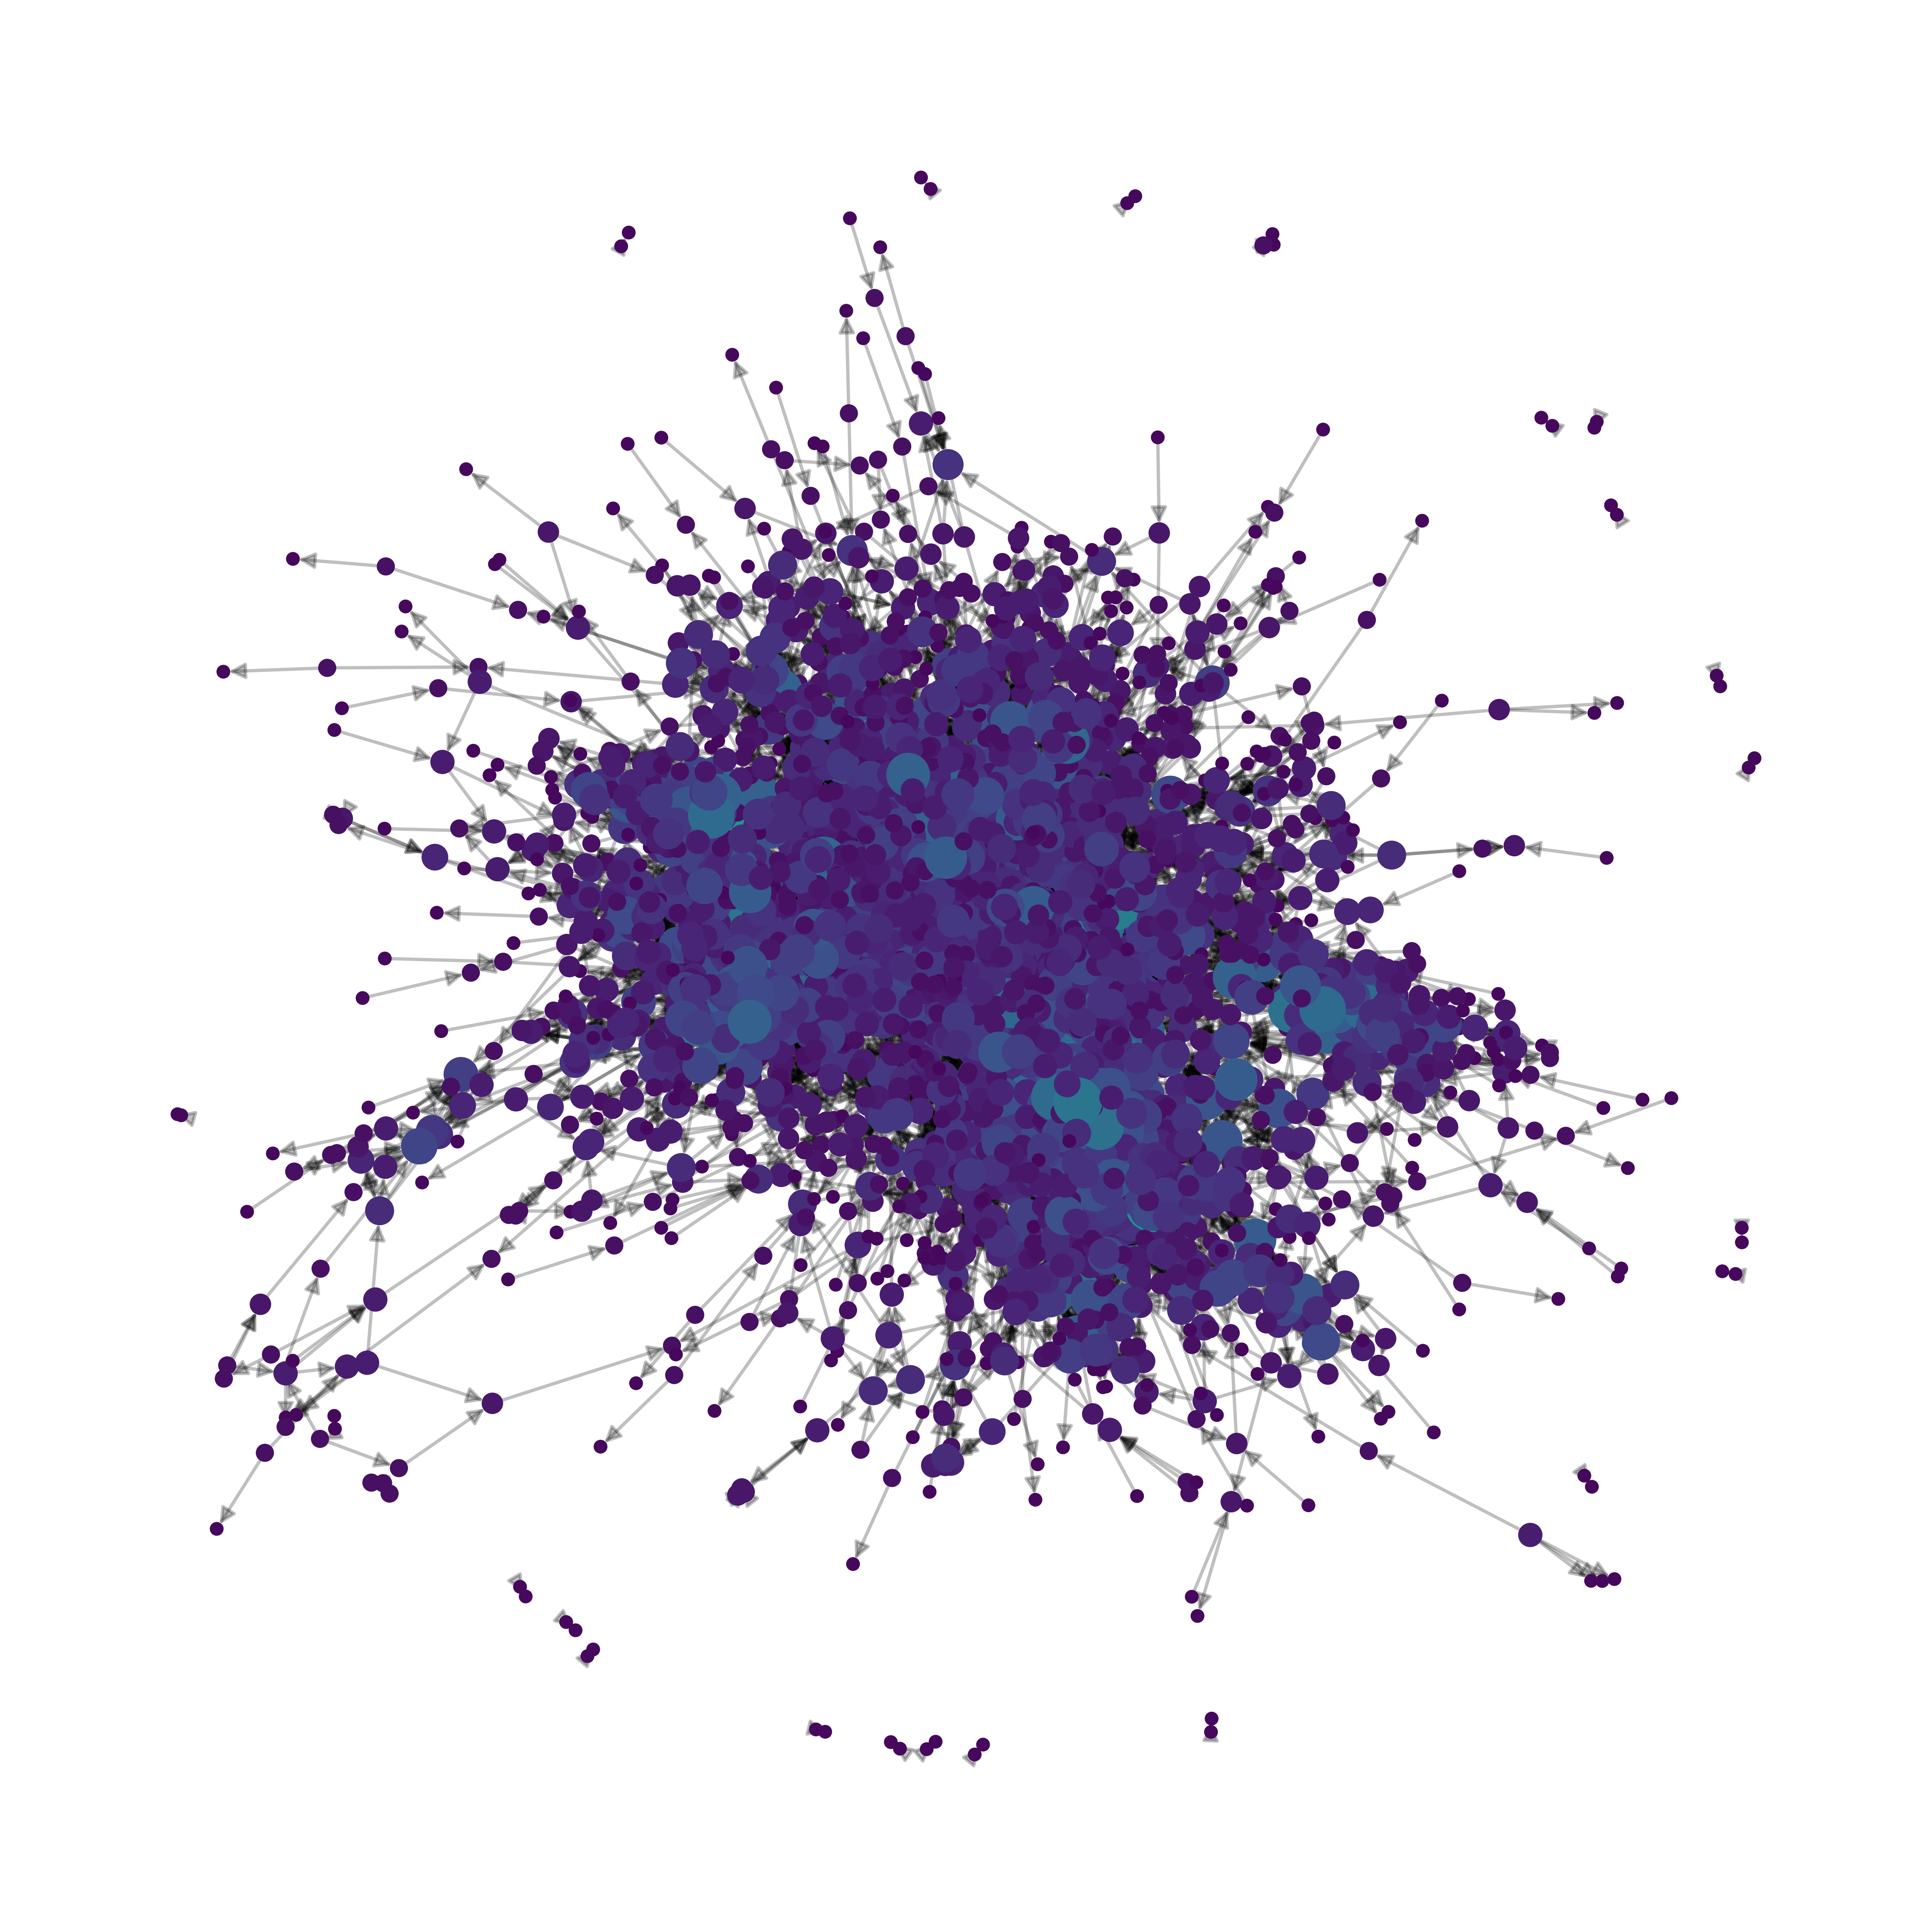

In [37]:
# --- Global Paths (Original unmodified data) ---
# These point to the *source* of the clean data, not the iteration-specific validation data.
DATA_DIR = "data"
ORIGINAL_CLEAN_META_PATH = os.path.join(DATA_DIR, "citation", "clean_meta.csv")
ORIGINAL_CLEAN_EDGES_PATH = os.path.join(DATA_DIR, "citation", "clean_edges.csv")
ORIGINAL_TOPICS_JSON_PATH = os.path.join(DATA_DIR, "Topics and conceptes.JSON")

# --- Helper Functions (copied and potentially modified for iteration-specific paths)---
# These are copies of functions from the original steps, adjusted to accept paths.
# This avoids modifying the original step cells directly.

def load_data_iter(clean_meta_path, clean_edges_path, topics_json_path):
    print("Loading data files...")
    clean_meta_df = pd.read_csv(clean_meta_path)
    print(f"Loaded {os.path.basename(clean_meta_path)}: {len(clean_meta_df)} rows")
    clean_edges_df = pd.read_csv(clean_edges_path)
    print(f"Loaded {os.path.basename(clean_edges_path)}: {len(clean_edges_df)} rows")
    with open(topics_json_path, 'r', encoding='utf-8') as f:
        topics_concepts = json.load(f)
    print(f"Loaded topics and concepts: {len(topics_concepts)} topics")
    return clean_meta_df, clean_edges_df, topics_concepts

def save_and_sort_validation_files(original_nodes_df: pd.DataFrame, synthetic_nodes: List[Dict], original_edges_df: pd.DataFrame, synthetic_edges: List[Dict],
                                   VALIDATION_NODES_PATH: str, VALIDATION_EDGES_PATH: str):
    """Merges original and synthetic data, sorts both the node and edge files by ID, and saves them."""
    print("\nMerging, Sorting, and Saving validation files...")

    # 1. NODES: Merge, Sort, and Save (Still sorted by ID)
    synthetic_nodes_df = pd.DataFrame(synthetic_nodes)
    if not synthetic_nodes_df.empty:
        synthetic_nodes_df = synthetic_nodes_df[original_nodes_df.columns]
        combined_nodes_df = pd.concat([original_nodes_df, synthetic_nodes_df], ignore_index=True)
    else:
        combined_nodes_df = original_nodes_df.copy()
    combined_nodes_df = combined_nodes_df.sort_values(by='id').reset_index(drop=True)
    combined_nodes_df.to_csv(VALIDATION_NODES_PATH, index=False)
    print(f"Saved {VALIDATION_NODES_PATH} (N={len(combined_nodes_df)}) - **Sorted by ID**")


    # 2. EDGES: Merge, Sort, and Save (Still sorted by Source/Target ID)
    synthetic_edges_df = pd.DataFrame(synthetic_edges)
    if not synthetic_edges_df.empty:
        synthetic_edges_df = synthetic_edges_df[original_edges_df.columns]
        combined_edges_df = pd.concat([original_edges_df, synthetic_edges_df], ignore_index=True)
    else:
        combined_edges_df = original_edges_df.copy()

    src_col = original_edges_df.columns[0]
    dst_col = original_edges_df.columns[1]

    combined_edges_df = combined_edges_df.sort_values(by=[src_col, dst_col]).reset_index(drop=True)
    combined_edges_df.to_csv(VALIDATION_EDGES_PATH, index=False)
    print(f"Saved {VALIDATION_EDGES_PATH} (N={len(combined_edges_df)}) - **Sorted by Source/Target ID**")

    return combined_nodes_df, combined_edges_df

def calculate_network_parameters(clean_meta_df: pd.DataFrame, clean_edges_df: pd.DataFrame):
    print("\nCalculating network parameters...")
    original_nodes = len(clean_meta_df)
    new_nodes_total = math.floor(original_nodes * 0.1)
    original_edges = len(clean_edges_df)
    new_edges_total = math.floor(original_edges * 0.3)
    return new_nodes_total, new_edges_total

def calculate_year_range(clean_meta_df: pd.DataFrame):
    years = pd.to_numeric(clean_meta_df['year'], errors='coerce')
    valid_years = years.dropna()
    if len(valid_years) == 0:
        raise ValueError("No valid years found in clean_meta.csv")
    min_year = int(valid_years.min()) + 1
    max_year = int(valid_years.max()) - 1
    return min_year, max_year

def calculate_max_concepts(clean_meta_df: pd.DataFrame) -> int:
    concept_lengths = clean_meta_df['concepts'].fillna('').apply(lambda x: len(x.split(';')) if x else 0)
    max_concepts = max(1, concept_lengths.max())
    return int(max_concepts)

def calculate_nodes_per_topic(new_nodes_total: int, num_topics: int):
    nodes_per_topic = new_nodes_total // num_topics
    return nodes_per_topic

def calculate_edges_per_node(new_edges_total: int, new_nodes_total: int):
    if new_nodes_total == 0:
        edges_per_node = 0
    else:
        edges_per_node = math.floor(new_edges_total / new_nodes_total)
    return edges_per_node

def select_random_concepts(topic_concepts: List[str], num_concepts: int) -> List[str]:
    if len(topic_concepts) <= num_concepts:
        return topic_concepts.copy()
    return random.sample(topic_concepts, num_concepts)

def create_synthetic_nodes(topics_concepts: Dict, nodes_per_topic: int, min_year: int, max_year: int, max_concepts: int, start_id: int = 1):
    print("\nCreating synthetic nodes...")

    synthetic_nodes = []
    current_id = start_id
    for topic, concepts_list in topics_concepts.items():
        for _ in range(nodes_per_topic):
            node_id = f"F{current_id:010d}"
            num_concepts = random.randint(1, max_concepts)
            selected_concepts = select_random_concepts(concepts_list, num_concepts)
            concepts_str = ';'.join([f"'{concept}'" for concept in selected_concepts])
            year = random.randint(min_year, max_year)
            node = {
                'id': node_id,
                'title': f"Synthetic Paper {current_id}",
                'year': year,
                'concepts': concepts_str,
                'primary_topic': topic
            }
            synthetic_nodes.append(node)
            current_id += 1
    print(f"Created {len(synthetic_nodes)} synthetic nodes")
    return synthetic_nodes

def get_valid_citation_targets(clean_meta_df: pd.DataFrame, citing_year: int) -> List[str]:
    clean_meta_df_copy = clean_meta_df.copy()
    clean_meta_df_copy['year_numeric'] = pd.to_numeric(clean_meta_df_copy['year'], errors='coerce')
    valid_papers = clean_meta_df_copy[clean_meta_df_copy['year_numeric'] < citing_year]
    return valid_papers['id'].tolist()

def create_synthetic_edges(synthetic_nodes: List[Dict], clean_meta_df: pd.DataFrame, edges_per_node: int):
    """
    Create synthetic edges where the synthetic node **only cites** an older original (real) node.

    Current Constraints Enforced:
    1. Synthetic nodes only CITE (they are never cited).
    2. Citation year validity: synthetic_year > original_cited_year.
    3. An original node CAN be cited by multiple different synthetic nodes.
    4. An original node CANNOT be cited more than once by the SAME synthetic node (unique edges only).
    """
    print("\nCreating synthetic edges (Synthetic Nodes only CITE)...")

    synthetic_edges = []

    # Cache for valid original nodes that can be cited by the synthetic paper (older papers)
    # Key: synthetic_year, Value: list of valid target IDs
    citation_targets_cache = {}

    for node in synthetic_nodes:
        synthetic_id = node['id']
        synthetic_year = node['year']

        # Determine valid citation targets (Original nodes published strictly before synthetic_year)
        if synthetic_year not in citation_targets_cache:
            # This logic ensures chronological validity: original_cited_year < synthetic_year
            citation_targets_cache[synthetic_year] = get_valid_citation_targets(clean_meta_df, synthetic_year)

        valid_citation_targets = citation_targets_cache[synthetic_year]

        # TRACKER FOR CONSTRAINT #4: Ensures no duplicate (synthetic_id, cited_id) pairs for THIS node.
        connected_original_nodes = set()

        # --- Create 'Cites' Edges Only (Synthetic Node CITES Older Original Node) ---
        for _ in range(edges_per_node):

            # Filter for papers that are valid targets (chronologically older)
            # AND haven't been connected to THIS synthetic node yet.
            available_targets = [
                target_id for target_id in valid_citation_targets
                if target_id not in connected_original_nodes
            ]

            if available_targets:
                # Randomly select ONE original paper to cite
                cited_id = random.choice(available_targets)
                edge = {
                    'cited': cited_id,          # Original node is cited
                    'cites': synthetic_id       # Synthetic node does the citing
                }
                synthetic_edges.append(edge)

                # UPDATE TRACKER: Prevent this original node from being cited again by this specific synthetic node
                connected_original_nodes.add(cited_id)
            # else: Cannot create a unique 'cites' edge for this iteration.

    print(f"Created {len(synthetic_edges)} synthetic edges")
    return synthetic_edges


def create_validation_id2idx(final_edges_df: pd.DataFrame, VALIDATION_NODES_PATH: str, VALIDATION_EDGES_PATH: str, VALIDATION_ID2IDX_PATH: str) :
    """
    Creates an ID-to-Index mapping by iterating through the sorted final_edges_df
    and assigning an index based on the order of first appearance.
    """
    print("\nCreating validation_id2idx.json...")

    # The column names are assumed to be 'cited' (source) and 'cites' (target)
    src_col = final_edges_df.columns[0]
    dst_col = final_edges_df.columns[1]

    # Use a list to store IDs in order of first appearance
    ordered_ids = []
    # Use a set to track IDs already added to avoid duplicates
    seen_ids = set()

    # Iterate over the sorted edges DataFrame
    # Since it is sorted by cited then cites, the iteration will naturally produce
    # the desired grouped order (all IDs related to W1001370459, then W1005007408, etc.)
    for _, row in final_edges_df.iterrows():
        source_id = str(row[src_col])
        target_id = str(row[dst_col])

        # 1. Add Source ID if not seen
        if source_id not in seen_ids:
            seen_ids.add(source_id)
            ordered_ids.append(source_id)

        # 2. Add Target ID if not seen
        if target_id not in seen_ids:
            seen_ids.add(target_id)
            ordered_ids.append(target_id)

    # Create the mapping: ID to Index (based on order of first appearance)
    id2idx = {idv: i for i, idv in enumerate(ordered_ids)}

    # Check for missing nodes (nodes in meta but not in edges, if any)
    # The previous step's node filtering *should* ensure this is zero, but just in case.
    try:
        validation_nodes_df = pd.read_csv(VALIDATION_NODES_PATH, usecols=['id'])
        all_nodes_in_file = set(validation_nodes_df['id'].astype(str).tolist())
        missing_nodes = all_nodes_in_file - seen_ids

        # Add any isolated nodes (if they exist) to the end of the mapping
        # This will ensure all nodes in the graph have an index.
        if missing_nodes:
            print(f"Warning: Found {len(missing_nodes)} isolated nodes in {VALIDATION_NODES_PATH} not present in {VALIDATION_EDGES_PATH}. Appending them to id2idx.")
            isolated_ids_sorted = sorted(list(missing_nodes))
            current_index = len(id2idx)
            for iso_id in isolated_ids_sorted:
                id2idx[iso_id] = current_index
                current_index += 1
            ordered_ids.extend(isolated_ids_sorted)
    except FileNotFoundError:
        print(f"Warning: {VALIDATION_NODES_PATH} not found. Skipping check for isolated nodes.")
    # Save the mapping to a JSON file
    with open(VALIDATION_ID2IDX_PATH, "w", encoding="utf-8") as f:
        json.dump(id2idx, f, ensure_ascii=False, indent=2)
    print(f"Saved {VALIDATION_ID2IDX_PATH} (N={len(ordered_ids)}) - **Keys ordered by appearance in edges**")
    return id2idx

# --- Plotting helper to save instead of show ---
def save_plot(fig, conf, filename_suffix):
    save_dir = os.path.join(conf.log_dir, 'plots')
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'run_{conf.iteration_num}_{filename_suffix}.png')
    fig.savefig(save_path, bbox_inches='tight')
    plt.close(fig) # Close the figure to free memory


# --- Main function to run a single iteration of the pipeline ---
def run_single_iteration(iteration_num: int):
    print(f"\n{'='*50}\nStarting Run {iteration_num+1}/{k}\n{'='*50}")

    # --- Configuration for this iteration ---
    conf = OmegaConf.load('config.yaml')
    # Assign iteration_num to conf for use in plotting filenames
    conf.iteration_num = iteration_num + 1

    # Create iteration-specific data and log directories
    conf.data_dir = os.path.join(DATA_DIR, f'citation_run_{conf.iteration_num}')
    os.makedirs(conf.data_dir, exist_ok=True)
    # Corrected conf.log_dir to include dynamics and model for consistent pathing
    conf.log_dir = os.path.join('logs', f'citation_run_{conf.iteration_num}', f'l{conf.lookback}_h{conf.horizon}', conf.dynamics, conf.model)
    os.makedirs(conf.log_dir, exist_ok=True)

    set_cpu_num(conf.cpu_num)
    seed_everything(conf.seed + iteration_num) # Vary seed slightly for different runs
    print(f"Data directory for this run: {conf.data_dir}")
    print(f"Log directory for this run: {conf.log_dir}")

    # --- STEP 0: Synthetic Citation Network Generator ---
    print("\n" + "="*50 + "\nSTEP 0: Synthetic Citation Network Generator (Iteration-specific)\n" + "="*50)

    # Define iteration-specific paths for validation files
    VALIDATION_NODES_PATH_CURRENT = os.path.join(conf.data_dir, "validation_nodes.csv")
    VALIDATION_EDGES_PATH_CURRENT = os.path.join(conf.data_dir, "validation_edges.csv")
    VALIDATION_ID2IDX_PATH_CURRENT = os.path.join(conf.data_dir, "validation_id2idx.json")

    # Load original clean data (from original data/citation dir)
    original_clean_meta_df, original_clean_edges_df, topics_concepts = load_data_iter(
        ORIGINAL_CLEAN_META_PATH,
        ORIGINAL_CLEAN_EDGES_PATH,
        ORIGINAL_TOPICS_JSON_PATH
    )

    # Apply pre-cleaning logic to original graph data (function from `lPaxKDOtJ2NX`)
    clean_edges_df_processed, final_original_node_ids = clean_citation_graph_data(original_clean_meta_df, original_clean_edges_df)
    original_nodes_set = set(final_original_node_ids)
    clean_meta_df_processed = original_clean_meta_df[original_clean_meta_df['id'].isin(original_nodes_set)].copy()

    # Calculate network parameters
    new_nodes_total, new_edges_total = calculate_network_parameters(clean_meta_df_processed, clean_edges_df_processed)
    min_year, max_year = calculate_year_range(clean_meta_df_processed)
    max_concepts = calculate_max_concepts(clean_meta_df_processed)
    num_topics = len(topics_concepts)
    nodes_per_topic = calculate_nodes_per_topic(new_nodes_total, num_topics)
    edges_per_node = calculate_edges_per_node(new_edges_total, new_nodes_total)

    synthetic_nodes = create_synthetic_nodes(
        topics_concepts=topics_concepts,
        nodes_per_topic=nodes_per_topic,
        min_year=min_year,
        max_year=max_year,
        max_concepts=max_concepts
    )

    synthetic_edges = create_synthetic_edges(
        synthetic_nodes=synthetic_nodes,
        clean_meta_df=clean_meta_df_processed,
        edges_per_node=edges_per_node
    )

    # Create validation files for this iteration
    validation_nodes_df, validation_edges_df = save_and_sort_validation_files(
      original_nodes_df=clean_meta_df_processed, synthetic_nodes=synthetic_nodes,
      original_edges_df=clean_edges_df_processed, synthetic_edges=synthetic_edges,
      VALIDATION_NODES_PATH=VALIDATION_NODES_PATH_CURRENT, VALIDATION_EDGES_PATH=VALIDATION_EDGES_PATH_CURRENT
  )


    validation_id2idx = create_validation_id2idx(
        validation_edges_df, VALIDATION_NODES_PATH_CURRENT, VALIDATION_EDGES_PATH_CURRENT, VALIDATION_ID2IDX_PATH_CURRENT
    )
    print(f"Synthetic Network Generation for Run {conf.iteration_num} Complete.")

    # --- STEP 1: Building Citation Network ---
    print("\n" + "="*50 + "\nSTEP 1: Building Citation Network\n" + "="*50)
    # The NetworkSimulator itself relies on conf.data_dir to find validation_edges.csv
    simulator = NetworkSimulator(args=conf)
    network, adj_matrix = simulator.buildNetwork() # This will use data_dir to find validation_edges.csv
    conf.node_num = network.number_of_nodes() # Update conf.node_num for the current graph
    # Draw graph - saving to iteration-specific path
    drawGraph(network, layout='spring', filter='random', threshold=0.5, out_path=os.path.join(conf.data_dir, 'graph.png'))
    print(f"Graph visualization saved to: {os.path.join(conf.data_dir, 'graph.png')}")


    # --- STEP 1.5: Update csv files ---
    print("\n" + "="*50 + "\nSTEP 1.5: Update csv files\n" + "="*50)
    build_updated_clean_files(conf.data_dir)


    # --- STEP 2: Creating Citation Dynamics ---
    print("\n" + "="*50 + "\nSTEP 2: Creating Citation Dynamics\n" + "="*50)
    simulator.getSimTraj() # Uses conf.data_dir for dynamics.npz


    # --- STEP 3: Preparing Datasets ---
    print("\n" + "="*50 + "\nSTEP 3: Preparing Datasets\n" + "="*50)
    train_dataset = CitationDataset(conf, mode='train')
    val_dataset = CitationDataset(conf, mode='val')
    test_dataset = CitationDataset(conf, mode='test')
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")


    # --- STEP 4: Training DiskNet Model ---
    print("\n" + "="*50 + "\nSTEP 4: Training DiskNet Model\n" + "="*50)
    model = DiskNet(conf) # Initialize DiskNet without initial adjacency
    print_model_summary(model)

    model_path_to_load_for_test = None
    existing_pretrained_model_path = "data/model_refine.pt" # Check in 'data' folder

    if os.path.exists(existing_pretrained_model_path):
        print(f"Pre-trained model found at {existing_pretrained_model_path}. Skipping training for all iterations.")
        model_path_to_load_for_test = existing_pretrained_model_path
    elif iteration_num == 0: # Only train on the first iteration if no existing model
        try:
            # Pass initial graph properties to model.fit for training
            model.fit(train_dataset.getLoader(), val_dataset.getLoader(), adj_matrix, conf.node_num, conf.data_dir)
            # After training the first model, save its path for subsequent runs
            model_path_to_load_for_test = os.path.join(conf.log_dir, 'model_refine.pt')
            if not os.path.exists(model_path_to_load_for_test):
                model_path_to_load_for_test = os.path.join(conf.log_dir, 'model.pt')
        except Exception as e:
            print(f"An error occurred during model training for Run {conf.iteration_num}: {e}")
            import traceback
            traceback.print_exc()
            return # Stop this iteration
    else: # Subsequent iterations (if no pre-existing model found)
        print(f"Skipping training for Run {conf.iteration_num} as k > 1 and it's not the first iteration.")
        # Dynamically construct the path to the model from the first run's log directory
        first_run_log_base = os.path.join('logs', 'citation_run_1', f'l{conf.lookback}_h{conf.horizon}')
        first_run_model_dir = os.path.join(first_run_log_base, conf.dynamics, conf.model)
        model_path_to_load_for_test = os.path.join(first_run_model_dir, 'model_refine.pt')
        if not os.path.exists(model_path_to_load_for_test):
            model_path_to_load_for_test = os.path.join(first_run_model_dir, 'model.pt')

        if not os.path.exists(model_path_to_load_for_test):
            raise FileNotFoundError(f"Model from first iteration not found at {model_path_to_load_for_test}. Cannot skip training.")


    # --- STEP 5: Testing Model ---
    print("\n" + "="*50 + "\nSTEP 5: Testing Model\n" + "="*50)
    # Pass the dynamically determined model path and current graph properties to the test function
    if model_path_to_load_for_test is None:
        raise RuntimeError("model_path_to_load_for_test was not set. This should not happen.")
    model.test(test_dataset.getLoader(), adj_matrix, conf.node_num, conf.data_dir, load_model_from_path=model_path_to_load_for_test)
    results_path = f'{conf.log_dir}/result.npz'
    results = np.load(results_path)
    predicted_dynamics = results['predict']
    actual_dynamics = results['ground_truth']
    print(f"Prediction shape: {predicted_dynamics.shape}")
    print(f"Ground truth shape: {actual_dynamics.shape}")


    # --- STEP 6: Anomaly Detection ---
    print("\n" + "="*50 + "\nSTEP 6: Anomaly Detection\n" + "="*50)
    detector = CitationAnomalyDetector(contamination=0.1)
    deviation_scores, anomaly_labels = detector.detect_anomalies(predicted_dynamics, actual_dynamics)
    n_anomalies = np.sum(anomaly_labels == -1)
    anomalous_indices = np.where(anomaly_labels == -1)[0]
    top_anomalies_indices = np.argsort(np.abs(deviation_scores))[-10:]
    top_anomalies = top_anomalies_indices[::-1]

    anomaly_results_path = f'{conf.log_dir}/anomaly_results.npz'
    np.savez(anomaly_results_path,
              deviation_scores=deviation_scores,
              anomaly_labels=anomaly_labels,
              anomalous_nodes=anomalous_indices,
              top_anomalies=top_anomalies)
    print(f"Anomaly detection results saved to: {anomaly_results_path}")

    create_anomaly_report(conf, network, deviation_scores, anomaly_labels, anomalous_indices)


    # --- STEP 7: Compiling Per-Year Anomaly Report ---
    print("\n" + "="*50 + "\nSTEP 7: Compiling Per-Year Anomaly Report\n" + "="*50)

    num_test_samples = predicted_dynamics.shape[0]
    num_nodes = predicted_dynamics.shape[2]
    df_report = pd.DataFrame({'Node ID': np.arange(num_nodes)})

    for i in range(num_test_samples):
        pred_for_year_i = predicted_dynamics[i, :, :, :]
        actual_for_year_i = actual_dynamics[i, :, :, :]
        pred_for_year_i_batched = pred_for_year_i[np.newaxis, :, :, :]
        actual_for_year_i_batched = actual_for_year_i[np.newaxis, :, :, :]

        deviation_scores_i, anomaly_labels_i = detector.detect_anomalies(
            pred_for_year_i_batched, actual_for_year_i_batched
        )
        is_anomaly_binary_i = (anomaly_labels_i == -1).astype(int)
        df_report[f'Year {i} (Deviation Score)'] = deviation_scores_i
        df_report[f' Year {i} (Is Anomaly)'] = is_anomaly_binary_i

    score_columns = [col for col in df_report.columns if '(Deviation Score)' in col]
    df_report['Mean Deviation Score'] = df_report[score_columns].mean(axis=1)
    anomaly_status_columns = [col for col in df_report.columns if '(Is Anomaly)' in col]
    df_report['Anomaly Status Churn'] = (
        df_report[anomaly_status_columns].max(axis=1) - df_report[anomaly_status_columns].min(axis=1)
    )
    report_csv_path_iter = os.path.join(conf.log_dir, 'anomaly_report_per_year.csv')
    df_report.to_csv(report_csv_path_iter, index=False)
    print(f"Per-year anomaly report generated and saved to: {report_csv_path_iter}")


    # --- STEP 8: Anomaly Detection Evaluation (Per-Year and Aggregate Visualization) ---
    print("\n" + "="*50 + "\nSTEP 8: Anomaly Detection Evaluation (Per-Year and Aggregate Visualization)\n" + "="*50)

    try:
        df_report = pd.read_csv(report_csv_path_iter)
    except FileNotFoundError:
        print(f"Error: Could not find report file at {report_csv_path_iter}. Visualization aborted for Run {conf.iteration_num}.")
        sys.exit()

    score_columns = [col for col in df_report.columns if '(Deviation Score)' in col]
    label_columns = [col for col in df_report.columns if '(Is Anomaly)' in col]
    num_test_samples = len(score_columns)

    if num_test_samples == 0:
        print(f"Error: No 'Deviation Score' columns found in the CSV for Run {conf.iteration_num}. Visualization aborted.")
        sys.exit()

    print(f"\nGenerating plots for {num_test_samples} time windows (Years 0 to {num_test_samples - 1}) for Run {conf.iteration_num}...")

    # ======================================================================
    # 1. PER-YEAR PLOTTING (No change here)
    # ======================================================================
    for i in range(num_test_samples):
        year_score_col = score_columns[i]
        year_label_col = label_columns[i]
        deviation_scores_year = df_report[year_score_col].values
        anomaly_labels_year = np.where(df_report[year_label_col].values == 1, -1, 1)

        # --- Plot 1: Histogram of Deviation Scores for the Year ---
        fig_hist = plt.figure(figsize=(6, 4))
        plt.hist(deviation_scores_year, bins=50, color='skyblue', edgecolor='black')
        plt.title(f"Run {conf.iteration_num} - Year {i}: Distribution of Deviation Scores")
        plt.xlabel("Deviation Score")
        plt.ylabel("Frequency")
        plt.grid(True, alpha=0.5)
        save_plot(fig_hist, conf, f'year_{i}_deviation_scores_hist')
        plt.close(fig_hist) # Close figures to manage memory

        # --- Plot 2: Scatter Plot of Deviation Scores vs. Nodes for the Year ---
        fig_scatter = plt.figure(figsize=(6, 4))
        plt.scatter(
            df_report['Node ID'].values,
            deviation_scores_year,
            c=anomaly_labels_year,
            cmap='coolwarm',
            s=20
        )
        plt.title(f"Run {conf.iteration_num} - Year {i}: Anomaly Detection Results")
        plt.xlabel("Node ID")
        plt.ylabel("Deviation Score")
        plt.colorbar(label='Anomaly Label (-1 = Anomaly, 1 = Normal)')
        plt.grid(True, alpha=0.5)
        save_plot(fig_scatter, conf, f'year_{i}_deviation_scores_scatter')
        plt.close(fig_scatter) # Close figures to manage memory


    # ======================================================================
    # 2. FINAL AGGREGATE PLOTTING (LOGIC CHANGED HERE)
    # ======================================================================

    aggregate_scores = df_report['Mean Deviation Score'].values

    # --- NEW LOGIC: Calculate Dual Thresholds for High and Low Extremity ---
    mean_of_scores = np.mean(aggregate_scores)
    std_of_scores = np.std(aggregate_scores)

    # Use 2 standard deviations for the threshold definition
    std_factor = 1.5
    upper_threshold = mean_of_scores + (std_of_scores * std_factor)
    lower_threshold = mean_of_scores - (std_of_scores * std_factor)

    # Ensure the lower threshold doesn't fall below the minimum observed score
    # (though statistically, the lower bound might be negative if scores can be negative)
    lower_threshold = max(np.min(aggregate_scores), lower_threshold)


    # Create the aggregate labels:
    # Anomaly (-1) if the score is >= Upper_Threshold OR <= Lower_Threshold
    aggregate_labels = np.where(
        (aggregate_scores >= upper_threshold) | (aggregate_scores <= lower_threshold),
        -1, # Extreme Anomaly (High or Low)
        1   # Moderate Mean
    )
    print(f"-> Aggregate Thresholds (Run {conf.iteration_num}): Lower={lower_threshold:.4f}, Upper={upper_threshold:.4f}")

    # --- Plot 3: Histogram of Mean Deviation Scores (with thresholds marked) ---
    fig_agg_hist = plt.figure(figsize=(6, 4))
    plt.hist(aggregate_scores, bins=50, color='coral', edgecolor='black')
    plt.axvline(upper_threshold, color='red', linestyle='--', label=f'Upper Threshold ({upper_threshold:.2f})')
    plt.axvline(lower_threshold, color='blue', linestyle='--', label=f'Lower Threshold ({lower_threshold:.2f})')
    plt.title(f"Run {conf.iteration_num} - AGGREGATE: Mean Deviation Scores")
    plt.xlabel("Mean Deviation Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.5)
    save_plot(fig_agg_hist, conf, f'aggregate_mean_scores_hist')
    plt.close(fig_agg_hist)

    # --- Plot 4: Scatter Plot of Mean Deviation Scores vs. Nodes (with corrected labels) ---
    fig_agg_scatter = plt.figure(figsize=(6, 4))
    scatter = plt.scatter(
        df_report['Node ID'].values,
        aggregate_scores,
        c=aggregate_labels,
        cmap='coolwarm',
        s=20
    )
    plt.title(f"Run {conf.iteration_num} - AGGREGATE: Mean Deviation Scores vs. Nodes")
    plt.xlabel("Node ID")
    plt.ylabel("Mean Deviation Score")
    # Updated label to reflect dual anomaly definition
    plt.colorbar(scatter, label='Mean Score Extremity (-1 = Extreme High/Low Mean, 1 = Moderate Mean)')
    plt.grid(True, alpha=0.5)
    save_plot(fig_agg_scatter, conf, f'aggregate_mean_scores_scatter')
    plt.close(fig_agg_scatter)

    # --- Print top anomalous nodes based on AGGREGATE mean score (LOGIC CHANGED HERE) ---

    anomalous_indices = np.where(aggregate_labels == -1)[0]
    node_ids = df_report['Node ID'].values

    if len(anomalous_indices) > 0:
        # Separate anomalies into High and Low based on the thresholds
        high_anomalies_mask = aggregate_scores[anomalous_indices] >= upper_threshold
        low_anomalies_mask = aggregate_scores[anomalous_indices] <= lower_threshold

        high_anomalies_indices = anomalous_indices[high_anomalies_mask]
        low_anomalies_indices = anomalous_indices[low_anomalies_mask]

        # Sort and take top N for display (e.g., top 5 high, top 5 low)
        N = 5
        top_high_indices_sorted = high_anomalies_indices[np.argsort(aggregate_scores[high_anomalies_indices])[-N:][::-1]]
        top_low_indices_sorted = low_anomalies_indices[np.argsort(aggregate_scores[low_anomalies_indices])[:N]]

        top_aggregate_indices_print = np.concatenate((top_high_indices_sorted, top_low_indices_sorted))

        print(f"\nTop EXTREME Nodes (by Mean Deviation Score Magnitude) for Run {conf.iteration_num}:")
        print(" Node ID | Mean Deviation Score | Extremity Type")
        print("-" * 45)

        for idx in top_aggregate_indices_print:
            extremity_type = "HIGH" if aggregate_scores[idx] >= upper_threshold else "LOW"
            print(f" {node_ids[idx]:7d} | {aggregate_scores[idx]:20.6f} | {extremity_type}")
    else:
        print(f"\nNo extreme aggregate anomalies detected based on the {std_factor}-sigma thresholds for Run {conf.iteration_num}.")

    print(f"\n--- Run {conf.iteration_num} Completed! ---")
    print(f"Check results for this run in: {conf.log_dir}/")


# --- Execute the pipeline k times ---
print(f"\n\nStarting {k} iteration(s) of the pipeline...\n")
for i in range(k):
    try:
        run_single_iteration(i)
        gc.collect()
    except Exception as e:
        print(f"An unhandled error occurred during Run {i+1}: {e}")
        import traceback
        traceback.print_exc()
    print(f"\n{'='*50}\nFinished Run {i+1}\n{'='*50}")

print("\nAll requested iterations completed!")

#Analyze

In [38]:
conf = OmegaConf.load('config.yaml')
all_runs_metrics = []

for run_num in range(1, k + 1):
    print(f"\nProcessing Run: {run_num}/{k}")

    base_data_dir = os.path.join("data", f"citation_run_{run_num}")
    base_log_dir = os.path.join("logs", f"citation_run_{run_num}", f"l{conf.lookback}_h{conf.horizon}", "CitationNetwork", "DiskNet")

    report_csv_path = os.path.join(base_log_dir, 'anomaly_report_per_year.csv')
    id2idx_path = os.path.join(base_data_dir, 'updated_id2idx_clean.json')

    print(f"  Report CSV: {report_csv_path}")
    print(f"  ID2IDX JSON: {id2idx_path}")

    try:
        df_report_analysis = pd.read_csv(report_csv_path)

        with open(id2idx_path, 'r', encoding='utf-8') as f:
            id2idx_mapping = json.load(f)

        idx2id_mapping = {v: k_id for k_id, v in id2idx_mapping.items()}
        df_report_analysis['Original ID'] = df_report_analysis['Node ID'].map(idx2id_mapping)

        df_report_analysis['Is Synthetic'] = df_report_analysis['Original ID'].apply(lambda x: str(x).startswith('F'))

        # -----------------------
        # BASIC METRICS
        # -----------------------
        scores = df_report_analysis['Mean Deviation Score'].values
        overall_mean_score = np.mean(scores)
        overall_std_score = np.std(scores)
        overall_max_score = np.max(scores)

        num_synthetic = df_report_analysis['Is Synthetic'].sum()
        num_original = len(df_report_analysis) - num_synthetic
        total_nodes = len(df_report_analysis)

        # Synthetic / Original Distribution
        mean_score_synth = df_report_analysis[df_report_analysis['Is Synthetic']]['Mean Deviation Score'].mean()
        max_score_synth = df_report_analysis[df_report_analysis['Is Synthetic']]['Mean Deviation Score'].max()

        mean_score_orig = df_report_analysis[~df_report_analysis['Is Synthetic']]['Mean Deviation Score'].mean()
        max_score_orig = df_report_analysis[~df_report_analysis['Is Synthetic']]['Mean Deviation Score'].max()

        # -----------------------
        # AGGREGATE ANOMALY FLAG (CORRECTED METRIC STORAGE) 🚀
        # -----------------------
        std_factor = 1 # Fixed standard deviation multiplier

        if len(scores) > 0:
            # Calculate the actual numerical thresholds
            upper_threshold = overall_mean_score + (overall_std_score * std_factor)
            lower_threshold = overall_mean_score - (overall_std_score * std_factor)

            # Flag as anomaly (1) if score is above upper or below lower threshold
            df_report_analysis['Is Aggregate Anomaly'] = np.where(
                (df_report_analysis['Mean Deviation Score'] >= upper_threshold) |
                (df_report_analysis['Mean Deviation Score'] <= lower_threshold),
                1,  # Is an anomaly (either high or low extreme)
                0   # Is not an anomaly
            )
            # Store the actual calculated numerical thresholds
            upper_threshold_used_value = upper_threshold
            lower_threshold_used_value = lower_threshold
        else:
            upper_threshold_used_value = 0
            lower_threshold_used_value = 0
            df_report_analysis['Is Aggregate Anomaly'] = 0

        # -----------------------
        # ANOMALY COUNTS
        # -----------------------
        total_anomalies = df_report_analysis['Is Aggregate Anomaly'].sum()
        total_anomaly_rate = total_anomalies / total_nodes * 100 if total_nodes > 0 else 0

        orig_anomalies = df_report_analysis[~df_report_analysis['Is Synthetic']]['Is Aggregate Anomaly'].sum()
        synth_anomalies = df_report_analysis[df_report_analysis['Is Synthetic']]['Is Aggregate Anomaly'].sum()

        orig_anomaly_rate = orig_anomalies / num_original * 100 if num_original else 0
        synth_anomaly_rate = synth_anomalies / num_synthetic * 100 if num_synthetic else 0

        # -----------------------
        # STORE METRICS
        # -----------------------
        run_metrics = {
            'run_num': run_num,

            # Counts
            'total_nodes': total_nodes,
            'num_original_nodes': num_original,
            'num_synthetic_nodes': num_synthetic,

            # Deviation stats (overall)
            'overall_mean': overall_mean_score,
            'overall_std': overall_std_score,
            'overall_max': overall_max_score,

            # Synthetic stats
            'mean_synthetic': mean_score_synth,
            'max_synthetic': max_score_synth,

            # Original stats
            'mean_original': mean_score_orig,
            'max_original': max_score_orig,

            # Threshold used (Now storing the actual numerical bounds)
            'std_factor_used': std_factor, # Optional: Store the factor used (e.g., 3)
            'upper_threshold_used': upper_threshold_used_value, # <-- NEW
            'lower_threshold_used': lower_threshold_used_value, # <-- NEW

            # Anomalies
            'total_anomalies': total_anomalies,
            'total_anomaly_rate': total_anomaly_rate,
            'orig_anomalies': orig_anomalies,
            'orig_anomaly_rate': orig_anomaly_rate,
            'synth_anomalies': synth_anomalies,
            'synth_anomaly_rate': synth_anomaly_rate
        }

        all_runs_metrics.append(run_metrics)
        print(f"  Metrics collected for Run {run_num}.")

    except Exception as e:
        print(f"  Error processing Run {run_num}: {e}")

print("\nAll runs processed.\n")

df_all_runs = pd.DataFrame(all_runs_metrics)
display(df_all_runs)

# -----------------------
# CROSS–RUN STATISTICS
# -----------------------
if k > 1:
    print("\n=== STATS ACROSS ALL RUNS ===")
    # Drop the run number and the constant std_factor before summarizing
    summary = df_all_runs.drop(columns=['run_num', 'std_factor_used']).agg(['mean', 'min', 'max'])
    display(summary)


Processing Run: 1/1
  Report CSV: logs/citation_run_1/l3_h3/CitationNetwork/DiskNet/anomaly_report_per_year.csv
  ID2IDX JSON: data/citation_run_1/updated_id2idx_clean.json
  Metrics collected for Run 1.

All runs processed.



run_num  total_nodes  num_original_nodes  num_synthetic_nodes  \
0        1         6872                6249                  623   

   overall_mean  overall_std  overall_max  mean_synthetic  max_synthetic  \
0      0.365282     0.261346     3.835098        0.715518       1.489795   

   mean_original  max_original  std_factor_used  upper_threshold_used  \
0       0.330365      3.835098                1              0.626628   

   lower_threshold_used  total_anomalies  total_anomaly_rate  orig_anomalies  \
0              0.103936             1065           15.497672             666   

   orig_anomaly_rate  synth_anomalies  synth_anomaly_rate  
0          10.657705              399           64.044944

In [ ]:
# --- Global Data Lists (Updated: Added 'least' lists back) ---
top_anomalous_original_nodes_data = []      # Will hold TOP EXTREME nodes
top_anomalous_synthetic_nodes_data = []     # Will hold TOP EXTREME nodes
least_anomalous_original_nodes_data = []    # Will hold MOST NORMAL (least extreme) nodes
least_anomalous_synthetic_nodes_data = []   # Will hold MOST NORMAL (least extreme) nodes


# --- Helper Function for Clean Display (Updated for side-by-side display) ---
def create_combined_display_df(df_extreme, df_normal, type_label):

    # Include the Z-Score column in the display for insight
    DATA_COLS = ['node_id', 'year', 'mean_deviation_score', 'z_score', 'incoming_citations', 'outgoing_citations']

    # 1. Create a temporary unique index for each row within each run
    df_extreme['temp_index'] = df_extreme.groupby('run_num').cumcount()
    df_normal['temp_index'] = df_normal.groupby('run_num').cumcount()

    # 2. Set the MultiIndex: (run_num, temp_index) for visual merging on run_num
    df_extreme_display = df_extreme.set_index(['run_num', 'temp_index'])[DATA_COLS]
    df_normal_display = df_normal.set_index(['run_num', 'temp_index'])[DATA_COLS]

    # 3. Rename columns for clarity (Added labels back for side-by-side)
    df_extreme_display.columns = [f'EXTREME {col.replace("_", " ").title()}' for col in DATA_COLS]
    df_normal_display.columns = [f'NORMAL {col.replace("_", " ").title()}' for col in DATA_COLS]

    # 4. Concatenate side-by-side using the MultiIndex
    df_combined = pd.concat(
        [df_extreme_display, df_normal_display],
        axis=1,
        keys=[f'TOP EXTREME', f'MOST NORMAL']
    )

    # 5. Remove the 'temp_index' level and rename the remaining 'run_num' level
    df_combined.index = df_combined.index.droplevel('temp_index')
    df_combined.index.names = ['Run']

    return df_combined


# --- Main Processing Loop ---
for run_num in range(1, k + 1):
    print(f"\n{'='*70}")
    print(f"Analyzing Nodes for Run {run_num}/{k}")
    print(f"{'='*70}")

    # Define paths
    report_csv_path = os.path.join("logs", f"citation_run_{run_num}", f"l{conf.lookback}_h{conf.horizon}", "CitationNetwork", "DiskNet", 'anomaly_report_per_year.csv')
    id2idx_path = os.path.join("data", f"citation_run_{run_num}", 'updated_id2idx_clean.json')
    meta_path = os.path.join("data", f"citation_run_{run_num}", 'updated_clean_meta.csv')
    edges_path = os.path.join("data", f"citation_run_{run_num}", 'updated_clean_edges.csv')

    try:
        # Load data
        df_report = pd.read_csv(report_csv_path)
        with open(id2idx_path, 'r', encoding='utf-8') as f:
            id2idx = json.load(f)
        idx2id = {v: k for k, v in id2idx.items()}

        # Load metadata to get the year
        df_meta = pd.read_csv(meta_path, dtype={'id': str, 'year': 'Int64'})
        id_to_year = df_meta.set_index('id')['year'].to_dict()

        df_report['Original ID'] = df_report['Node ID'].map(idx2id)
        df_report['Is Synthetic'] = df_report['Original ID'].apply(lambda x: str(x).startswith('F'))

        # --- Compute scores and Z-Scores ---
        scores = df_report['Mean Deviation Score'].values

        # Calculate statistics
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        # Z-Score Calculation
        if std_score > 0:
            df_report['z_score'] = (df_report['Mean Deviation Score'] - mean_score) / std_score
            df_report['abs_z_score'] = df_report['z_score'].abs() # Used for sorting EXTREME and NORMAL
        else:
            df_report['z_score'] = 0
            df_report['abs_z_score'] = 0

        # Define the factor (1.5 as requested)
        std_factor = 1

        if len(scores) > 0:
            # Define the Upper and Lower Thresholds based on mean and 1.5 * std
            upper_threshold = mean_score + (std_score * std_factor)
            lower_threshold = mean_score - (std_score * std_factor)

            # Flag as anomaly (1) if score is above upper OR below lower threshold
            df_report['Is Aggregate Anomaly'] = np.where(
                (df_report['Mean Deviation Score'] >= upper_threshold) |
                (df_report['Mean Deviation Score'] <= lower_threshold),
                1,  # Is an anomaly (either high or low extreme)
                0   # Is not an anomaly
            )
        else:
            df_report['Is Aggregate Anomaly'] = 0


        # 1. Identify TOP EXTREME ANOMALIES (Largest abs_z_score)
        top_10_orig = df_report[~df_report['Is Synthetic']].nlargest(10, 'abs_z_score')
        top_10_synth = df_report[df_report['Is Synthetic']].nlargest(10, 'abs_z_score')

        # 2. Identify MOST NORMAL NODES (Smallest abs_z_score) 🎯
        least_10_orig = df_report[~df_report['Is Synthetic']].nsmallest(10, 'abs_z_score')
        least_10_synth = df_report[df_report['Is Synthetic']].nsmallest(10, 'abs_z_score')

        # Load edges
        edges_df = pd.read_csv(edges_path, dtype=str)

        # --- Function to compute incoming and outgoing citations ---
        def compute_in_out_counts(node_id):
            node_id = str(node_id)
            incoming = edges_df[edges_df['cites'] == node_id].shape[0]
            outgoing = edges_df[edges_df['cited'] == node_id].shape[0]
            return incoming, outgoing

        # --- Processing Loop Function ---
        def process_nodes(df_subset, data_list):
            for _, row in df_subset.iterrows():
                original_id = row['Original ID']
                incoming, outgoing = compute_in_out_counts(original_id)

                node_year = id_to_year.get(original_id, pd.NA)

                data_list.append({
                    'run_num': run_num,
                    'node_id': original_id,
                    'year': node_year,
                    'mean_deviation_score': row['Mean Deviation Score'],
                    'z_score': row['z_score'],
                    'abs_z_score': row['abs_z_score'],
                    'incoming_citations': incoming,
                    'outgoing_citations': outgoing
                })

        # Process the extreme and normal nodes
        process_nodes(top_10_orig, top_anomalous_original_nodes_data)
        process_nodes(top_10_synth, top_anomalous_synthetic_nodes_data)
        process_nodes(least_10_orig, least_anomalous_original_nodes_data) # 🎯
        process_nodes(least_10_synth, least_anomalous_synthetic_nodes_data) # 🎯

        print(f"Processed Run {run_num}. Nodes sorted by Absolute Z-Score for extreme and normal.")

    except Exception as e:
        print(f"Error on run {run_num}: {e}")
        traceback.print_exc()


# --- Final DataFrames Prep ---
df_original_extreme = pd.DataFrame(top_anomalous_original_nodes_data)
df_synthetic_extreme = pd.DataFrame(top_anomalous_synthetic_nodes_data)
df_original_normal = pd.DataFrame(least_anomalous_original_nodes_data)
df_synthetic_normal = pd.DataFrame(least_anomalous_synthetic_nodes_data)

# Clean up temporary 'abs_z_score' column from all DataFrames
cols_to_drop = ['abs_z_score']
for df in [df_original_extreme, df_synthetic_extreme, df_original_normal, df_synthetic_normal]:
    if 'abs_z_score' in df.columns:
        df.drop(columns=['abs_z_score'], inplace=True)

# Define columns for display
DATA_COLS = ['node_id', 'year', 'mean_deviation_score', 'z_score', 'incoming_citations', 'outgoing_citations']


# --- Display Tables ---

print("\n" + "="*100)
print("             🔍 Comparative Anomaly Analysis: ORIGINAL NODES (Extreme vs. Normal)")
print("="*100)

df_combined_original = create_combined_display_df(df_original_extreme.copy(), df_original_normal.copy(), "Original")
print("\n⭐ ORIGINAL Nodes: TOP EXTREME (Left) vs. MOST NORMAL (Right) ⭐")
display(df_combined_original)


print("\n" + "="*100)
print("             🧪 Comparative Anomaly Analysis: SYNTHETIC NODES (Extreme vs. Normal)")
print("="*100)

df_combined_synthetic = create_combined_display_df(df_synthetic_extreme.copy(), df_synthetic_normal.copy(), "Synthetic")
print("\n🧪 SYNTHETIC Nodes: TOP EXTREME (Left) vs. MOST NORMAL (Right) 🧪")
display(df_combined_synthetic)


Analyzing Nodes for Run 1/1
Processed Run 1. Nodes sorted by Absolute Z-Score for extreme and normal.

             🔍 Comparative Anomaly Analysis: ORIGINAL NODES (Extreme vs. Normal)

⭐ ORIGINAL Nodes: TOP EXTREME (Left) vs. MOST NORMAL (Right) ⭐


TOP EXTREME                                                            \
    EXTREME Node Id EXTREME Year EXTREME Mean Deviation Score EXTREME Z Score   
Run                                                                             
1       W2939474406         2007                     3.709473       14.493817   
1       W2170551349         2012                     2.728594       10.280866   
1       W2163605009         2017                     2.286827        8.383440   
1       W2194775991         2016                     2.164681        7.858816   
1       W2124985265         2009                     2.038578        7.317193   
1       W2123696077         2011                     1.908421        6.758161   
1       W2103017472         2000                     1.892091        6.688021   
1       W2006165291         2003                     1.780465        6.208581   
1       W2054653365         2010                     1.700086        5.863345   
1       W2103441770         2009                     1.668338        5.726983   

                                                             MOST NORMAL  \
    EXTREME Incoming Citations EXTREME Outgoing Citations NORMAL Node Id   
Run                                                                        
1                           94                          1    W2927511117   
1                           39                          8    W2144998676   
1                          105                          6    W1031578623   
1                           90                         11    W2084461152   
1                           52                          6    W2165869860   
1                           25                         10    W2051782740   
1                           71                         10    W2102213696   
1                           34                          4    W2117087906   
1                           23                          4    W1995622703   
1                           68                          7    W2165698076   

                                                            \
    NORMAL Year NORMAL Mean Deviation Score NORMAL Z Score   
Run                                                          
1          2019                    0.334973       0.000082   
1          2004                    0.334928      -0.000114   
1          2015                    0.334924      -0.000128   
1          2008                    0.334994       0.000172   
1          2015                    0.335016       0.000266   
1          2010                    0.334877      -0.000333   
1          2010                    0.334829      -0.000540   
1          2008                    0.334817      -0.000589   
1          2007                    0.334769      -0.000794   
1          2009                    0.335226       0.001167   

                                                         
    NORMAL Incoming Citations NORMAL Outgoing Citations  
Run                                                      
1                           4                         7  
1                           3                         4  
1                           2                        10  
1                           2                         8  
1                           6                        14  
1                           2                        12  
1                           3                         7  
1                           4                         3  
1                          14                         4  
1                          11                         0


             🧪 Comparative Anomaly Analysis: SYNTHETIC NODES (Extreme vs. Normal)

🧪 SYNTHETIC Nodes: TOP EXTREME (Left) vs. MOST NORMAL (Right) 🧪


TOP EXTREME                                                            \
    EXTREME Node Id EXTREME Year EXTREME Mean Deviation Score EXTREME Z Score   
Run                                                                             
1       F0000000157         2006                     1.478596        4.912027   
1       F0000000130         2012                     1.445990        4.771982   
1       F0000000368         2015                     1.423230        4.674229   
1       F0000000244         2015                     1.420480        4.662416   
1       F0000000241         2014                     1.420159        4.661038   
1       F0000000522         2006                     1.350517        4.361918   
1       F0000000406         2016                     1.350381        4.361338   
1       F0000000350         2006                     1.301207        4.150128   
1       F0000000114         2007                     1.270086        4.016464   
1       F0000000007         2007                     1.257661        3.963094   

                                                             MOST NORMAL  \
    EXTREME Incoming Citations EXTREME Outgoing Citations NORMAL Node Id   
Run                                                                        
1                           11                          0    F0000000170   
1                           11                          0    F0000000237   
1                           11                          0    F0000000024   
1                           11                          0    F0000000521   
1                           11                          0    F0000000041   
1                           11                          0    F0000000245   
1                           11                          0    F0000000036   
1                           11                          0    F0000000360   
1                           11                          0    F0000000592   
1                           11                          0    F0000000584   

                                                            \
    NORMAL Year NORMAL Mean Deviation Score NORMAL Z Score   
Run                                                          
1          2004                    0.333972      -0.004220   
1          2004                    0.333344      -0.006917   
1          2003                    0.337259       0.009898   
1          2002                    0.337521       0.011023   
1          2003                    0.337904       0.012672   
1          2003                    0.331532      -0.014698   
1          2003                    0.339944       0.021433   
1          2003                    0.329297      -0.024297   
1          2003                    0.329076      -0.025248   
1          2003                    0.341295       0.027236   

                                                         
    NORMAL Incoming Citations NORMAL Outgoing Citations  
Run                                                      
1                          11                         0  
1                          11                         0  
1                          11                         0  
1                          11                         0  
1                          11                         0  
1                          11                         0  
1                          11                         0  
1                          11                         0  
1                          11                         0  
1                          11                         0

#download result

In [ ]:
folder1 = "/content/data"
folder2 = "/content/logs"

# Create a zip containing only the two folders
!zip -r fullRun.zip "$folder1" "$folder2"

# Download the zip file
files.download("fullRun.zip")


#upload result and unzip

In [ ]:
path_to_zip_file = 'fullRun.zip'
directory_to_extract_to = os.path.dirname(os.path.abspath(path_to_zip_file))
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

print("Extraction completed.")

Extraction completed.


#Top 5 analyze


             Analyzing and Plotting Top Extreme Nodes Per Run


Processing Run: 1/1
  Identified top 5 extreme nodes for Run 1:
    Node ID: W2939474406, Mean Dev Score: 3.8351, Z-Score: 13.2767
    Node ID: W2170551349, Mean Dev Score: 3.3969, Z-Score: 11.5999
    Node ID: W2194775991, Mean Dev Score: 2.8088, Z-Score: 9.3498
    Node ID: W2163605009, Mean Dev Score: 2.5314, Z-Score: 8.2884
    Node ID: W2141458291, Mean Dev Score: 2.2043, Z-Score: 7.0368


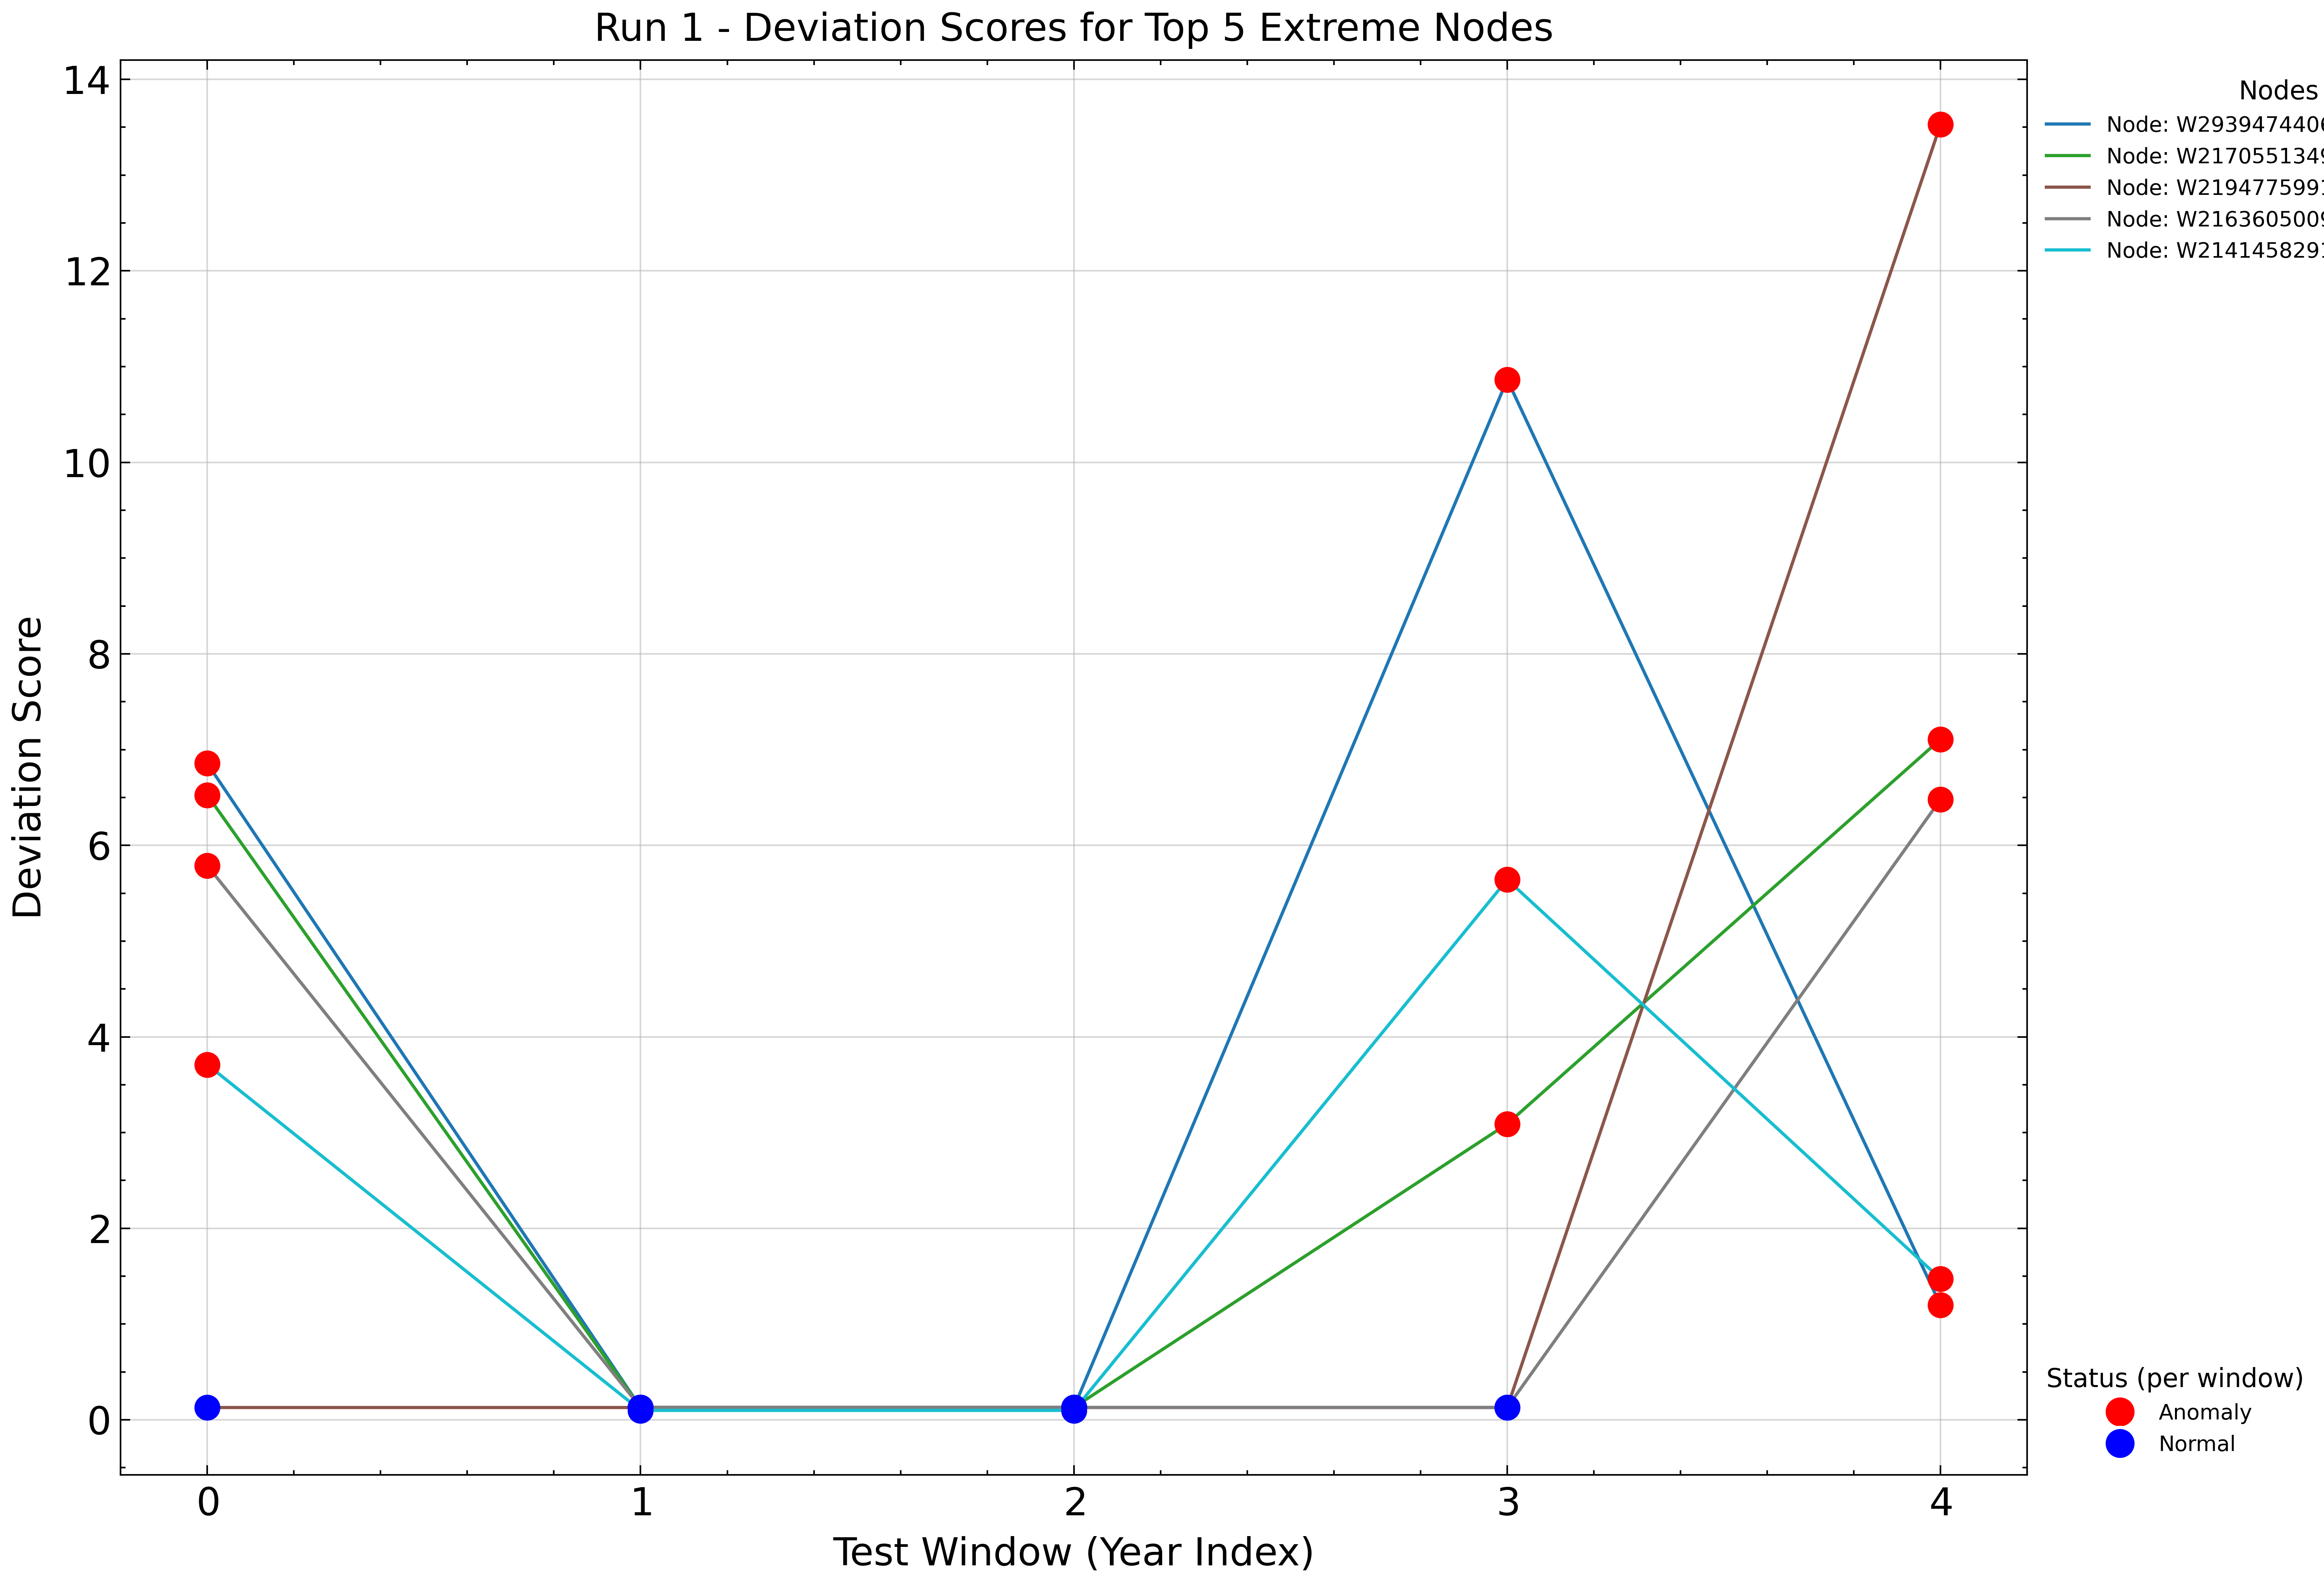

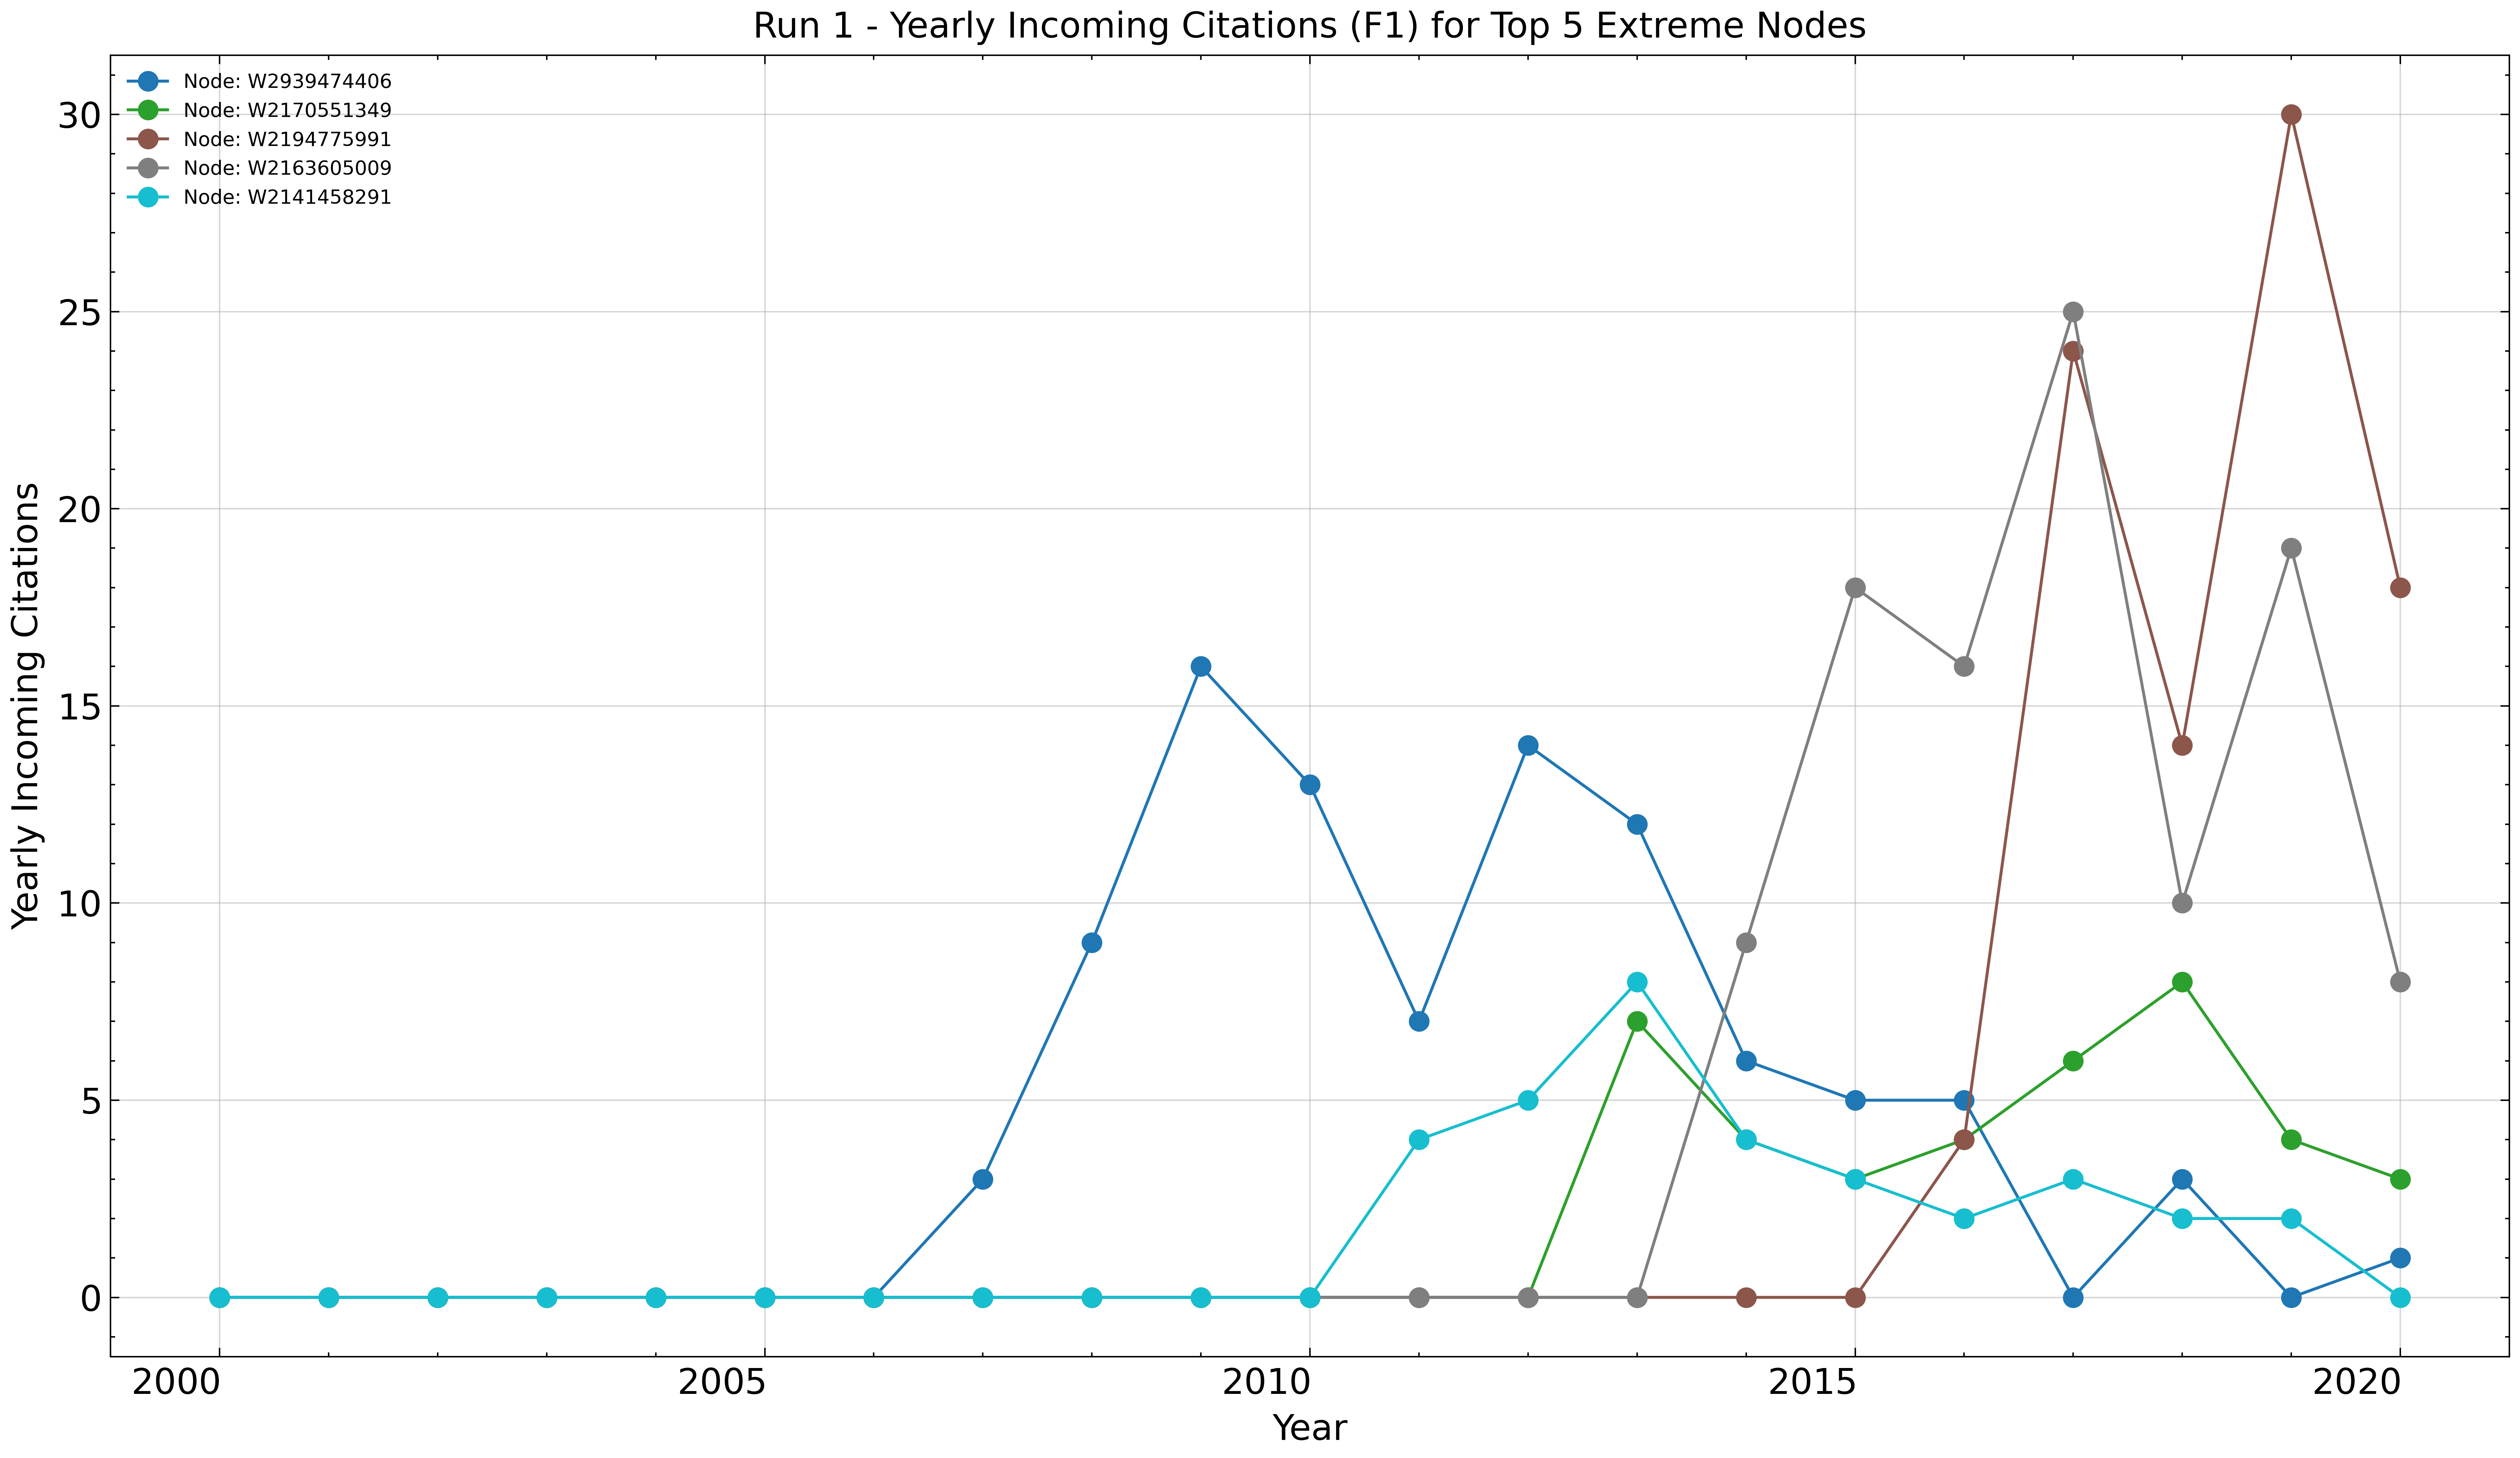

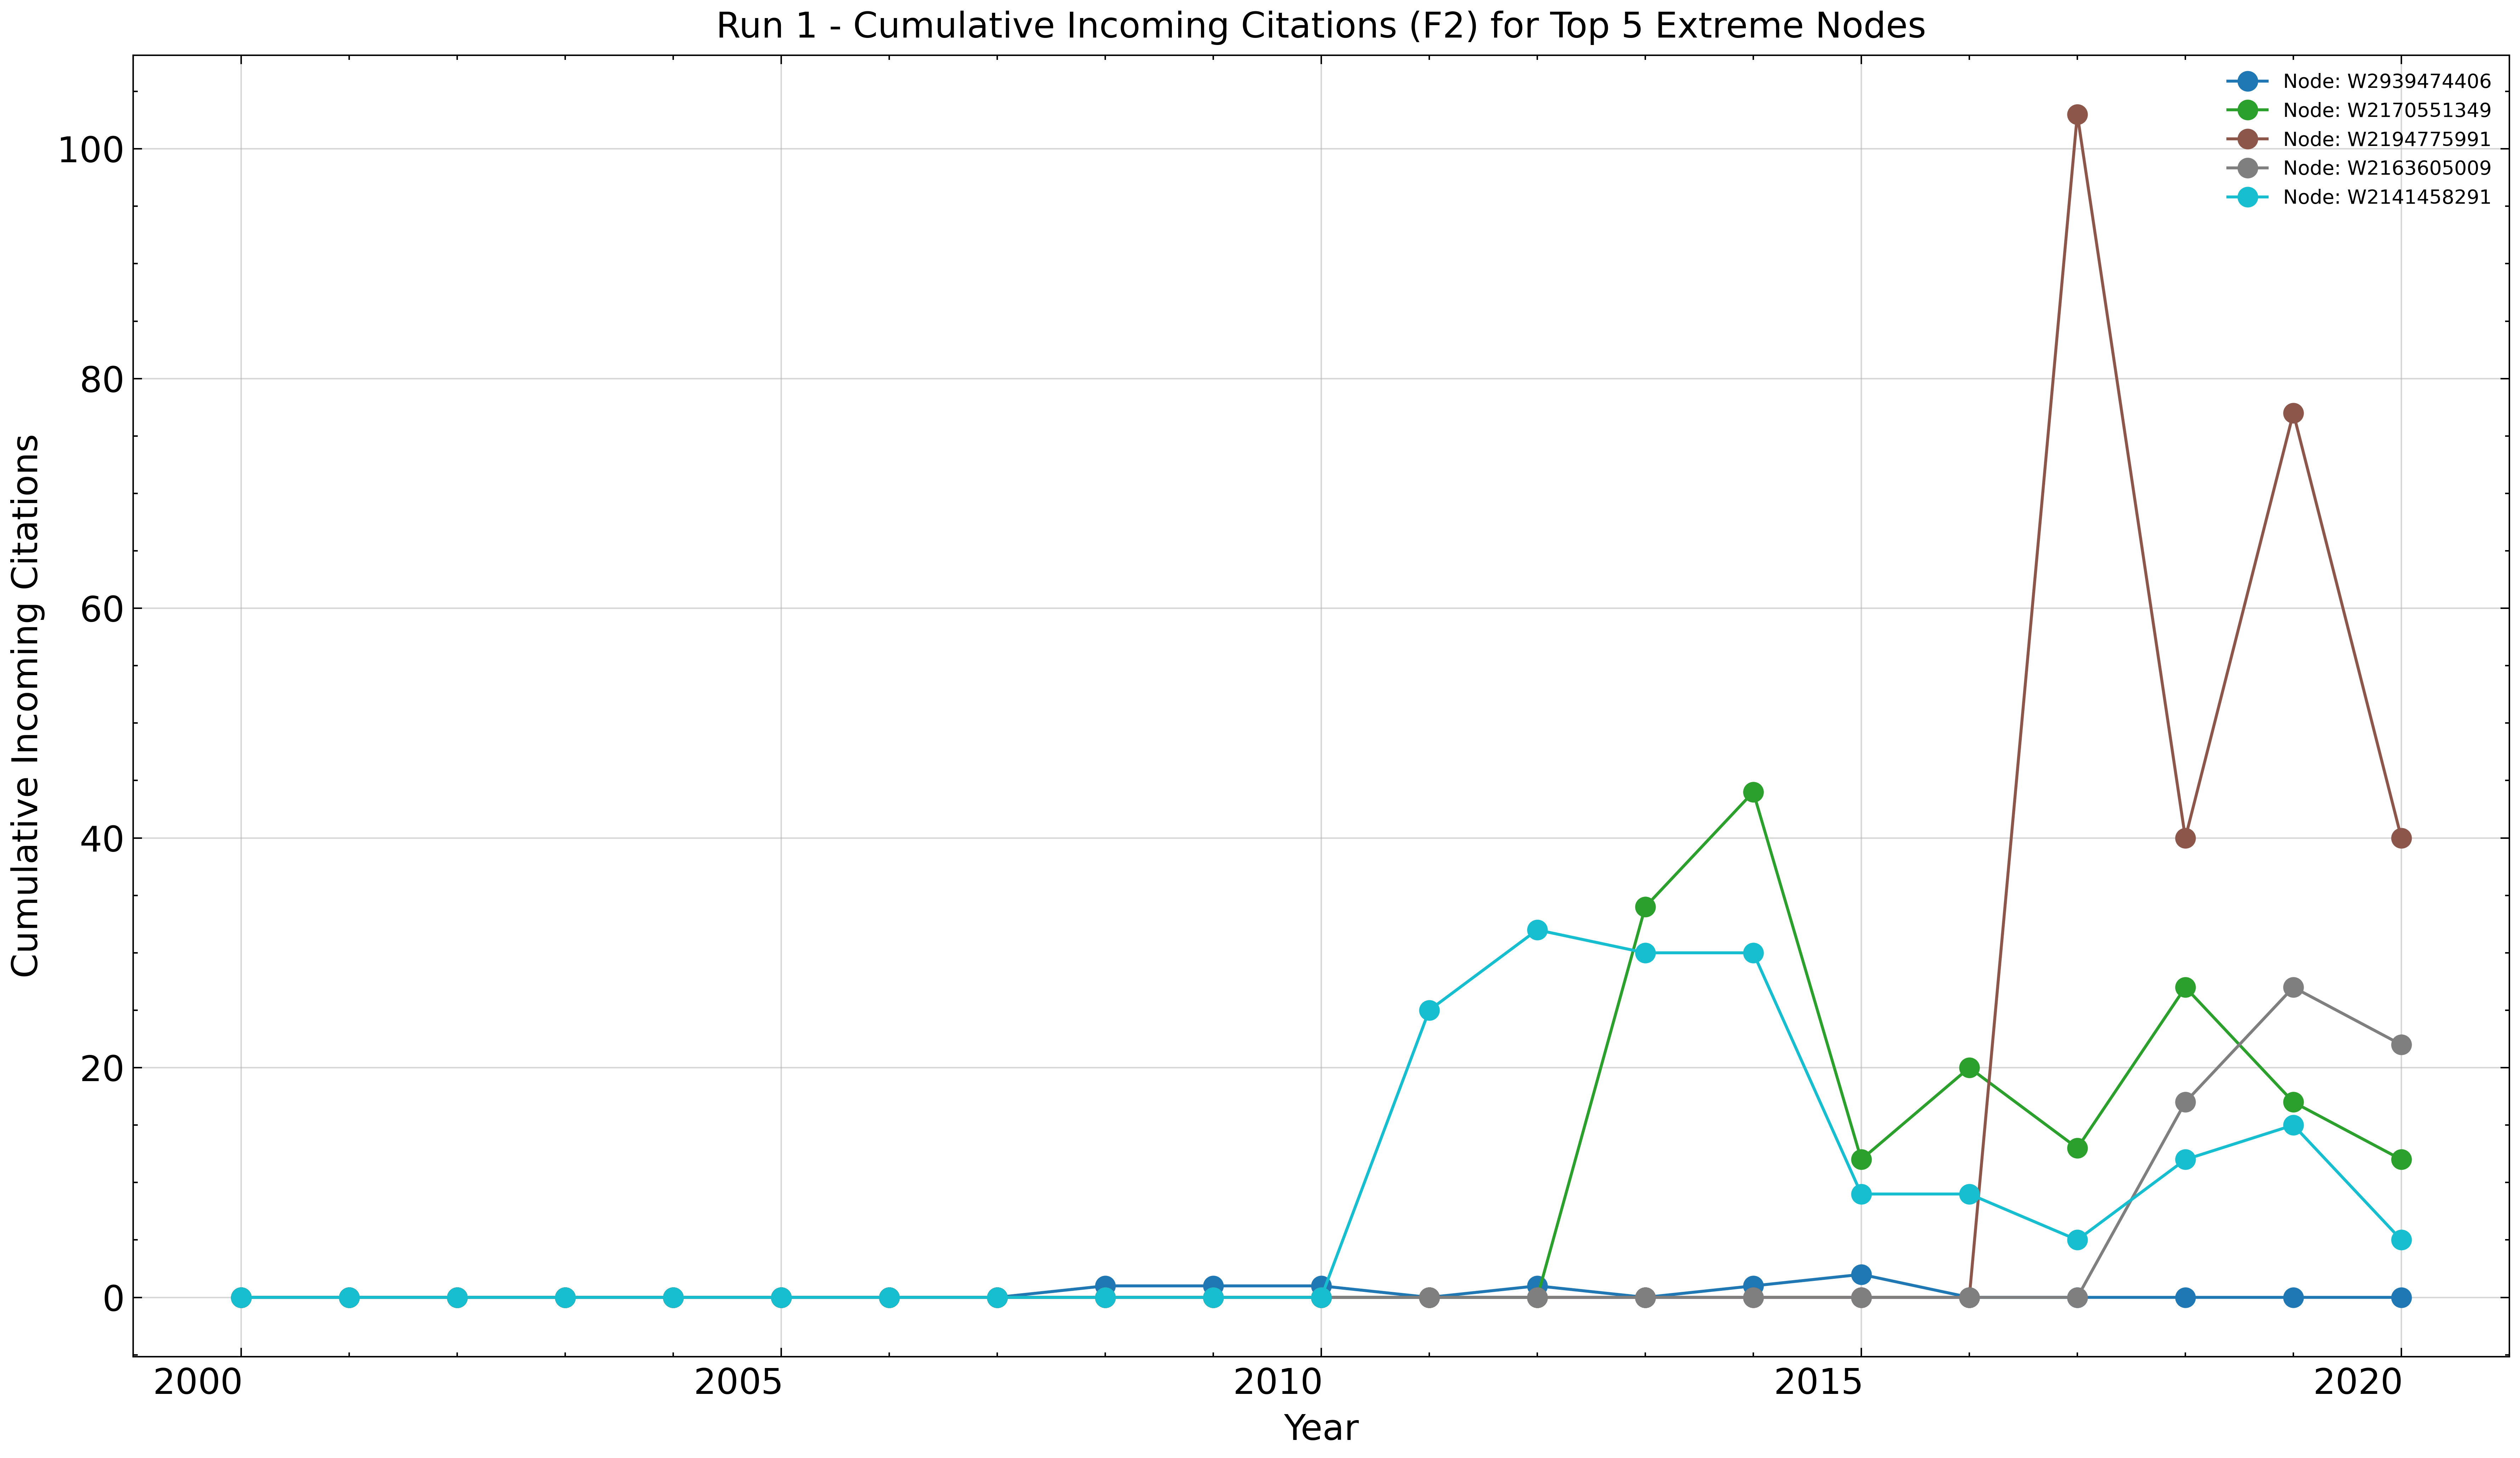

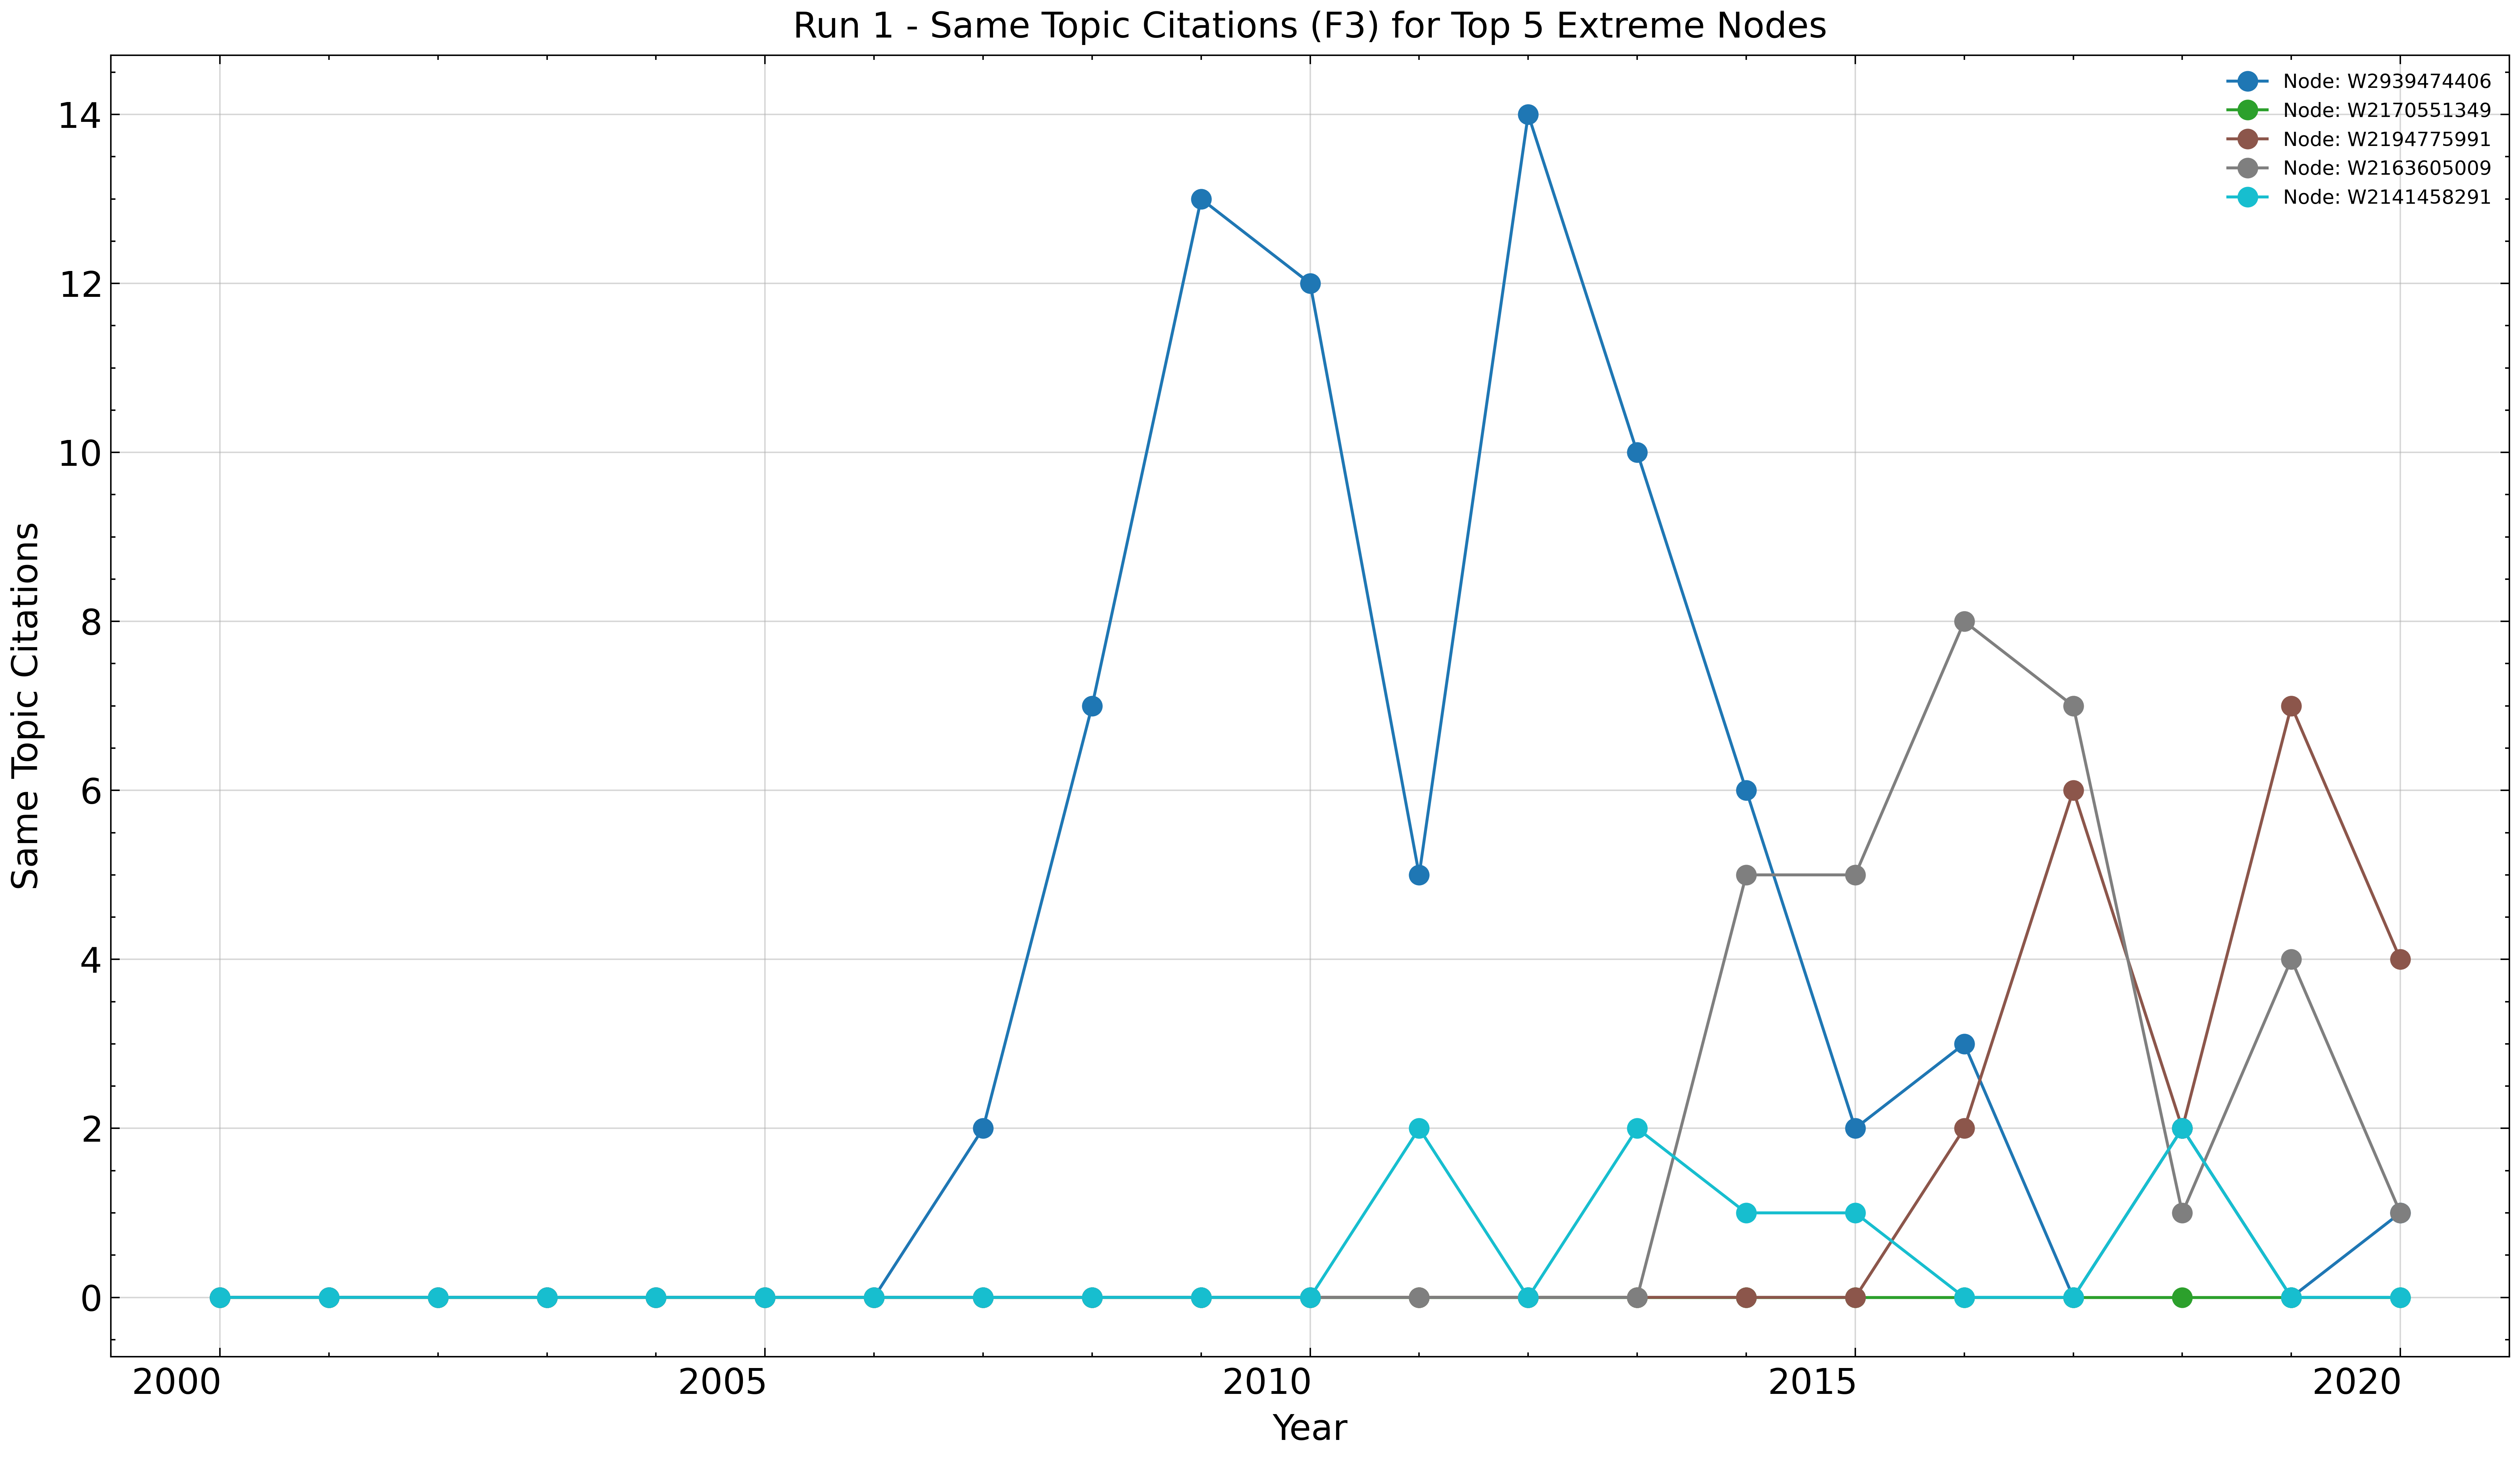

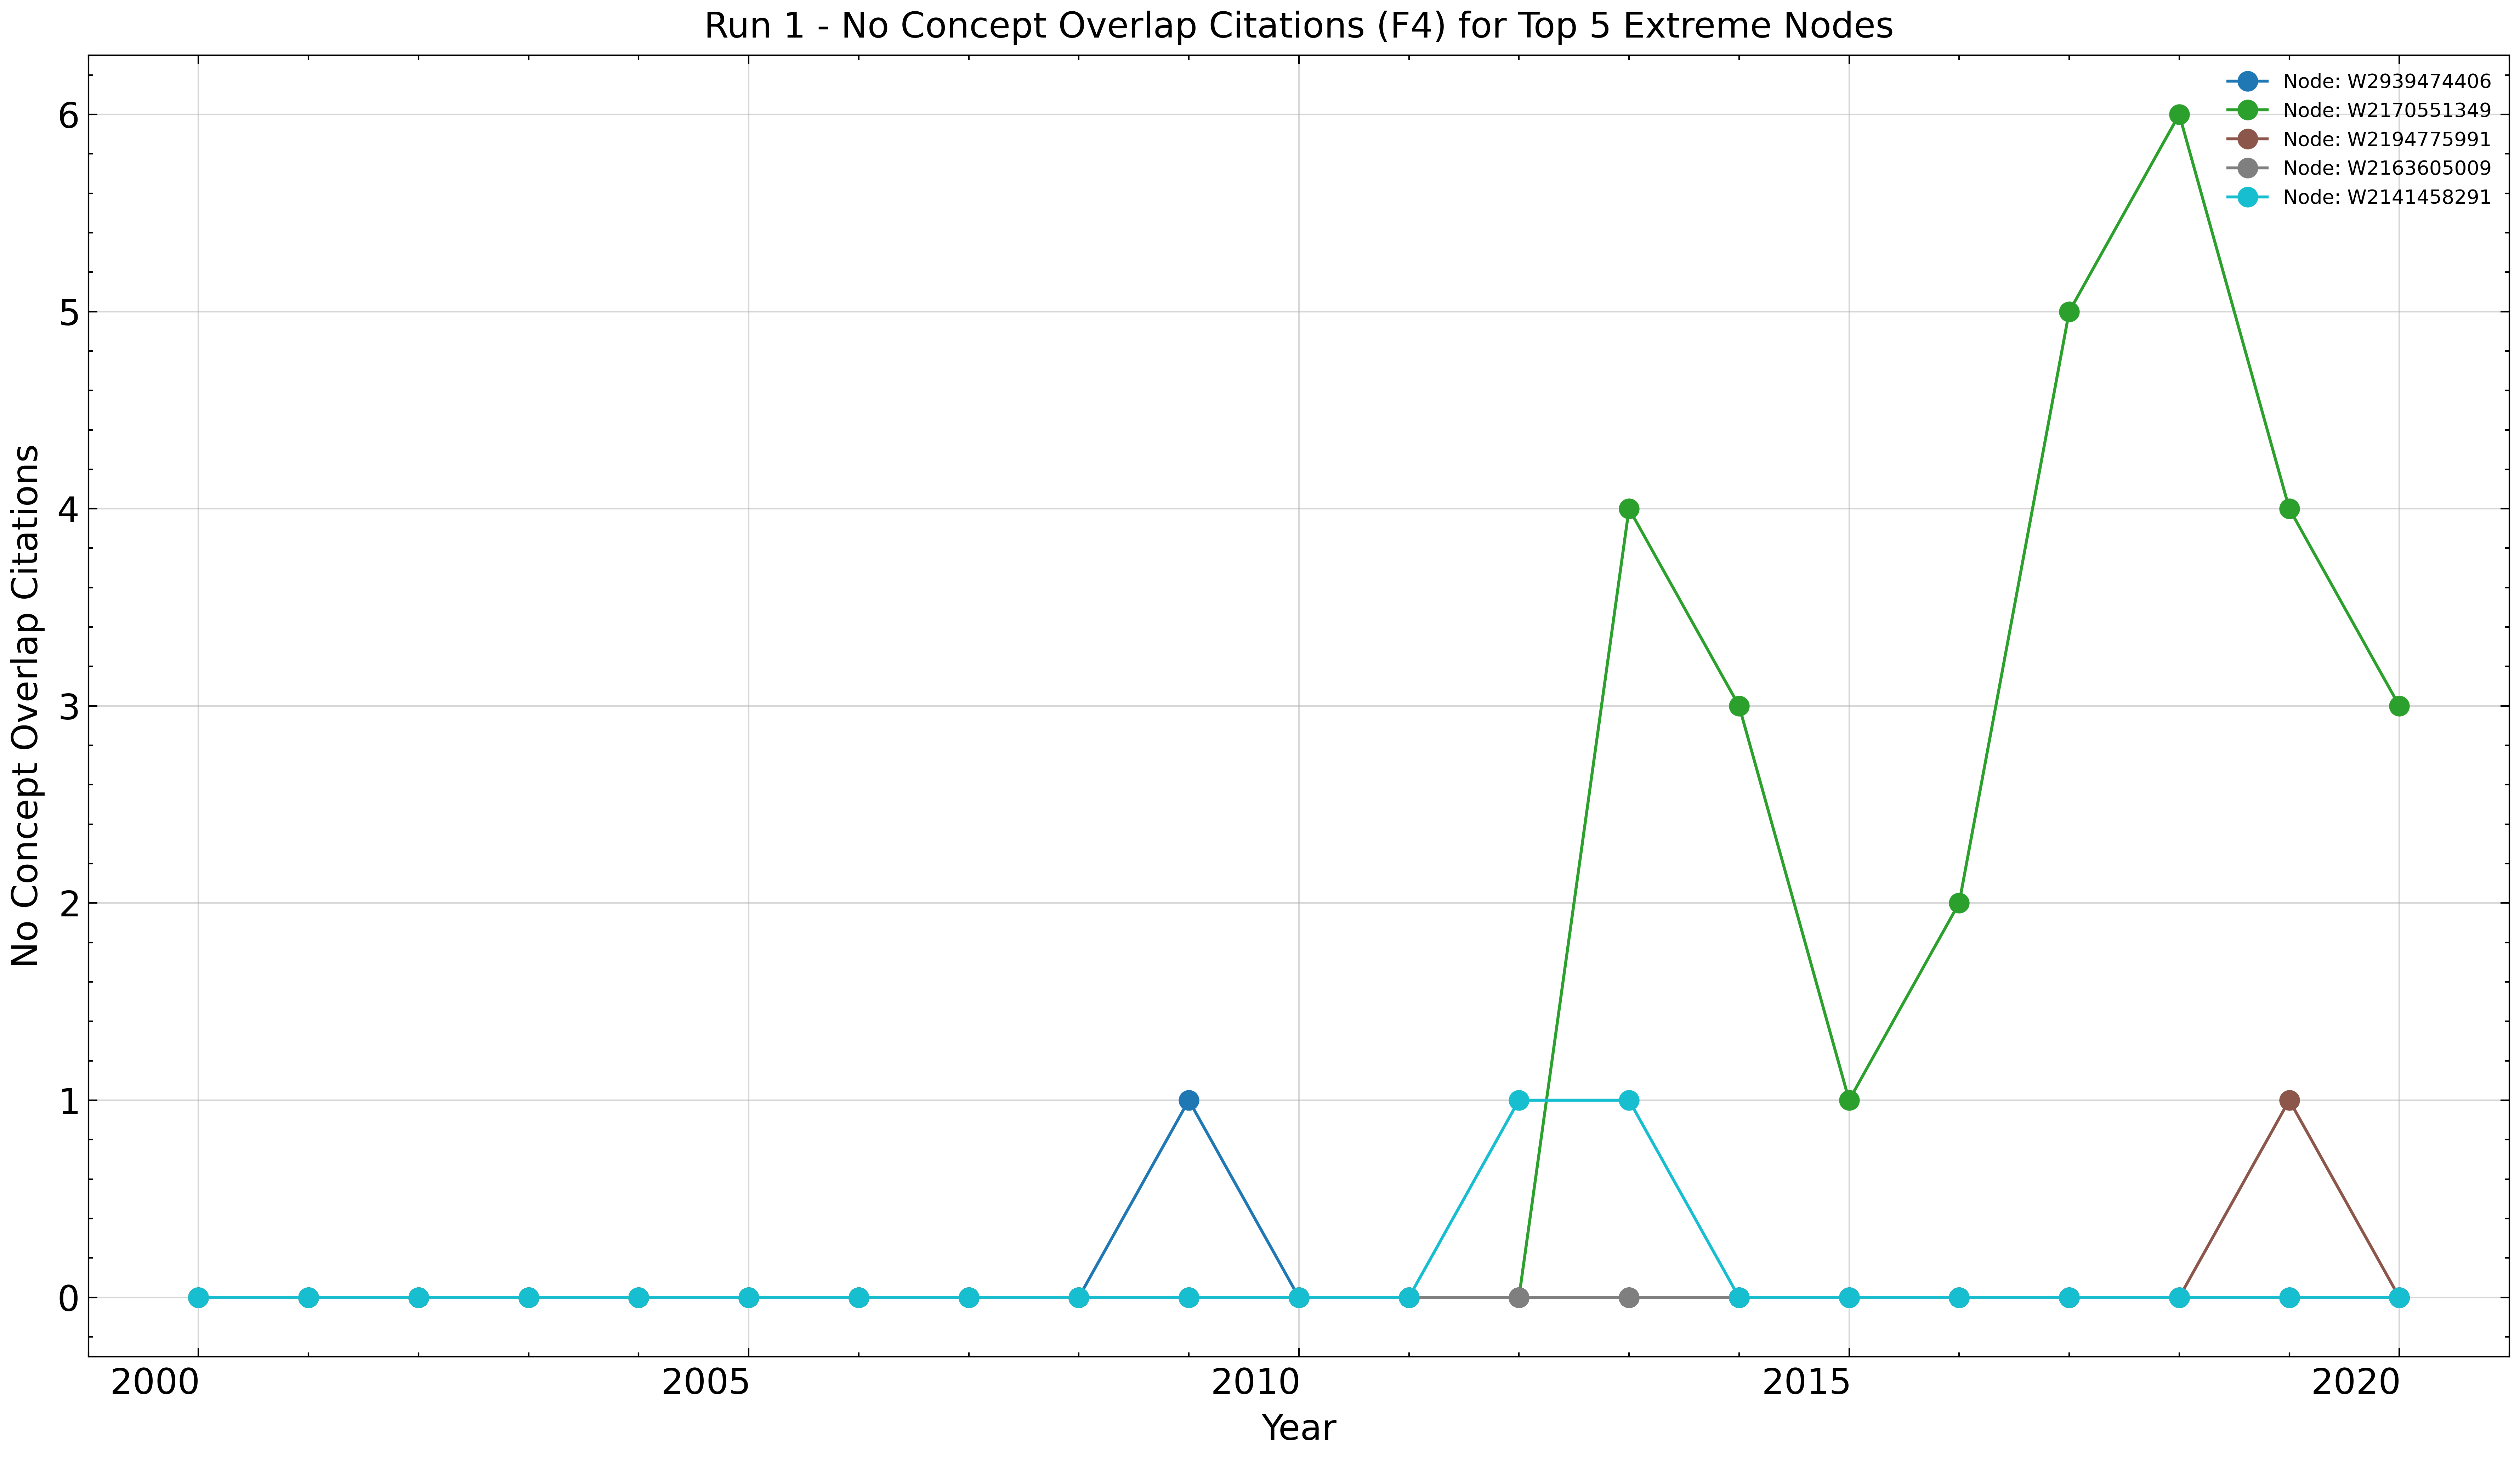


Finished Analyzing and Plotting Top Extreme Nodes Per Run.



In [39]:
# Ensure plotting style is set for consistency
plt.style.use(['ieee', 'science', 'no-latex'])
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
plt.rcParams["font.family"] = 'DejaVu Sans'


# Helper to save plots to iteration-specific directories
def save_node_plot(fig, conf_obj, original_id, plot_type, single_plot_for_run=False):
    save_dir = os.path.join(conf_obj.log_dir, 'plots', 'node_specific_plots')
    os.makedirs(save_dir, exist_ok=True)

    if single_plot_for_run:
        # For combined plots (like deviation scores for all 5 nodes in one run)
        save_path = os.path.join(save_dir, f'run_{conf_obj.iteration_num}_{plot_type}.png')
    else:
        # For individual node plots (like citation dynamics)
        save_path = os.path.join(save_dir, f'run_{conf_obj.iteration_num}_node_{original_id}_{plot_type}.png')

    fig.savefig(save_path, bbox_inches='tight')
    plt.show() # Display plot after saving
    plt.close(fig)

# --- Main Processing Loop for Node Analysis and Plotting ---
print("\n" + "="*80)
print("             Analyzing and Plotting Top Extreme Nodes Per Run")
print("="*80 + "\n")

# Assuming `k` and `conf` are available from the previous execution context.
# For robustness, ensure `conf` is loaded if this cell might be run independently.
try:
    conf
except NameError:
    conf = OmegaConf.load('config.yaml')

# Get the value of k from the kernel, assuming it's an integer variable `k`
try:
    k_val = int(k)
except NameError:
    print("Warning: Variable 'k' not found in kernel state. Defaulting to 1 iteration.")
    k_val = 1
except TypeError:
    print(f"Warning: Variable 'k' has unexpected type. Defaulting to 1 iteration. (Value: {k})")
    k_val = 1


for run_num_idx in range(k_val): # Loop from 0 to k-1
    run_num = run_num_idx + 1 # For display, use 1 to k
    print(f"\nProcessing Run: {run_num}/{k_val}")

    # Set iteration_num on the conf object for consistent plot naming
    conf.iteration_num = run_num

    base_data_dir = os.path.join("data", f"citation_run_{run_num}")
    base_log_dir = os.path.join("logs", f"citation_run_{run_num}", f"l{conf.lookback}_h{conf.horizon}", "CitationNetwork", "DiskNet")

    # FIX: Update conf.log_dir for the current iteration
    conf.log_dir = base_log_dir

    # Define paths for current run
    report_csv_path = os.path.join(base_log_dir, 'anomaly_report_per_year.csv')
    id2idx_path = os.path.join(base_data_dir, 'updated_id2idx_clean.json')
    meta_path = os.path.join(base_data_dir, 'updated_clean_meta.csv')
    dynamics_path = os.path.join(base_data_dir, 'dynamics.npz') # Path to the raw simulation dynamics


    try:
        # 1. Load Data for current run
        df_report = pd.read_csv(report_csv_path)
        with open(id2idx_path, 'r', encoding='utf-8') as f:
            id2idx_mapping = json.load(f)
        idx2id_mapping = {v: k_id for k_id, v in id2idx_mapping.items()} # Map from integer index to original string ID

        df_meta = pd.read_csv(meta_path, dtype={'id': str, 'year': 'Int64'}) # Metadata containing publication years
        dynamics_data = np.load(dynamics_path)['X'] # Raw dynamics data: (T, N, dim)

        # 2. Add Original ID and Is Synthetic status for analysis
        df_report['Original ID'] = df_report['Node ID'].map(idx2id_mapping)
        df_report['Is Synthetic'] = df_report['Original ID'].apply(lambda x: str(x).startswith('F'))

        # 3. Recalculate Z-scores for Mean Deviation Score (using overall mean/std for consistency within this run)
        mean_deviation_scores = df_report['Mean Deviation Score'].values
        mean_score_overall = np.mean(mean_deviation_scores)
        std_score_overall = np.std(mean_deviation_scores)

        if std_score_overall > 0:
            df_report['z_score'] = (mean_deviation_scores - mean_score_overall) / std_score_overall
            df_report['abs_z_score'] = df_report['z_score'].abs()
        else:
            df_report['z_score'] = 0
            df_report['abs_z_score'] = 0

        # 4. Identify Top 5 Extreme Nodes (highest absolute Z-score across all nodes in the report)
        top_extreme_nodes_df = df_report.nlargest(5, 'abs_z_score')
        print(f"  Identified top 5 extreme nodes for Run {run_num}:")
        for _, row in top_extreme_nodes_df.iterrows():
            print(f"    Node ID: {row['Original ID']}, Mean Dev Score: {row['Mean Deviation Score']:.4f}, Z-Score: {row['z_score']:.4f}")

        # --- Plot 1: Combined Deviation Score Plot Across Test Windows for all 5 top nodes ---
        fig_combined_dev_score, ax_combined_dev_score = plt.subplots(figsize=(12, 7))

        # Identify columns containing deviation scores and anomaly labels for each test window
        score_columns_for_run = [col for col in df_report.columns if '(Deviation Score)' in col]
        anomaly_label_columns_for_run = [col for col in df_report.columns if '(Is Anomaly)' in col]
        num_test_windows = len(score_columns_for_run) # Number of test time windows (e.g., 5)
        time_steps_for_plotting = np.arange(num_test_windows)

        cmap = plt.cm.get_cmap('tab10', len(top_extreme_nodes_df)) # Get distinct colors
        legend_elements_lines = []

        for i, (idx, node_info) in enumerate(top_extreme_nodes_df.iterrows()):
            node_int_id = node_info['Node ID']
            original_id = node_info['Original ID']
            node_color = cmap(i)

            deviation_scores_for_node = [node_info[col] for col in score_columns_for_run]

            # Plot the line for deviation scores
            line, = ax_combined_dev_score.plot(
                time_steps_for_plotting,
                deviation_scores_for_node,
                color=node_color,
                marker='', # No marker on the line itself
                linestyle='-',
                label=f'Node: {original_id} (Z-score: {node_info["z_score"]:.2f})'
            )
            legend_elements_lines.append(line)

            # Add scatter markers for anomaly status
            for j, score in enumerate(deviation_scores_for_node):
                is_anomaly = node_info[anomaly_label_columns_for_run[j]] # 1 if anomaly, 0 if normal
                marker_color = 'red' if is_anomaly == 1 else 'blue'
                ax_combined_dev_score.scatter(
                    time_steps_for_plotting[j],
                    score,
                    color=marker_color,
                    s=50, # Marker size
                    zorder=5 # Ensure markers are on top of lines
                )

        ax_combined_dev_score.set_title(f"Run {run_num} - Deviation Scores for Top 5 Extreme Nodes")
        ax_combined_dev_score.set_xlabel("Test Window (Year Index)")
        ax_combined_dev_score.set_ylabel("Deviation Score")
        ax_combined_dev_score.set_xticks(time_steps_for_plotting)
        ax_combined_dev_score.grid(True, alpha=0.5)

        # Create custom legend handles for marker colors
        from matplotlib.lines import Line2D
        legend_elements_markers = [
            Line2D([0], [0], marker='o', color='w', label='Anomaly', markerfacecolor='red', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=10)
        ]

        # Combine legends
        first_legend = ax_combined_dev_score.legend(handles=legend_elements_lines, title='Nodes', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
        ax_combined_dev_score.add_artist(first_legend) # Add first legend back
        ax_combined_dev_score.legend(handles=legend_elements_markers, title='Status (per window)', loc='lower left', bbox_to_anchor=(1, 0), fontsize='small')

        fig_combined_dev_score.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
        save_node_plot(fig_combined_dev_score, conf, 'all_top_nodes', 'combined_deviation_scores', single_plot_for_run=True)



        # Infer the actual range of years covered by the dynamics data
        dynamics_start_year = df_meta['year'].min()
        dynamics_end_year = df_meta['year'].max()
        dynamics_years_range = np.arange(dynamics_start_year, dynamics_end_year + 1)

        T_dynamics = dynamics_data.shape[0] # Number of time steps in dynamics data

        # Adjust dynamics_years_range if it doesn't match the actual data length
        if len(dynamics_years_range) != T_dynamics:
            print(f"    Warning: Inferred dynamics years range ({len(dynamics_years_range)}) does not match dynamics data length ({T_dynamics}). Adjusting plot years.")
            dynamics_years_range = np.arange(dynamics_start_year, dynamics_start_year + T_dynamics)

        # Re-use cmap for consistency in coloring nodes
        cmap_citation = plt.cm.get_cmap('tab10', len(top_extreme_nodes_df))

        feature_definitions = {
            0: {"name": "Yearly Incoming Citations (F1)", "ylabel": "Yearly Incoming Citations"},
            1: {"name": "Cumulative Subsequent Citations (F2)", "ylabel": "Cumulative Subsequent Citations"},
            2: {"name": "Same Topic Citations (F3)", "ylabel": "Same Topic Citations"},
            3: {"name": "No Concept Overlap Citations (F4)", "ylabel": "No Concept Overlap Citations"}
        }

        for feature_idx, feature_props in feature_definitions.items():
            fig_feature, ax_feature = plt.subplots(figsize=(12, 7))
            for i, (_, node_info) in enumerate(top_extreme_nodes_df.iterrows()):
                node_int_id = node_info['Node ID']
                original_id = node_info['Original ID']
                node_color_citation = cmap_citation(i)

                feature_dynamics = dynamics_data[:, node_int_id, feature_idx]

                ax_feature.plot(
                    dynamics_years_range,
                    feature_dynamics,
                    label=f'Node: {original_id}',
                    marker='o',
                    linestyle='-',
                    color=node_color_citation
                )

            ax_feature.set_title(f"Run {run_num} - {feature_props['name']} for Top 5 Extreme Nodes")
            ax_feature.set_xlabel("Year")
            ax_feature.set_ylabel(feature_props['ylabel'])
            selected_xticks = dynamics_years_range[::(len(dynamics_years_range)//5+1)]
            ax_feature.set_xticks(selected_xticks)
            plt.setp(ax_feature.get_xticklabels(), ha='right')
            ax_feature.grid(True, alpha=0.5)
            ax_feature.legend(loc='best', fontsize='small')
            fig_feature.tight_layout()
            save_node_plot(fig_feature, conf, 'all_top_nodes', f"combined_citation_dynamics_F{feature_idx+1}", single_plot_for_run=True)


    except FileNotFoundError as e:
        print(f"  Error: Required file not found for Run {run_num}: {e}. Skipping this run.")
    except Exception as e:
        print(f"  An unexpected error occurred processing Run {run_num}: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*80)
print("Finished Analyzing and Plotting Top Extreme Nodes Per Run.")
print("="*80 + "\n")